<a href="https://colab.research.google.com/github/FranciscoGlez25/CNN-TC/blob/main/GridSearch_VGG16_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas necesarias

**Configuración de Entorno y Dispositivo de Entrenamiento:**

En este bloque de código, se realizan las configuraciones iniciales del entorno y se establece el dispositivo de entrenamiento (CPU o GPU).

1. **Verificación de la Disponibilidad de CUDA:**
   - Se utiliza `torch.cuda.is_available()` para verificar si CUDA (plataforma de cómputo paralelo de NVIDIA) está disponible en el sistema. Esta función devuelve un booleano indicando si se puede usar GPU.

2. **Asignación del Dispositivo:**
   - Se utiliza un condicional para asignar el dispositivo de entrenamiento. Si CUDA está disponible, se asigna la GPU (`cuda:0`), de lo contrario, se utiliza la CPU.

3. **Comentario Informativo:**
   - Se agrega un comentario para informar sobre el movimiento del modelo al dispositivo de entrenamiento.

Este bloque establece las configuraciones básicas para aprovechar la GPU si está disponible y asegura que el modelo y los datos se manejen en el dispositivo adecuado durante el entrenamiento.

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import pandas as pd
from PIL import Image
import os
from tqdm.notebook import tqdm
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Mover modelo a dispositivo de entrenamient

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# **Definición de Transformaciones para el Preprocesamiento de Imágenes**

En este bloque de código, se definen las transformaciones necesarias para el preprocesamiento de imágenes.

1. **Transformaciones para Entrenamiento (`transform_train`):**
   - `v2.ToTensor()`: Convierte la imagen a un tensor.
   - `v2.CenterCrop(size=(850, 850))`: Realiza un recorte centrado en la imagen a un tamaño de 850x850 píxeles.
   - `v2.Resize(size=(224, 224))`: Cambia el tamaño de la imagen a 224x224 píxeles.
   - `v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza los valores de los píxeles de acuerdo con la media y la desviación estándar proporcionadas. Esta transformación es común en modelos preentrenados.

2. **Transformaciones para Pruebas (`transform_test`):**
   - `v2.ToTensor()`: Convierte la imagen a un tensor.
   - `v2.CenterCrop(size=(850, 850))`: Realiza un recorte centrado en la imagen a un tamaño de 850x850 píxeles.
   - `v2.Resize(size=(224, 224))`: Cambia el tamaño de la imagen a 224x224 píxeles.
   - `v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza los valores de los píxeles de acuerdo con la media y la desviación estándar proporcionadas.

Estas transformaciones son comunes al trabajar con modelos de redes neuronales convolucionales (CNN) y siguen las prácticas típicas de preprocesamiento para datos de imágenes. La normalización es especialmente importante para garantizar que los valores de píxeles estén en una escala adecuada para el modelo. El recorte y el cambio de tamaño ayudan a adaptar las imágenes a las dimensiones esperadas por el modelo.

In [ ]:
# Definir transformaciones para el preprocesamiento de las imágenes
transform_train = v2.Compose([
                    v2.ToTensor(),
                    v2.CenterCrop(size = (850,850)),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomHorizontalFlip(p=0.5),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

transform_test = v2.Compose([v2.ToTensor(),
                    v2.CenterCrop(size = (850,850)),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# **Definición de Dataset Personalizado para Cargar Imágenes y Clases**

En este bloque de código, se crea una clase `CustomDataset` que hereda de la clase `Dataset` de PyTorch.

- **Constructor (`__init__`):**
  - `csv_file`: Ruta del archivo CSV que contiene la información de las imágenes y etiquetas.
  - `root_dir`: Directorio raíz donde se encuentran las imágenes.
  - `transform`: Transformaciones a aplicar a las imágenes (por ejemplo, preprocesamiento).

- **Método `__len__`:**
  - Devuelve la longitud del conjunto de datos, es decir, el número total de muestras.

- **Método `__getitem__`:**
  - `index`: Índice de la muestra que se desea obtener.
  - Lee la ruta de la imagen y la etiqueta correspondiente desde el archivo CSV.
  - Abre la imagen en formato RGB utilizando `PIL.Image`.
  - Aplica las transformaciones especificadas (si las hay) a la imagen.
  - Devuelve la imagen y la etiqueta como salida.

- **Atributos:**
  - `annotations`: Un DataFrame de pandas que almacena la información del archivo CSV.
  - `root_dir`: Ruta del directorio raíz de las imágenes.
  - `transform`: Transformaciones a aplicar a las imágenes.
  - `num_classes`: Número de clases en el conjunto de datos, calculado a partir de las etiquetas únicas en el archivo CSV.

Esta clase facilita la carga y manipulación de datos para el entrenamiento y la evaluación de modelos, permitiendo la flexibilidad en el preprocesamiento mediante el uso de transformaciones.

In [ ]:
# Definir dataset personalizado para cargar imágenes y clases desde archivos CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Obtener el número de clases desde el conjunto de datos
        self.num_classes = len(self.annotations['Egreso'].unique())  # Suponiendo que la columna de etiquetas se llama 'label'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.annotations.iloc[index, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Creación del Conjunto de Datos de Entrenamiento**

En este bloque de código, se instancia el conjunto de datos de entrenamiento (`train_dataset`) utilizando la clase `CustomDataset` definida anteriormente.

- **Creación del Conjunto de Datos:**
  - Se instancia un objeto `CustomDataset` con los siguientes parámetros:
    - `csv_file`: Ruta del archivo CSV que contiene la información de las imágenes y etiquetas.
    - `root_dir`: Ruta del directorio raíz donde se encuentran las imágenes.
    - `transform`: Transformaciones a aplicar a las imágenes durante el preprocesamiento. En este caso, se utiliza la transformación `transform_train`.

- **Longitud del Conjunto de Datos:**
  - Se calcula y almacena en la variable `total_train` la cantidad total de imágenes en el conjunto de datos de entrenamiento.

- **Impresión del Resumen:**
  - Se imprime en pantalla la cantidad total de imágenes en el conjunto de datos de entrenamiento.

Este bloque es crucial para la preparación del conjunto de datos antes de pasar a las etapas de entrenamiento y evaluación de un modelo de aprendizaje profundo. La variable `train_dataset` se utilizará posteriormente para crear un DataLoader y facilitar el acceso a los lotes de datos durante el entrenamiento.

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define el conjunto de datos completo
train_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_train)

total_train = len(train_dataset)
print(f'Cantidad total de imágenes en Train Dataset: {total_train}')

Cantidad total de imágenes en Train Dataset: 963


# **Número de Clases en el Conjunto de Datos de Entrenamiento**


En este bloque de código, se obtiene el número de clases presente en el conjunto de datos de entrenamiento (`train_dataset`).

- **Número de Clases:**
  - Se accede a la propiedad `num_classes` del conjunto de datos de entrenamiento (`train_dataset`) para obtener el número de clases presentes en el conjunto.

- **Impresión del Resultado:**
  - Se imprime en pantalla el número de clases obtenidas en el conjunto de datos de entrenamiento.

Este paso es fundamental para comprender la distribución y la naturaleza de las clases en el conjunto de datos de entrenamiento, lo cual es crucial para la configuración y evaluación adecuada de modelos de aprendizaje profundo.

In [ ]:
num_classes = train_dataset.num_classes
print("Clases obtenidas en el conjunto Train Dataset:", num_classes)

Clases obtenidas en el conjunto Train Dataset: 2


# **División del Conjunto de Datos en Entrenamiento y Validación**

En este bloque de código, se realiza la división del conjunto de datos en conjuntos de entrenamiento y validación.

- **Número Total de Muestras:**
  - Se obtiene el número total de muestras en el conjunto de entrenamiento original mediante la función `len(train_dataset)`.

- **Tamaño del Conjunto de Validación:**
  - Se calcula el tamaño del conjunto de validación como un porcentaje del tamaño total del conjunto de entrenamiento. En este caso, se utiliza un 20% para el conjunto de validación.

- **Tamaño del Conjunto de Entrenamiento:**
  - El tamaño del conjunto de entrenamiento se calcula restando el tamaño del conjunto de validación del tamaño total del conjunto.

- **División del Conjunto de Datos:**
  - Utilizando la función `random_split` de PyTorch, se divide el conjunto de entrenamiento original en conjuntos de entrenamiento y validación según los tamaños calculados.

- **DataLoaders:**
  - Se definen los `DataLoaders` para los conjuntos de entrenamiento (`train_loader`) y validación (`val_loader`) con tamaños de lote (batch sizes) de 64 y se configura el parámetro `shuffle` para mezclar los datos.

Esta división es esencial para entrenar y validar modelos de aprendizaje profundo de manera efectiva y evaluar su rendimiento de manera confiable. La utilización de conjuntos de validación ayuda a ajustar los hiperparámetros y prevenir el sobreajuste del modelo.

In [ ]:
# Obtén el número total de muestras en el conjunto de entrenamiento
total_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (por ejemplo, el 20%)
validation_split = 0.2
validation_size = int(validation_split * total_samples)

# Calcula el tamaño del conjunto de entrenamiento
train_size = total_samples - validation_size

# Divide el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Define los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

# **Cantidad Total de Imágenes en Conjuntos de Entrenamiento y Validación**

En este bloque de código, se obtiene la cantidad total de imágenes en los conjuntos de entrenamiento (`train_loader`) y validación (`val_loader`).

- **Cantidad Total de Imágenes en Conjunto de Entrenamiento:**
  - Se utiliza la función `len(train_loader.dataset)` para obtener la cantidad total de imágenes en el conjunto de entrenamiento después de la división. Este valor se almacena en la variable `total_images_train`.

- **Cantidad Total de Imágenes en Conjunto de Validación:**
  - De manera similar, se utiliza la función `len(val_loader.dataset)` para obtener la cantidad total de imágenes en el conjunto de validación después de la división. Este valor se almacena en la variable `total_images_validation`.

- **Impresión de Resultados:**
  - Se imprime en la consola la cantidad total de imágenes en el conjunto de entrenamiento y el conjunto de validación después de realizar la división.

Esta información es útil para tener una visión general de la cantidad de datos disponibles para el entrenamiento y la validación del modelo. Además, proporciona una verificación rápida de que la división del conjunto de datos se realizó correctamente.

In [ ]:
# Obtén la cantidad total de imágenes en train_loader y validation_loader
total_images_train = len(train_loader.dataset)
total_images_validation = len(val_loader.dataset)

# Imprime la cantidad total de imágenes
print(f'Cantidad total de imágenes en Train Dataset despues de realizar split: {total_images_train}')
print(f'Cantidad total de imágenes en Validation Dataset: {total_images_validation}')

Cantidad total de imágenes en Train Dataset despues de realizar split: 771
Cantidad total de imágenes en Validation Dataset: 192


# **Definición de Hiperparámetros para Search Grid**

En este bloque de código, se establecen los hiperparámetros que se ajustarán durante el proceso de búsqueda de cuadrícula.

- **Hiperparámetros a Ajustar:**
  - Se define un diccionario llamado `param_grid` que contiene los hiperparámetros a ajustar. En este caso, los hiperparámetros son:
    - `'learning_rate'`: Una lista de tasas de aprendizaje para probar, que incluye los valores `[0.00001, 0.0001, 0.001]`.
    - `'optimizer'`: Una lista de optimizadores para probar, que incluye los valores `['SGD', 'Adam', 'RMSprop']`.

Estos hiperparámetros son fundamentales para el entrenamiento de modelos de aprendizaje profundo, y ajustar sus valores puede tener un impacto significativo en el rendimiento del modelo. Durante la búsqueda de cuadrícula, se probarán todas las combinaciones posibles de estos hiperparámetros para encontrar la configuración que optimice la métrica de interés.

In [ ]:

param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001],
    'optimizer': ['SGD', 'Adam', 'RMSprop']
}


# **Búsqueda de Cuadrícula para Mejores Hiperparámetros**

En este bloque de código, se lleva a cabo un proceso de búsqueda de cuadrícula para encontrar los mejores hiperparámetros que optimizan la pérdida de validación.

- **Inicialización y Configuración:**
  - `torch.cuda.empty_cache()`: Limpia la memoria de la GPU para evitar posibles problemas de memoria.
  - `epochs = 100`: Número total de épocas para entrenar el modelo.

- **Definición de Variables para Rastreo:**
  - `best_val_loss = float('inf')`: Inicializa la mejor pérdida de validación como infinito.
  - `best_hyperparameters = {}`: Almacena los mejores hiperparámetros encontrados.
  - `best_model = None`: Almacena el mejor modelo encontrado.
  - `val_loss_dict = {}`: Diccionario para almacenar las pérdidas de validación por combinación de hiperparámetros.

- **Bucle de Búsqueda de Cuadrícula:**
  - Se itera a través de todas las combinaciones posibles de hiperparámetros utilizando `ParameterGrid(param_grid)`.
  - Para cada combinación de hiperparámetros:
    - Se imprime la información sobre la combinación actual.
    - Se carga un modelo preentrenado (VGG-16 en este caso) y se modifica la capa de clasificación para adaptarse al problema de dos clases, incluyendo capas de BatchNorm.
    - Se define la función de pérdida (`nn.CrossEntropyLoss`) y se mueve el modelo y la función de pérdida al dispositivo de entrenamiento (GPU si está disponible).
    - Se define el optimizador según el hiperparámetro 'optimizer'.
    - Se inicializan las variables para rastrear las métricas de entrenamiento y validación, y se limpia la memoria de la GPU.
    - Se realiza el bucle de entrenamiento a lo largo de las épocas especificadas.
    - Se evalúa el modelo en el conjunto de validación y se rastrean las métricas de validación.
    - Se guarda el modelo si la pérdida de validación es la mejor hasta el momento.
    - Se almacena la pérdida de validación en el diccionario `val_loss_dict`.
    - Se crea y guarda un gráfico de la pérdida y la precisión durante las épocas.

- **Determinación de los Mejores Hiperparámetros:**
  - Después de completar todos los bucles, se determinan los mejores hiperparámetros como aquellos que minimizan la pérdida de validación.
  - Se imprime la información sobre los mejores hiperparámetros encontrados.

- **Resumen Gráfico:**
  - Se usa la librería `termcolor` para resaltar y mostrar los mejores hiperparámetros en rojo y negrita.

Este bloque de código es esencial para la optimización de los hiperparámetros y el entrenamiento eficiente de modelos de aprendizaje profundo. La búsqueda de cuadrícula permite explorar diferentes combinaciones de tasas de aprendizaje y optimizadores para encontrar la configuración óptima.

Entrenando con learning_rate=0.00001, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 198MB/s]


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.490272373540856
Epoch 1 Training Loss = 1.1123343759087119
Epoch 1 Validation Accuracy = 0.515625
Epoch 1 Validation Loss = 0.7198154330253601
La mejor precisión de Validation Loss (0.7198154330253601) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.5265888456549935
Epoch 2 Training Loss = 0.97208799029448
Epoch 2 Validation Accuracy = 0.546875
Epoch 2 Validation Loss = 0.7350281278292338
La mejor precisión de Validation Loss (0.7198154330253601) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.4915693904020752
Epoch 3 Training Loss = 1.05053719843408
Epoch 3 Validation Accuracy = 0.5364583333333334
Epoch 3 Validation Loss = 0.7333297332127889
La mejor precisión de Validation Loss (0.7198154330253601) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5201037613488976
Epoch 4 Training Loss = 0.9530528692574507
Epoch 4 Validation Accuracy = 0.5833333333333334
Epoch 4 Validation Loss = 0.6975384553273519
La mejor precisión de Validation Loss (0.6975384553273519) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5175097276264592
Epoch 5 Training Loss = 1.0300987846038065
Epoch 5 Validation Accuracy = 0.640625
Epoch 5 Validation Loss = 0.6624250610669454
La mejor precisión de Validation Loss (0.6624250610669454) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5447470817120622
Epoch 6 Training Loss = 0.9474319102273996
Epoch 6 Validation Accuracy = 0.6041666666666666
Epoch 6 Validation Loss = 0.6643222371737162
La mejor precisión de Validation Loss (0.6624250610669454) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5499351491569391
Epoch 7 Training Loss = 0.9861507460610257
Epoch 7 Validation Accuracy = 0.6302083333333334
Epoch 7 Validation Loss = 0.6568642457326254
La mejor precisión de Validation Loss (0.6568642457326254) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5486381322957199
Epoch 8 Training Loss = 0.924020311982406
Epoch 8 Validation Accuracy = 0.640625
Epoch 8 Validation Loss = 0.6562701861063639
La mejor precisión de Validation Loss (0.6562701861063639) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5330739299610895
Epoch 9 Training Loss = 0.9614162748889701
Epoch 9 Validation Accuracy = 0.65625
Epoch 9 Validation Loss = 0.6277539134025574
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5538261997405967
Epoch 10 Training Loss = 0.9129929290516676
Epoch 10 Validation Accuracy = 0.625
Epoch 10 Validation Loss = 0.6716928680737814
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.5447470817120622
Epoch 11 Training Loss = 0.9798147729398675
Epoch 11 Validation Accuracy = 0.6510416666666666
Epoch 11 Validation Loss = 0.6620054443677267
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5382619974059663
Epoch 12 Training Loss = 0.9707050996841006
Epoch 12 Validation Accuracy = 0.65625
Epoch 12 Validation Loss = 0.6425875624020895
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.5097276264591439
Epoch 13 Training Loss = 1.003477722986199
Epoch 13 Validation Accuracy = 0.6458333333333334
Epoch 13 Validation Loss = 0.6623813112576803
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.5201037613488976
Epoch 14 Training Loss = 0.9655807890316855
Epoch 14 Validation Accuracy = 0.6614583333333334
Epoch 14 Validation Loss = 0.6761327783266703
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.5538261997405967
Epoch 15 Training Loss = 0.942441308042264
Epoch 15 Validation Accuracy = 0.640625
Epoch 15 Validation Loss = 0.6444600025812784
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.569390402075227
Epoch 16 Training Loss = 0.908650606445456
Epoch 16 Validation Accuracy = 0.6510416666666666
Epoch 16 Validation Loss = 0.6309388677279154
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.5862516212710766
Epoch 17 Training Loss = 0.9206842033315725
Epoch 17 Validation Accuracy = 0.6302083333333334
Epoch 17 Validation Loss = 0.6314537525177002
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.5473411154345007
Epoch 18 Training Loss = 0.9209416631594706
Epoch 18 Validation Accuracy = 0.609375
Epoch 18 Validation Loss = 0.6396686236063639
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.5914396887159533
Epoch 19 Training Loss = 0.8851403384511728
Epoch 19 Validation Accuracy = 0.6458333333333334
Epoch 19 Validation Loss = 0.6496083736419678
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.5758754863813229
Epoch 20 Training Loss = 0.9029254998755671
Epoch 20 Validation Accuracy = 0.5989583333333334
Epoch 20 Validation Loss = 0.6664718588193258
La mejor precisión de Validation Loss (0.6277539134025574) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5680933852140078
Epoch 21 Training Loss = 0.9152217445515782
Epoch 21 Validation Accuracy = 0.6510416666666666
Epoch 21 Validation Loss = 0.6114077965418497
La mejor precisión de Validation Loss (0.6114077965418497) se alcanzó en la época 21


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.569390402075227
Epoch 22 Training Loss = 0.8807650380097475
Epoch 22 Validation Accuracy = 0.7291666666666666
Epoch 22 Validation Loss = 0.5693945487340292
La mejor precisión de Validation Loss (0.5693945487340292) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.5616083009079118
Epoch 23 Training Loss = 0.8879986040477778
Epoch 23 Validation Accuracy = 0.7239583333333334
Epoch 23 Validation Loss = 0.5419673124949137
La mejor precisión de Validation Loss (0.5419673124949137) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.5745784695201037
Epoch 24 Training Loss = 0.8932516196049296
Epoch 24 Validation Accuracy = 0.7135416666666666
Epoch 24 Validation Loss = 0.5394612352053324
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.5966277561608301
Epoch 25 Training Loss = 0.9170967995270063
Epoch 25 Validation Accuracy = 0.6927083333333334
Epoch 25 Validation Loss = 0.5577405194441477
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5940337224383917
Epoch 26 Training Loss = 0.873631698534801
Epoch 26 Validation Accuracy = 0.71875
Epoch 26 Validation Loss = 0.5618600845336914
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.5797665369649806
Epoch 27 Training Loss = 0.8683540402064837
Epoch 27 Validation Accuracy = 0.6666666666666666
Epoch 27 Validation Loss = 0.6044011116027832
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5745784695201037
Epoch 28 Training Loss = 0.9207085786162648
Epoch 28 Validation Accuracy = 0.578125
Epoch 28 Validation Loss = 0.6642275452613831
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.5836575875486382
Epoch 29 Training Loss = 0.889884004023907
Epoch 29 Validation Accuracy = 0.5989583333333334
Epoch 29 Validation Loss = 0.663400133450826
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.5706874189364461
Epoch 30 Training Loss = 0.9175898128137205
Epoch 30 Validation Accuracy = 0.6875
Epoch 30 Validation Loss = 0.6004337867101034
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.5473411154345007
Epoch 31 Training Loss = 0.9496497643287698
Epoch 31 Validation Accuracy = 0.6979166666666666
Epoch 31 Validation Loss = 0.5537308653195699
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.5512321660181583
Epoch 32 Training Loss = 0.9324659930128996
Epoch 32 Validation Accuracy = 0.7135416666666666
Epoch 32 Validation Loss = 0.5722342530886332
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.5603112840466926
Epoch 33 Training Loss = 0.9149127583250152
Epoch 33 Validation Accuracy = 0.7239583333333334
Epoch 33 Validation Loss = 0.5984209179878235
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.603112840466926
Epoch 34 Training Loss = 0.8696490239579081
Epoch 34 Validation Accuracy = 0.703125
Epoch 34 Validation Loss = 0.5982547998428345
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.5888456549935149
Epoch 35 Training Loss = 0.8743527244037227
Epoch 35 Validation Accuracy = 0.6979166666666666
Epoch 35 Validation Loss = 0.5891492962837219
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.5836575875486382
Epoch 36 Training Loss = 0.8846034739267965
Epoch 36 Validation Accuracy = 0.7083333333333334
Epoch 36 Validation Loss = 0.5978486140569051
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.5810635538261998
Epoch 37 Training Loss = 0.8461176984968817
Epoch 37 Validation Accuracy = 0.65625
Epoch 37 Validation Loss = 0.6242286364237467
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.582360570687419
Epoch 38 Training Loss = 0.8698404343984779
Epoch 38 Validation Accuracy = 0.65625
Epoch 38 Validation Loss = 0.6225889325141907
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.5901426718547341
Epoch 39 Training Loss = 0.8823060303269348
Epoch 39 Validation Accuracy = 0.671875
Epoch 39 Validation Loss = 0.6055615146954855
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.5667963683527886
Epoch 40 Training Loss = 0.8863730395041242
Epoch 40 Validation Accuracy = 0.71875
Epoch 40 Validation Loss = 0.5832805832227071
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.5551232166018158
Epoch 41 Training Loss = 0.8852901134818754
Epoch 41 Validation Accuracy = 0.7083333333333334
Epoch 41 Validation Loss = 0.5660181045532227
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.5875486381322957
Epoch 42 Training Loss = 0.9043771349347828
Epoch 42 Validation Accuracy = 0.7135416666666666
Epoch 42 Validation Loss = 0.5737739602724711
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.6018158236057068
Epoch 43 Training Loss = 0.8565061006564575
Epoch 43 Validation Accuracy = 0.734375
Epoch 43 Validation Loss = 0.5722384452819824
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.5875486381322957
Epoch 44 Training Loss = 0.8779745488469858
Epoch 44 Validation Accuracy = 0.7135416666666666
Epoch 44 Validation Loss = 0.5442339976628622
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.6095979247730221
Epoch 45 Training Loss = 0.8033275752679847
Epoch 45 Validation Accuracy = 0.7135416666666666
Epoch 45 Validation Loss = 0.572942316532135
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.5797665369649806
Epoch 46 Training Loss = 0.7896072780266501
Epoch 46 Validation Accuracy = 0.7291666666666666
Epoch 46 Validation Loss = 0.57362033923467
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.5992217898832685
Epoch 47 Training Loss = 0.8282255452276049
Epoch 47 Validation Accuracy = 0.7604166666666666
Epoch 47 Validation Loss = 0.5551355679829916
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.6264591439688716
Epoch 48 Training Loss = 0.7819902876007881
Epoch 48 Validation Accuracy = 0.75
Epoch 48 Validation Loss = 0.5605748295783997
La mejor precisión de Validation Loss (0.5394612352053324) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.6277561608300908
Epoch 49 Training Loss = 0.7709574670024728
Epoch 49 Validation Accuracy = 0.7552083333333334
Epoch 49 Validation Loss = 0.5367445151011149
La mejor precisión de Validation Loss (0.5367445151011149) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.6147859922178989
Epoch 50 Training Loss = 0.8272545134356359
Epoch 50 Validation Accuracy = 0.7291666666666666
Epoch 50 Validation Loss = 0.5525075793266296
La mejor precisión de Validation Loss (0.5367445151011149) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.6316472114137484
Epoch 51 Training Loss = 0.7837180764294784
Epoch 51 Validation Accuracy = 0.7552083333333334
Epoch 51 Validation Loss = 0.5536376237869263
La mejor precisión de Validation Loss (0.5367445151011149) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.603112840466926
Epoch 52 Training Loss = 0.8088157783841036
Epoch 52 Validation Accuracy = 0.7447916666666666
Epoch 52 Validation Loss = 0.5497572223345438
La mejor precisión de Validation Loss (0.5367445151011149) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.6160830090791181
Epoch 53 Training Loss = 0.7986266403501291
Epoch 53 Validation Accuracy = 0.765625
Epoch 53 Validation Loss = 0.5485323568185171
La mejor precisión de Validation Loss (0.5367445151011149) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.6251621271076524
Epoch 54 Training Loss = 0.7525354270495948
Epoch 54 Validation Accuracy = 0.7708333333333334
Epoch 54 Validation Loss = 0.5358863770961761
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.6212710765239948
Epoch 55 Training Loss = 0.7688977672354875
Epoch 55 Validation Accuracy = 0.7552083333333334
Epoch 55 Validation Loss = 0.5392736593882242
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.6108949416342413
Epoch 56 Training Loss = 0.7662169104574874
Epoch 56 Validation Accuracy = 0.7708333333333334
Epoch 56 Validation Loss = 0.5548162659009298
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.6173800259403373
Epoch 57 Training Loss = 0.8077161097186394
Epoch 57 Validation Accuracy = 0.7291666666666666
Epoch 57 Validation Loss = 0.5627058347066244
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.603112840466926
Epoch 58 Training Loss = 0.8522175298435988
Epoch 58 Validation Accuracy = 0.7604166666666666
Epoch 58 Validation Loss = 0.5367568731307983
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.62905317769131
Epoch 59 Training Loss = 0.8187467164411928
Epoch 59 Validation Accuracy = 0.7552083333333334
Epoch 59 Validation Loss = 0.557667483886083
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.6057068741893644
Epoch 60 Training Loss = 0.8150621384343594
Epoch 60 Validation Accuracy = 0.7760416666666666
Epoch 60 Validation Loss = 0.5522788465023041
La mejor precisión de Validation Loss (0.5358863770961761) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.6472114137483788
Epoch 61 Training Loss = 0.7501302768129628
Epoch 61 Validation Accuracy = 0.7604166666666666
Epoch 61 Validation Loss = 0.5305134952068329
La mejor precisión de Validation Loss (0.5305134952068329) se alcanzó en la época 61


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.6134889753566797
Epoch 62 Training Loss = 0.7906328203535884
Epoch 62 Validation Accuracy = 0.75
Epoch 62 Validation Loss = 0.553902784983317
La mejor precisión de Validation Loss (0.5305134952068329) se alcanzó en la época 61


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.6614785992217899
Epoch 63 Training Loss = 0.7218069905746153
Epoch 63 Validation Accuracy = 0.7708333333333334
Epoch 63 Validation Loss = 0.5273112456003824
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.6264591439688716
Epoch 64 Training Loss = 0.7538656900828914
Epoch 64 Validation Accuracy = 0.765625
Epoch 64 Validation Loss = 0.5280343194802603
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.6264591439688716
Epoch 65 Training Loss = 0.7685818624635615
Epoch 65 Validation Accuracy = 0.78125
Epoch 65 Validation Loss = 0.5292154351870219
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.6562905317769131
Epoch 66 Training Loss = 0.7417696328633181
Epoch 66 Validation Accuracy = 0.7864583333333334
Epoch 66 Validation Loss = 0.5386405984560648
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.6562905317769131
Epoch 67 Training Loss = 0.7516798591180843
Epoch 67 Validation Accuracy = 0.734375
Epoch 67 Validation Loss = 0.551585465669632
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.6640726329442282
Epoch 68 Training Loss = 0.714030717829322
Epoch 68 Validation Accuracy = 0.7291666666666666
Epoch 68 Validation Loss = 0.5458043217658997
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.622568093385214
Epoch 69 Training Loss = 0.815796051198561
Epoch 69 Validation Accuracy = 0.7395833333333334
Epoch 69 Validation Loss = 0.5462658405303955
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.6355382619974059
Epoch 70 Training Loss = 0.7803325890412436
Epoch 70 Validation Accuracy = 0.734375
Epoch 70 Validation Loss = 0.5476588308811188
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.622568093385214
Epoch 71 Training Loss = 0.7615992363479506
Epoch 71 Validation Accuracy = 0.703125
Epoch 71 Validation Loss = 0.5380872587362925
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.6588845654993515
Epoch 72 Training Loss = 0.7231876012106968
Epoch 72 Validation Accuracy = 0.7291666666666666
Epoch 72 Validation Loss = 0.5441000660260519
La mejor precisión de Validation Loss (0.5273112456003824) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.6536964980544747
Epoch 73 Training Loss = 0.7293186441315133
Epoch 73 Validation Accuracy = 0.7395833333333334
Epoch 73 Validation Loss = 0.5223189493020376
La mejor precisión de Validation Loss (0.5223189493020376) se alcanzó en la época 73


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.6407263294422828
Epoch 74 Training Loss = 0.7641538889491605
Epoch 74 Validation Accuracy = 0.734375
Epoch 74 Validation Loss = 0.5214973489443461
La mejor precisión de Validation Loss (0.5214973489443461) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.6459143968871596
Epoch 75 Training Loss = 0.7096174834960475
Epoch 75 Validation Accuracy = 0.75
Epoch 75 Validation Loss = 0.5344075163205465
La mejor precisión de Validation Loss (0.5214973489443461) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.6588845654993515
Epoch 76 Training Loss = 0.7472496848316663
Epoch 76 Validation Accuracy = 0.7239583333333334
Epoch 76 Validation Loss = 0.5357241630554199
La mejor precisión de Validation Loss (0.5214973489443461) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.6588845654993515
Epoch 77 Training Loss = 0.7343582463403621
Epoch 77 Validation Accuracy = 0.7239583333333334
Epoch 77 Validation Loss = 0.5437139272689819
La mejor precisión de Validation Loss (0.5214973489443461) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.6575875486381323
Epoch 78 Training Loss = 0.6930738614845523
Epoch 78 Validation Accuracy = 0.7291666666666666
Epoch 78 Validation Loss = 0.5161807735761007
La mejor precisión de Validation Loss (0.5161807735761007) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.6835278858625162
Epoch 79 Training Loss = 0.695243757329253
Epoch 79 Validation Accuracy = 0.734375
Epoch 79 Validation Loss = 0.5214045246442159
La mejor precisión de Validation Loss (0.5161807735761007) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.6575875486381323
Epoch 80 Training Loss = 0.763442205702439
Epoch 80 Validation Accuracy = 0.7604166666666666
Epoch 80 Validation Loss = 0.5260186195373535
La mejor precisión de Validation Loss (0.5161807735761007) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.6523994811932555
Epoch 81 Training Loss = 0.7195634712814203
Epoch 81 Validation Accuracy = 0.7552083333333334
Epoch 81 Validation Loss = 0.5497979323069254
La mejor precisión de Validation Loss (0.5161807735761007) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.6459143968871596
Epoch 82 Training Loss = 0.735987041556263
Epoch 82 Validation Accuracy = 0.7552083333333334
Epoch 82 Validation Loss = 0.5418155392011007
La mejor precisión de Validation Loss (0.5161807735761007) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.6459143968871596
Epoch 83 Training Loss = 0.7482707641931823
Epoch 83 Validation Accuracy = 0.7708333333333334
Epoch 83 Validation Loss = 0.5115533471107483
La mejor precisión de Validation Loss (0.5115533471107483) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.6718547341115434
Epoch 84 Training Loss = 0.7218132346829861
Epoch 84 Validation Accuracy = 0.765625
Epoch 84 Validation Loss = 0.5297489960988363
La mejor precisión de Validation Loss (0.5115533471107483) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.6679636835278858
Epoch 85 Training Loss = 0.7173412693845622
Epoch 85 Validation Accuracy = 0.7552083333333334
Epoch 85 Validation Loss = 0.5103314419587454
La mejor precisión de Validation Loss (0.5103314419587454) se alcanzó en la época 85


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.6705577172503242
Epoch 86 Training Loss = 0.6990215547199224
Epoch 86 Validation Accuracy = 0.78125
Epoch 86 Validation Loss = 0.48981911937395733
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.6562905317769131
Epoch 87 Training Loss = 0.7369198089443756
Epoch 87 Validation Accuracy = 0.7291666666666666
Epoch 87 Validation Loss = 0.5236927072207133
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.6549935149156939
Epoch 88 Training Loss = 0.7231867496605513
Epoch 88 Validation Accuracy = 0.734375
Epoch 88 Validation Loss = 0.5339553356170654
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.6627756160830091
Epoch 89 Training Loss = 0.6980213335438615
Epoch 89 Validation Accuracy = 0.7395833333333334
Epoch 89 Validation Loss = 0.5463016231854757
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.6549935149156939
Epoch 90 Training Loss = 0.7366165528037669
Epoch 90 Validation Accuracy = 0.7552083333333334
Epoch 90 Validation Loss = 0.5121385355790457
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.6498054474708171
Epoch 91 Training Loss = 0.7767866171906121
Epoch 91 Validation Accuracy = 0.7395833333333334
Epoch 91 Validation Loss = 0.5087370872497559
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.682230869001297
Epoch 92 Training Loss = 0.7059341547708722
Epoch 92 Validation Accuracy = 0.75
Epoch 92 Validation Loss = 0.5318171580632528
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.6536964980544747
Epoch 93 Training Loss = 0.7201976720461122
Epoch 93 Validation Accuracy = 0.7552083333333334
Epoch 93 Validation Loss = 0.5413798491160074
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.6511024643320363
Epoch 94 Training Loss = 0.7263881872986696
Epoch 94 Validation Accuracy = 0.765625
Epoch 94 Validation Loss = 0.5140048265457153
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.6601815823605707
Epoch 95 Training Loss = 0.7345661851837169
Epoch 95 Validation Accuracy = 0.7708333333333334
Epoch 95 Validation Loss = 0.49843260645866394
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.6575875486381323
Epoch 96 Training Loss = 0.7046837443739523
Epoch 96 Validation Accuracy = 0.7708333333333334
Epoch 96 Validation Loss = 0.519970307747523
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.6640726329442282
Epoch 97 Training Loss = 0.706818936863762
Epoch 97 Validation Accuracy = 0.78125
Epoch 97 Validation Loss = 0.5033227304617564
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.6562905317769131
Epoch 98 Training Loss = 0.7375567711203633
Epoch 98 Validation Accuracy = 0.7604166666666666
Epoch 98 Validation Loss = 0.49630491932233173
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.7003891050583657
Epoch 99 Training Loss = 0.6880455100582732
Epoch 99 Validation Accuracy = 0.78125
Epoch 99 Validation Loss = 0.49737800161043805
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.6770428015564203
Epoch 100 Training Loss = 0.6422408579543097
Epoch 100 Validation Accuracy = 0.78125
Epoch 100 Validation Loss = 0.49622708559036255
La mejor precisión de Validation Loss (0.48981911937395733) se alcanzó en la época 86


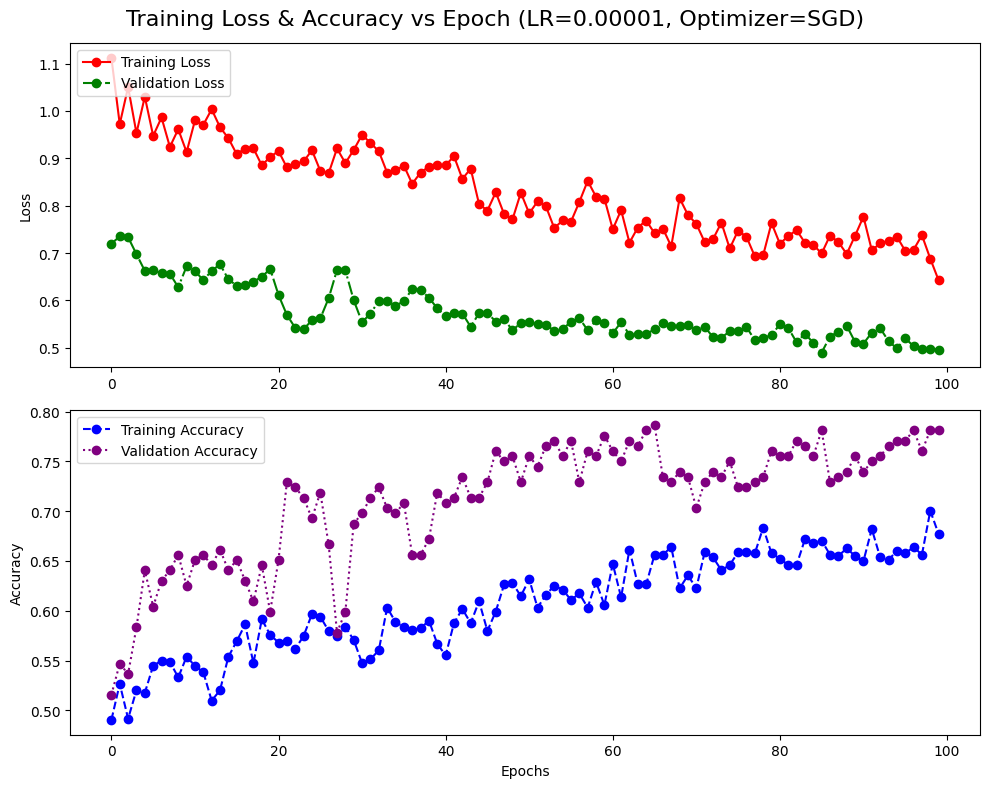

Entrenando con learning_rate=0.00001, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5538261997405967
Epoch 1 Training Loss = 0.9785853774321837
Epoch 1 Validation Accuracy = 0.7135416666666666
Epoch 1 Validation Loss = 0.5972790122032166
La mejor precisión de Validation Loss (0.5972790122032166) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6731517509727627
Epoch 2 Training Loss = 0.6762981121796733
Epoch 2 Validation Accuracy = 0.7708333333333334
Epoch 2 Validation Loss = 0.4902629256248474
La mejor precisión de Validation Loss (0.4902629256248474) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7354085603112841
Epoch 3 Training Loss = 0.606961227769827
Epoch 3 Validation Accuracy = 0.8229166666666666
Epoch 3 Validation Loss = 0.4227437476317088
La mejor precisión de Validation Loss (0.4227437476317088) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.8015564202334631
Epoch 4 Training Loss = 0.439122746890621
Epoch 4 Validation Accuracy = 0.8489583333333334
Epoch 4 Validation Loss = 0.36710191766421
La mejor precisión de Validation Loss (0.36710191766421) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.8028534370946823
Epoch 5 Training Loss = 0.42515114216489086
Epoch 5 Validation Accuracy = 0.875
Epoch 5 Validation Loss = 0.33353033661842346
La mejor precisión de Validation Loss (0.33353033661842346) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8586251621271076
Epoch 6 Training Loss = 0.3471314245412167
Epoch 6 Validation Accuracy = 0.875
Epoch 6 Validation Loss = 0.31627237300078076
La mejor precisión de Validation Loss (0.31627237300078076) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8651102464332037
Epoch 7 Training Loss = 0.319434269508963
Epoch 7 Validation Accuracy = 0.8854166666666666
Epoch 7 Validation Loss = 0.30302391449610394
La mejor precisión de Validation Loss (0.30302391449610394) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.880674448767834
Epoch 8 Training Loss = 0.2955173231593675
Epoch 8 Validation Accuracy = 0.8854166666666666
Epoch 8 Validation Loss = 0.296685129404068
La mejor precisión de Validation Loss (0.296685129404068) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9066147859922179
Epoch 9 Training Loss = 0.23811865966143775
Epoch 9 Validation Accuracy = 0.890625
Epoch 9 Validation Loss = 0.2954952319463094
La mejor precisión de Validation Loss (0.2954952319463094) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8754863813229572
Epoch 10 Training Loss = 0.27388706950207475
Epoch 10 Validation Accuracy = 0.8958333333333334
Epoch 10 Validation Loss = 0.27345206836859387
La mejor precisión de Validation Loss (0.27345206836859387) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.8949416342412452
Epoch 11 Training Loss = 0.24023104371109208
Epoch 11 Validation Accuracy = 0.8958333333333334
Epoch 11 Validation Loss = 0.2782801042000453
La mejor precisión de Validation Loss (0.27345206836859387) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9156939040207522
Epoch 12 Training Loss = 0.20902178429753246
Epoch 12 Validation Accuracy = 0.8802083333333334
Epoch 12 Validation Loss = 0.2805659770965576
La mejor precisión de Validation Loss (0.27345206836859387) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9390402075226978
Epoch 13 Training Loss = 0.1796081367198827
Epoch 13 Validation Accuracy = 0.8958333333333334
Epoch 13 Validation Loss = 0.2759525030851364
La mejor precisión de Validation Loss (0.27345206836859387) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9351491569390402
Epoch 14 Training Loss = 0.19640303680482388
Epoch 14 Validation Accuracy = 0.9010416666666666
Epoch 14 Validation Loss = 0.2629268517096837
La mejor precisión de Validation Loss (0.2629268517096837) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9390402075226978
Epoch 15 Training Loss = 0.1580831331192442
Epoch 15 Validation Accuracy = 0.8958333333333334
Epoch 15 Validation Loss = 0.26504137615362805
La mejor precisión de Validation Loss (0.2629268517096837) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9455252918287937
Epoch 16 Training Loss = 0.1569474649491168
Epoch 16 Validation Accuracy = 0.90625
Epoch 16 Validation Loss = 0.2626813401778539
La mejor precisión de Validation Loss (0.2626813401778539) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9584954604409858
Epoch 17 Training Loss = 0.13777783254086584
Epoch 17 Validation Accuracy = 0.90625
Epoch 17 Validation Loss = 0.25207003951072693
La mejor precisión de Validation Loss (0.25207003951072693) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9507133592736705
Epoch 18 Training Loss = 0.1359542911309367
Epoch 18 Validation Accuracy = 0.9010416666666666
Epoch 18 Validation Loss = 0.24844019611676535
La mejor precisión de Validation Loss (0.24844019611676535) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9546044098573282
Epoch 19 Training Loss = 0.13543591401920244
Epoch 19 Validation Accuracy = 0.8958333333333334
Epoch 19 Validation Loss = 0.28029385209083557
La mejor precisión de Validation Loss (0.24844019611676535) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9468223086900129
Epoch 20 Training Loss = 0.12409660680130144
Epoch 20 Validation Accuracy = 0.890625
Epoch 20 Validation Loss = 0.2758207668860753
La mejor precisión de Validation Loss (0.24844019611676535) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9610894941634242
Epoch 21 Training Loss = 0.10438381960729062
Epoch 21 Validation Accuracy = 0.8854166666666666
Epoch 21 Validation Loss = 0.2565078337987264
La mejor precisión de Validation Loss (0.24844019611676535) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9623865110246433
Epoch 22 Training Loss = 0.11109304058953791
Epoch 22 Validation Accuracy = 0.9010416666666666
Epoch 22 Validation Loss = 0.24747686088085175
La mejor precisión de Validation Loss (0.24747686088085175) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9571984435797666
Epoch 23 Training Loss = 0.11156397783493407
Epoch 23 Validation Accuracy = 0.9010416666666666
Epoch 23 Validation Loss = 0.24151317278544107
La mejor precisión de Validation Loss (0.24151317278544107) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9662775616083009
Epoch 24 Training Loss = 0.1063179931133483
Epoch 24 Validation Accuracy = 0.9010416666666666
Epoch 24 Validation Loss = 0.24438192943731943
La mejor precisión de Validation Loss (0.24151317278544107) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9559014267185474
Epoch 25 Training Loss = 0.11432294155218567
Epoch 25 Validation Accuracy = 0.90625
Epoch 25 Validation Loss = 0.2498175005118052
La mejor precisión de Validation Loss (0.24151317278544107) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9636835278858625
Epoch 26 Training Loss = 0.10886838278417921
Epoch 26 Validation Accuracy = 0.9166666666666666
Epoch 26 Validation Loss = 0.2434599349896113
La mejor precisión de Validation Loss (0.24151317278544107) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9779507133592736
Epoch 27 Training Loss = 0.08050911344984008
Epoch 27 Validation Accuracy = 0.921875
Epoch 27 Validation Loss = 0.2373709703485171
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9740596627756161
Epoch 28 Training Loss = 0.0906940867155597
Epoch 28 Validation Accuracy = 0.9166666666666666
Epoch 28 Validation Loss = 0.24145587285359701
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9675745784695201
Epoch 29 Training Loss = 0.09281185867528198
Epoch 29 Validation Accuracy = 0.9114583333333334
Epoch 29 Validation Loss = 0.25289547940095264
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9727626459143969
Epoch 30 Training Loss = 0.08885346405237102
Epoch 30 Validation Accuracy = 0.9114583333333334
Epoch 30 Validation Loss = 0.2639009704192479
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9688715953307393
Epoch 31 Training Loss = 0.08848478904552033
Epoch 31 Validation Accuracy = 0.90625
Epoch 31 Validation Loss = 0.2642162690560023
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9610894941634242
Epoch 32 Training Loss = 0.10238547864745717
Epoch 32 Validation Accuracy = 0.8958333333333334
Epoch 32 Validation Loss = 0.2729227642218272
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9714656290531777
Epoch 33 Training Loss = 0.10254578506900179
Epoch 33 Validation Accuracy = 0.890625
Epoch 33 Validation Loss = 0.2696581383546193
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9610894941634242
Epoch 34 Training Loss = 0.10245625762179514
Epoch 34 Validation Accuracy = 0.890625
Epoch 34 Validation Loss = 0.2549724876880646
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9727626459143969
Epoch 35 Training Loss = 0.09206107533240906
Epoch 35 Validation Accuracy = 0.8854166666666666
Epoch 35 Validation Loss = 0.26408739387989044
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9675745784695201
Epoch 36 Training Loss = 0.09565462968306164
Epoch 36 Validation Accuracy = 0.90625
Epoch 36 Validation Loss = 0.23962182303269705
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9571984435797666
Epoch 37 Training Loss = 0.09716038345981355
Epoch 37 Validation Accuracy = 0.9114583333333334
Epoch 37 Validation Loss = 0.2560303062200546
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9753566796368353
Epoch 38 Training Loss = 0.08517713328743723
Epoch 38 Validation Accuracy = 0.9010416666666666
Epoch 38 Validation Loss = 0.25252826511859894
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9753566796368353
Epoch 39 Training Loss = 0.07458073704777679
Epoch 39 Validation Accuracy = 0.9010416666666666
Epoch 39 Validation Loss = 0.2565988053878148
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9831387808041504
Epoch 40 Training Loss = 0.06310026175626367
Epoch 40 Validation Accuracy = 0.9166666666666666
Epoch 40 Validation Loss = 0.2530926565329234
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9831387808041504
Epoch 41 Training Loss = 0.06502899577800093
Epoch 41 Validation Accuracy = 0.90625
Epoch 41 Validation Loss = 0.2513902833064397
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.980544747081712
Epoch 42 Training Loss = 0.06384569861661599
Epoch 42 Validation Accuracy = 0.8958333333333334
Epoch 42 Validation Loss = 0.25907429059346515
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9714656290531777
Epoch 43 Training Loss = 0.07839969237577822
Epoch 43 Validation Accuracy = 0.9166666666666666
Epoch 43 Validation Loss = 0.2715076506137848
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9844357976653697
Epoch 44 Training Loss = 0.04942178142519158
Epoch 44 Validation Accuracy = 0.90625
Epoch 44 Validation Loss = 0.26735388735930127
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9831387808041504
Epoch 45 Training Loss = 0.061346018979212345
Epoch 45 Validation Accuracy = 0.90625
Epoch 45 Validation Loss = 0.26177603999773663
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9831387808041504
Epoch 46 Training Loss = 0.06979290797977905
Epoch 46 Validation Accuracy = 0.90625
Epoch 46 Validation Loss = 0.25939832131067914
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9883268482490273
Epoch 47 Training Loss = 0.05377708348396069
Epoch 47 Validation Accuracy = 0.9010416666666666
Epoch 47 Validation Loss = 0.2627158413330714
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9883268482490273
Epoch 48 Training Loss = 0.05223710434909924
Epoch 48 Validation Accuracy = 0.9010416666666666
Epoch 48 Validation Loss = 0.2800011883179347
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9896238651102465
Epoch 49 Training Loss = 0.043609958678368
Epoch 49 Validation Accuracy = 0.9114583333333334
Epoch 49 Validation Loss = 0.256421094139417
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9870298313878081
Epoch 50 Training Loss = 0.053648513617373314
Epoch 50 Validation Accuracy = 0.9114583333333334
Epoch 50 Validation Loss = 0.27228301266829175
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9818417639429312
Epoch 51 Training Loss = 0.0625587930629844
Epoch 51 Validation Accuracy = 0.9114583333333334
Epoch 51 Validation Loss = 0.2704504281282425
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9818417639429312
Epoch 52 Training Loss = 0.054212700300179564
Epoch 52 Validation Accuracy = 0.8958333333333334
Epoch 52 Validation Loss = 0.2771446406841278
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9922178988326849
Epoch 53 Training Loss = 0.0458515840552351
Epoch 53 Validation Accuracy = 0.9010416666666666
Epoch 53 Validation Loss = 0.2726939022541046
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9792477302204928
Epoch 54 Training Loss = 0.0610135764308786
Epoch 54 Validation Accuracy = 0.921875
Epoch 54 Validation Loss = 0.27308374643325806
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9753566796368353
Epoch 55 Training Loss = 0.0698528599027839
Epoch 55 Validation Accuracy = 0.9166666666666666
Epoch 55 Validation Loss = 0.2740938787659009
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9753566796368353
Epoch 56 Training Loss = 0.07729659802564233
Epoch 56 Validation Accuracy = 0.9114583333333334
Epoch 56 Validation Loss = 0.2921880781650543
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9753566796368353
Epoch 57 Training Loss = 0.07060331702425632
Epoch 57 Validation Accuracy = 0.90625
Epoch 57 Validation Loss = 0.2929578274488449
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9766536964980544
Epoch 58 Training Loss = 0.06883089533788375
Epoch 58 Validation Accuracy = 0.9166666666666666
Epoch 58 Validation Loss = 0.28642015159130096
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9857328145265889
Epoch 59 Training Loss = 0.05274786722354697
Epoch 59 Validation Accuracy = 0.90625
Epoch 59 Validation Loss = 0.2751946300268173
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9909208819714657
Epoch 60 Training Loss = 0.04297551605488076
Epoch 60 Validation Accuracy = 0.890625
Epoch 60 Validation Loss = 0.2866383542617162
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9870298313878081
Epoch 61 Training Loss = 0.054112687262425005
Epoch 61 Validation Accuracy = 0.9166666666666666
Epoch 61 Validation Loss = 0.28653093179066974
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9896238651102465
Epoch 62 Training Loss = 0.043214740533618456
Epoch 62 Validation Accuracy = 0.9166666666666666
Epoch 62 Validation Loss = 0.30256839096546173
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9831387808041504
Epoch 63 Training Loss = 0.045738561859236
Epoch 63 Validation Accuracy = 0.90625
Epoch 63 Validation Loss = 0.282304843266805
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9883268482490273
Epoch 64 Training Loss = 0.04857642846194068
Epoch 64 Validation Accuracy = 0.9114583333333334
Epoch 64 Validation Loss = 0.2835373381773631
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9870298313878081
Epoch 65 Training Loss = 0.04835333774680448
Epoch 65 Validation Accuracy = 0.9010416666666666
Epoch 65 Validation Loss = 0.2652192910512288
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9844357976653697
Epoch 66 Training Loss = 0.051110818542433774
Epoch 66 Validation Accuracy = 0.90625
Epoch 66 Validation Loss = 0.2643747975428899
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9870298313878081
Epoch 67 Training Loss = 0.042301429230260784
Epoch 67 Validation Accuracy = 0.890625
Epoch 67 Validation Loss = 0.2773646314938863
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9870298313878081
Epoch 68 Training Loss = 0.05224216724570778
Epoch 68 Validation Accuracy = 0.90625
Epoch 68 Validation Loss = 0.2607276936372121
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9857328145265889
Epoch 69 Training Loss = 0.05109130744804204
Epoch 69 Validation Accuracy = 0.9166666666666666
Epoch 69 Validation Loss = 0.26576807101567584
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9922178988326849
Epoch 70 Training Loss = 0.04356023850917198
Epoch 70 Validation Accuracy = 0.9114583333333334
Epoch 70 Validation Loss = 0.2792848199605942
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9818417639429312
Epoch 71 Training Loss = 0.0533211425275345
Epoch 71 Validation Accuracy = 0.921875
Epoch 71 Validation Loss = 0.24702312548955283
La mejor precisión de Validation Loss (0.2373709703485171) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9844357976653697
Epoch 72 Training Loss = 0.045492283333136416
Epoch 72 Validation Accuracy = 0.9270833333333334
Epoch 72 Validation Loss = 0.22654637694358826
La mejor precisión de Validation Loss (0.22654637694358826) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9870298313878081
Epoch 73 Training Loss = 0.04416289769026092
Epoch 73 Validation Accuracy = 0.921875
Epoch 73 Validation Loss = 0.2288583144545555
La mejor precisión de Validation Loss (0.22654637694358826) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9857328145265889
Epoch 74 Training Loss = 0.038122460458683755
Epoch 74 Validation Accuracy = 0.9114583333333334
Epoch 74 Validation Loss = 0.21895370880762735
La mejor precisión de Validation Loss (0.21895370880762735) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9870298313878081
Epoch 75 Training Loss = 0.04631567517375204
Epoch 75 Validation Accuracy = 0.9166666666666666
Epoch 75 Validation Loss = 0.22079515953858694
La mejor precisión de Validation Loss (0.21895370880762735) se alcanzó en la época 74


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9922178988326849
Epoch 76 Training Loss = 0.04818202858614396
Epoch 76 Validation Accuracy = 0.9270833333333334
Epoch 76 Validation Loss = 0.2036118060350418
La mejor precisión de Validation Loss (0.2036118060350418) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9883268482490273
Epoch 77 Training Loss = 0.042058617649684465
Epoch 77 Validation Accuracy = 0.921875
Epoch 77 Validation Loss = 0.192565456032753
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.980544747081712
Epoch 78 Training Loss = 0.048863411819424614
Epoch 78 Validation Accuracy = 0.9322916666666666
Epoch 78 Validation Loss = 0.21351844569047293
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9883268482490273
Epoch 79 Training Loss = 0.037011498220545155
Epoch 79 Validation Accuracy = 0.921875
Epoch 79 Validation Loss = 0.24502959350744882
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9909208819714657
Epoch 80 Training Loss = 0.03680277311384446
Epoch 80 Validation Accuracy = 0.921875
Epoch 80 Validation Loss = 0.26562343041102093
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9896238651102465
Epoch 81 Training Loss = 0.04167082237053165
Epoch 81 Validation Accuracy = 0.921875
Epoch 81 Validation Loss = 0.2492132931947708
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9883268482490273
Epoch 82 Training Loss = 0.03976866003758867
Epoch 82 Validation Accuracy = 0.9166666666666666
Epoch 82 Validation Loss = 0.2392705778280894
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9909208819714657
Epoch 83 Training Loss = 0.04031649943146415
Epoch 83 Validation Accuracy = 0.9166666666666666
Epoch 83 Validation Loss = 0.23250423868497214
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9961089494163424
Epoch 84 Training Loss = 0.030591480984762023
Epoch 84 Validation Accuracy = 0.9114583333333334
Epoch 84 Validation Loss = 0.2212452838818232
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.993514915693904
Epoch 85 Training Loss = 0.03069238651703304
Epoch 85 Validation Accuracy = 0.9270833333333334
Epoch 85 Validation Loss = 0.2240404710173607
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9922178988326849
Epoch 86 Training Loss = 0.03257310262913834
Epoch 86 Validation Accuracy = 0.9270833333333334
Epoch 86 Validation Loss = 0.21787193417549133
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.993514915693904
Epoch 87 Training Loss = 0.028381028566533646
Epoch 87 Validation Accuracy = 0.9166666666666666
Epoch 87 Validation Loss = 0.21686815718809763
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9883268482490273
Epoch 88 Training Loss = 0.03183015604079466
Epoch 88 Validation Accuracy = 0.9270833333333334
Epoch 88 Validation Loss = 0.20960302154223123
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9909208819714657
Epoch 89 Training Loss = 0.040240265689935203
Epoch 89 Validation Accuracy = 0.9166666666666666
Epoch 89 Validation Loss = 0.22160721321900687
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9883268482490273
Epoch 90 Training Loss = 0.04476665862957946
Epoch 90 Validation Accuracy = 0.9114583333333334
Epoch 90 Validation Loss = 0.22737505783637366
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9883268482490273
Epoch 91 Training Loss = 0.04212477284298797
Epoch 91 Validation Accuracy = 0.9166666666666666
Epoch 91 Validation Loss = 0.21400303641955057
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9909208819714657
Epoch 92 Training Loss = 0.033069229379161014
Epoch 92 Validation Accuracy = 0.9114583333333334
Epoch 92 Validation Loss = 0.23083722591400146
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9844357976653697
Epoch 93 Training Loss = 0.0416485335189854
Epoch 93 Validation Accuracy = 0.9375
Epoch 93 Validation Loss = 0.21593346695105234
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9896238651102465
Epoch 94 Training Loss = 0.03848242983898455
Epoch 94 Validation Accuracy = 0.9322916666666666
Epoch 94 Validation Loss = 0.20871113737424216
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9870298313878081
Epoch 95 Training Loss = 0.04431794133477019
Epoch 95 Validation Accuracy = 0.9322916666666666
Epoch 95 Validation Loss = 0.20637688537438711
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9909208819714657
Epoch 96 Training Loss = 0.0407259560174438
Epoch 96 Validation Accuracy = 0.9270833333333334
Epoch 96 Validation Loss = 0.23222492635250092
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9844357976653697
Epoch 97 Training Loss = 0.04820155633562734
Epoch 97 Validation Accuracy = 0.9166666666666666
Epoch 97 Validation Loss = 0.2319942315419515
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.980544747081712
Epoch 98 Training Loss = 0.05592888377210664
Epoch 98 Validation Accuracy = 0.9322916666666666
Epoch 98 Validation Loss = 0.23506305118401846
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9870298313878081
Epoch 99 Training Loss = 0.04560612062845094
Epoch 99 Validation Accuracy = 0.9166666666666666
Epoch 99 Validation Loss = 0.22529707352320352
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9909208819714657
Epoch 100 Training Loss = 0.04152349932493712
Epoch 100 Validation Accuracy = 0.921875
Epoch 100 Validation Loss = 0.22643255442380905
La mejor precisión de Validation Loss (0.192565456032753) se alcanzó en la época 77


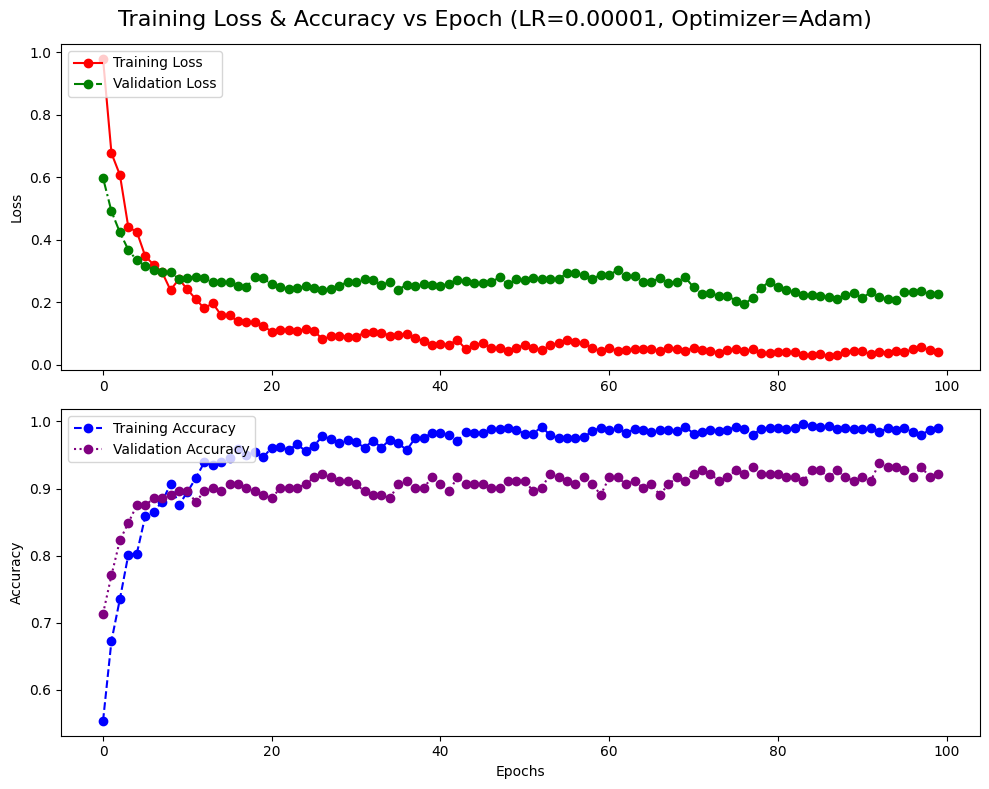

Entrenando con learning_rate=0.00001, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.6277561608300908
Epoch 1 Training Loss = 0.8075098447144109
Epoch 1 Validation Accuracy = 0.7552083333333334
Epoch 1 Validation Loss = 0.5078077713648478
La mejor precisión de Validation Loss (0.5078077713648478) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.8067444876783398
Epoch 2 Training Loss = 0.432638811346158
Epoch 2 Validation Accuracy = 0.8229166666666666
Epoch 2 Validation Loss = 0.4004322290420532
La mejor precisión de Validation Loss (0.4004322290420532) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.8469520103761349
Epoch 3 Training Loss = 0.33522424811132534
Epoch 3 Validation Accuracy = 0.8645833333333334
Epoch 3 Validation Loss = 0.36024584372838336
La mejor precisión de Validation Loss (0.36024584372838336) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.9105058365758755
Epoch 4 Training Loss = 0.2345806249307442
Epoch 4 Validation Accuracy = 0.8541666666666666
Epoch 4 Validation Loss = 0.30005427201588947
La mejor precisión de Validation Loss (0.30005427201588947) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.914396887159533
Epoch 5 Training Loss = 0.2069615693485072
Epoch 5 Validation Accuracy = 0.8697916666666666
Epoch 5 Validation Loss = 0.29557593663533527
La mejor precisión de Validation Loss (0.29557593663533527) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9377431906614786
Epoch 6 Training Loss = 0.17561847211167353
Epoch 6 Validation Accuracy = 0.875
Epoch 6 Validation Loss = 0.2775862415631612
La mejor precisión de Validation Loss (0.2775862415631612) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9273670557717251
Epoch 7 Training Loss = 0.1654191104509178
Epoch 7 Validation Accuracy = 0.8697916666666666
Epoch 7 Validation Loss = 0.27008211115996045
La mejor precisión de Validation Loss (0.27008211115996045) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9429312581063554
Epoch 8 Training Loss = 0.14523996445610057
Epoch 8 Validation Accuracy = 0.8697916666666666
Epoch 8 Validation Loss = 0.31584098438421887
La mejor precisión de Validation Loss (0.27008211115996045) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9429312581063554
Epoch 9 Training Loss = 0.14687505120897107
Epoch 9 Validation Accuracy = 0.875
Epoch 9 Validation Loss = 0.29280877113342285
La mejor precisión de Validation Loss (0.27008211115996045) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9455252918287937
Epoch 10 Training Loss = 0.13860008255826206
Epoch 10 Validation Accuracy = 0.8854166666666666
Epoch 10 Validation Loss = 0.3151157349348068
La mejor precisión de Validation Loss (0.27008211115996045) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9416342412451362
Epoch 11 Training Loss = 0.15327698061902237
Epoch 11 Validation Accuracy = 0.8958333333333334
Epoch 11 Validation Loss = 0.2578171988328298
La mejor precisión de Validation Loss (0.2578171988328298) se alcanzó en la época 11


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9546044098573282
Epoch 12 Training Loss = 0.11854479238680829
Epoch 12 Validation Accuracy = 0.9114583333333334
Epoch 12 Validation Loss = 0.242416982849439
La mejor precisión de Validation Loss (0.242416982849439) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9662775616083009
Epoch 13 Training Loss = 0.11377970476172158
Epoch 13 Validation Accuracy = 0.9010416666666666
Epoch 13 Validation Loss = 0.23376603921254477
La mejor precisión de Validation Loss (0.23376603921254477) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9610894941634242
Epoch 14 Training Loss = 0.10329710436083772
Epoch 14 Validation Accuracy = 0.90625
Epoch 14 Validation Loss = 0.22146842877070108
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9818417639429312
Epoch 15 Training Loss = 0.07982274282593207
Epoch 15 Validation Accuracy = 0.8958333333333334
Epoch 15 Validation Loss = 0.2335519144932429
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9571984435797666
Epoch 16 Training Loss = 0.10901474218269576
Epoch 16 Validation Accuracy = 0.8802083333333334
Epoch 16 Validation Loss = 0.28376534581184387
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9714656290531777
Epoch 17 Training Loss = 0.08063800804964454
Epoch 17 Validation Accuracy = 0.8958333333333334
Epoch 17 Validation Loss = 0.2569599648316701
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9831387808041504
Epoch 18 Training Loss = 0.06397467538540465
Epoch 18 Validation Accuracy = 0.90625
Epoch 18 Validation Loss = 0.23690023521582285
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9818417639429312
Epoch 19 Training Loss = 0.05843343739379705
Epoch 19 Validation Accuracy = 0.9166666666666666
Epoch 19 Validation Loss = 0.24489382902781168
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9792477302204928
Epoch 20 Training Loss = 0.06877895876591307
Epoch 20 Validation Accuracy = 0.90625
Epoch 20 Validation Loss = 0.262480229139328
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9701686121919585
Epoch 21 Training Loss = 0.08368179770295259
Epoch 21 Validation Accuracy = 0.9010416666666666
Epoch 21 Validation Loss = 0.2534823815027873
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9766536964980544
Epoch 22 Training Loss = 0.07608244066572376
Epoch 22 Validation Accuracy = 0.8958333333333334
Epoch 22 Validation Loss = 0.26849062740802765
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9779507133592736
Epoch 23 Training Loss = 0.07143016377930202
Epoch 23 Validation Accuracy = 0.90625
Epoch 23 Validation Loss = 0.26064720501502353
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9844357976653697
Epoch 24 Training Loss = 0.054471505310594186
Epoch 24 Validation Accuracy = 0.8958333333333334
Epoch 24 Validation Loss = 0.2604765345652898
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9831387808041504
Epoch 25 Training Loss = 0.05510231255325362
Epoch 25 Validation Accuracy = 0.90625
Epoch 25 Validation Loss = 0.25930918256441754
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9831387808041504
Epoch 26 Training Loss = 0.0562936404838327
Epoch 26 Validation Accuracy = 0.9114583333333334
Epoch 26 Validation Loss = 0.2613225132226944
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9922178988326849
Epoch 27 Training Loss = 0.040254982528983387
Epoch 27 Validation Accuracy = 0.90625
Epoch 27 Validation Loss = 0.26352958381175995
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9883268482490273
Epoch 28 Training Loss = 0.03985911638665601
Epoch 28 Validation Accuracy = 0.921875
Epoch 28 Validation Loss = 0.23011542856693268
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9883268482490273
Epoch 29 Training Loss = 0.03872054351442983
Epoch 29 Validation Accuracy = 0.90625
Epoch 29 Validation Loss = 0.23235135277112326
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9844357976653697
Epoch 30 Training Loss = 0.04694353366794908
Epoch 30 Validation Accuracy = 0.90625
Epoch 30 Validation Loss = 0.2575486997763316
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9844357976653697
Epoch 31 Training Loss = 0.04699533999971224
Epoch 31 Validation Accuracy = 0.9114583333333334
Epoch 31 Validation Loss = 0.24615673224131265
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9909208819714657
Epoch 32 Training Loss = 0.04011947631681321
Epoch 32 Validation Accuracy = 0.9166666666666666
Epoch 32 Validation Loss = 0.28906585772832233
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9922178988326849
Epoch 33 Training Loss = 0.03712818231409471
Epoch 33 Validation Accuracy = 0.9166666666666666
Epoch 33 Validation Loss = 0.26104914645353955
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9896238651102465
Epoch 34 Training Loss = 0.039558083476104934
Epoch 34 Validation Accuracy = 0.921875
Epoch 34 Validation Loss = 0.2478204866250356
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9870298313878081
Epoch 35 Training Loss = 0.03650282675596063
Epoch 35 Validation Accuracy = 0.921875
Epoch 35 Validation Loss = 0.22535163909196854
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9896238651102465
Epoch 36 Training Loss = 0.03792696265955534
Epoch 36 Validation Accuracy = 0.921875
Epoch 36 Validation Loss = 0.23082605004310608
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9896238651102465
Epoch 37 Training Loss = 0.03176216454512105
Epoch 37 Validation Accuracy = 0.9166666666666666
Epoch 37 Validation Loss = 0.23765528202056885
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9922178988326849
Epoch 38 Training Loss = 0.03397217392921448
Epoch 38 Validation Accuracy = 0.9166666666666666
Epoch 38 Validation Loss = 0.26232768098513287
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9987029831387808
Epoch 39 Training Loss = 0.023923331004327066
Epoch 39 Validation Accuracy = 0.9166666666666666
Epoch 39 Validation Loss = 0.2517995238304138
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9948119325551232
Epoch 40 Training Loss = 0.023746342626527125
Epoch 40 Validation Accuracy = 0.90625
Epoch 40 Validation Loss = 0.2596527462204297
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9922178988326849
Epoch 41 Training Loss = 0.027987597440158038
Epoch 41 Validation Accuracy = 0.9166666666666666
Epoch 41 Validation Loss = 0.2537489980459213
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9987029831387808
Epoch 42 Training Loss = 0.020618582634803696
Epoch 42 Validation Accuracy = 0.9166666666666666
Epoch 42 Validation Loss = 0.24757795532544455
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9909208819714657
Epoch 43 Training Loss = 0.027956656676785954
Epoch 43 Validation Accuracy = 0.90625
Epoch 43 Validation Loss = 0.2631569057703018
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9922178988326849
Epoch 44 Training Loss = 0.026873216438850076
Epoch 44 Validation Accuracy = 0.9010416666666666
Epoch 44 Validation Loss = 0.273567075530688
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9870298313878081
Epoch 45 Training Loss = 0.03378639773172163
Epoch 45 Validation Accuracy = 0.8958333333333334
Epoch 45 Validation Loss = 0.301225225130717
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9896238651102465
Epoch 46 Training Loss = 0.03661064059508604
Epoch 46 Validation Accuracy = 0.90625
Epoch 46 Validation Loss = 0.26536984741687775
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9948119325551232
Epoch 47 Training Loss = 0.022788742946125037
Epoch 47 Validation Accuracy = 0.890625
Epoch 47 Validation Loss = 0.2695818841457367
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9831387808041504
Epoch 48 Training Loss = 0.04382357438096122
Epoch 48 Validation Accuracy = 0.90625
Epoch 48 Validation Loss = 0.2645168751478195
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9883268482490273
Epoch 49 Training Loss = 0.03879868705912787
Epoch 49 Validation Accuracy = 0.9114583333333334
Epoch 49 Validation Loss = 0.28411291042963666
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9922178988326849
Epoch 50 Training Loss = 0.03201748026793414
Epoch 50 Validation Accuracy = 0.8958333333333334
Epoch 50 Validation Loss = 0.2719256579875946
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.993514915693904
Epoch 51 Training Loss = 0.03002276189441656
Epoch 51 Validation Accuracy = 0.921875
Epoch 51 Validation Loss = 0.2664257238308589
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9922178988326849
Epoch 52 Training Loss = 0.026818714948943615
Epoch 52 Validation Accuracy = 0.9166666666666666
Epoch 52 Validation Loss = 0.2876920352379481
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9987029831387808
Epoch 53 Training Loss = 0.021629375783695167
Epoch 53 Validation Accuracy = 0.9114583333333334
Epoch 53 Validation Loss = 0.27817238370577496
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9922178988326849
Epoch 54 Training Loss = 0.027574769881990015
Epoch 54 Validation Accuracy = 0.921875
Epoch 54 Validation Loss = 0.27542802691459656
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9948119325551232
Epoch 55 Training Loss = 0.02578780275374535
Epoch 55 Validation Accuracy = 0.8958333333333334
Epoch 55 Validation Loss = 0.28873617947101593
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9948119325551232
Epoch 56 Training Loss = 0.027476435814695443
Epoch 56 Validation Accuracy = 0.890625
Epoch 56 Validation Loss = 0.26201237241427106
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9922178988326849
Epoch 57 Training Loss = 0.02597417519095652
Epoch 57 Validation Accuracy = 0.9166666666666666
Epoch 57 Validation Loss = 0.2908225953578949
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9922178988326849
Epoch 58 Training Loss = 0.0291559998376051
Epoch 58 Validation Accuracy = 0.9114583333333334
Epoch 58 Validation Loss = 0.28090644379456836
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9909208819714657
Epoch 59 Training Loss = 0.027423670976851545
Epoch 59 Validation Accuracy = 0.9114583333333334
Epoch 59 Validation Loss = 0.27973276873429614
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9922178988326849
Epoch 60 Training Loss = 0.026198741449610888
Epoch 60 Validation Accuracy = 0.9114583333333334
Epoch 60 Validation Loss = 0.31238462527592975
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.993514915693904
Epoch 61 Training Loss = 0.022650879528735863
Epoch 61 Validation Accuracy = 0.9114583333333334
Epoch 61 Validation Loss = 0.28688671191533405
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9948119325551232
Epoch 62 Training Loss = 0.025267857869775378
Epoch 62 Validation Accuracy = 0.9322916666666666
Epoch 62 Validation Loss = 0.2917768309513728
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.993514915693904
Epoch 63 Training Loss = 0.020128470199272018
Epoch 63 Validation Accuracy = 0.9166666666666666
Epoch 63 Validation Loss = 0.2891352375348409
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9987029831387808
Epoch 64 Training Loss = 0.015955758697791787
Epoch 64 Validation Accuracy = 0.9114583333333334
Epoch 64 Validation Loss = 0.26719050606091815
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9896238651102465
Epoch 65 Training Loss = 0.02690554494291892
Epoch 65 Validation Accuracy = 0.9166666666666666
Epoch 65 Validation Loss = 0.2683996061484019
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9922178988326849
Epoch 66 Training Loss = 0.021848127767733563
Epoch 66 Validation Accuracy = 0.90625
Epoch 66 Validation Loss = 0.29582195977369946
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9961089494163424
Epoch 67 Training Loss = 0.017862512559742316
Epoch 67 Validation Accuracy = 0.90625
Epoch 67 Validation Loss = 0.2851384182771047
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 1.0
Epoch 68 Training Loss = 0.016763150537369625
Epoch 68 Validation Accuracy = 0.9114583333333334
Epoch 68 Validation Loss = 0.28227197130521137
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9974059662775616
Epoch 69 Training Loss = 0.01514015046229777
Epoch 69 Validation Accuracy = 0.9166666666666666
Epoch 69 Validation Loss = 0.3342103064060211
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9961089494163424
Epoch 70 Training Loss = 0.023259315702547204
Epoch 70 Validation Accuracy = 0.8958333333333334
Epoch 70 Validation Loss = 0.3118009368578593
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9961089494163424
Epoch 71 Training Loss = 0.016920499030099612
Epoch 71 Validation Accuracy = 0.9114583333333334
Epoch 71 Validation Loss = 0.31723491350809735
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9974059662775616
Epoch 72 Training Loss = 0.015597030926307352
Epoch 72 Validation Accuracy = 0.9166666666666666
Epoch 72 Validation Loss = 0.2828787292043368
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9922178988326849
Epoch 73 Training Loss = 0.023088836179980973
Epoch 73 Validation Accuracy = 0.921875
Epoch 73 Validation Loss = 0.2762889564037323
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9961089494163424
Epoch 74 Training Loss = 0.018250753018333444
Epoch 74 Validation Accuracy = 0.90625
Epoch 74 Validation Loss = 0.30764572819073993
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9948119325551232
Epoch 75 Training Loss = 0.019491695553721468
Epoch 75 Validation Accuracy = 0.9166666666666666
Epoch 75 Validation Loss = 0.27751755714416504
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9961089494163424
Epoch 76 Training Loss = 0.016029864109946286
Epoch 76 Validation Accuracy = 0.9270833333333334
Epoch 76 Validation Loss = 0.26656531418363255
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.993514915693904
Epoch 77 Training Loss = 0.018437063724923534
Epoch 77 Validation Accuracy = 0.921875
Epoch 77 Validation Loss = 0.2813101013501485
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 1.0
Epoch 78 Training Loss = 0.011319420998614044
Epoch 78 Validation Accuracy = 0.921875
Epoch 78 Validation Loss = 0.2714331845442454
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9974059662775616
Epoch 79 Training Loss = 0.016478054380061252
Epoch 79 Validation Accuracy = 0.921875
Epoch 79 Validation Loss = 0.2625099966923396
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.993514915693904
Epoch 80 Training Loss = 0.019896863112962973
Epoch 80 Validation Accuracy = 0.9166666666666666
Epoch 80 Validation Loss = 0.2770016888777415
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 1.0
Epoch 81 Training Loss = 0.012186127414035425
Epoch 81 Validation Accuracy = 0.9270833333333334
Epoch 81 Validation Loss = 0.25412479043006897
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9987029831387808
Epoch 82 Training Loss = 0.013567246999180889
Epoch 82 Validation Accuracy = 0.921875
Epoch 82 Validation Loss = 0.257662758231163
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9961089494163424
Epoch 83 Training Loss = 0.013553240381171576
Epoch 83 Validation Accuracy = 0.90625
Epoch 83 Validation Loss = 0.293130099773407
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9974059662775616
Epoch 84 Training Loss = 0.014440093387580259
Epoch 84 Validation Accuracy = 0.9166666666666666
Epoch 84 Validation Loss = 0.28924394647280377
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9961089494163424
Epoch 85 Training Loss = 0.014278942774667196
Epoch 85 Validation Accuracy = 0.9375
Epoch 85 Validation Loss = 0.27971377472082776
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9987029831387808
Epoch 86 Training Loss = 0.016333478364015986
Epoch 86 Validation Accuracy = 0.9375
Epoch 86 Validation Loss = 0.260394811630249
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.993514915693904
Epoch 87 Training Loss = 0.017775996630448467
Epoch 87 Validation Accuracy = 0.921875
Epoch 87 Validation Loss = 0.26341832304994267
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9922178988326849
Epoch 88 Training Loss = 0.019955204270693114
Epoch 88 Validation Accuracy = 0.9322916666666666
Epoch 88 Validation Loss = 0.2652057905991872
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.993514915693904
Epoch 89 Training Loss = 0.021517198943519715
Epoch 89 Validation Accuracy = 0.9375
Epoch 89 Validation Loss = 0.24191692471504211
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9961089494163424
Epoch 90 Training Loss = 0.020523116997553062
Epoch 90 Validation Accuracy = 0.9375
Epoch 90 Validation Loss = 0.2334318310022354
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9922178988326849
Epoch 91 Training Loss = 0.02165363444892349
Epoch 91 Validation Accuracy = 0.9427083333333334
Epoch 91 Validation Loss = 0.24387111763159433
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9961089494163424
Epoch 92 Training Loss = 0.024081990973185627
Epoch 92 Validation Accuracy = 0.921875
Epoch 92 Validation Loss = 0.2885857621828715
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9987029831387808
Epoch 93 Training Loss = 0.01254778147594165
Epoch 93 Validation Accuracy = 0.9375
Epoch 93 Validation Loss = 0.2325100600719452
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9896238651102465
Epoch 94 Training Loss = 0.02217141818134392
Epoch 94 Validation Accuracy = 0.9114583333333334
Epoch 94 Validation Loss = 0.3172132968902588
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9987029831387808
Epoch 95 Training Loss = 0.013568461695069933
Epoch 95 Validation Accuracy = 0.9270833333333334
Epoch 95 Validation Loss = 0.26527297000090283
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9987029831387808
Epoch 96 Training Loss = 0.011260346486565358
Epoch 96 Validation Accuracy = 0.9270833333333334
Epoch 96 Validation Loss = 0.2841411530971527
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9948119325551232
Epoch 97 Training Loss = 0.020498201801851103
Epoch 97 Validation Accuracy = 0.9375
Epoch 97 Validation Loss = 0.2556655953327815
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9909208819714657
Epoch 98 Training Loss = 0.019301206975131647
Epoch 98 Validation Accuracy = 0.9375
Epoch 98 Validation Loss = 0.24249454836050668
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9987029831387808
Epoch 99 Training Loss = 0.014371211542693557
Epoch 99 Validation Accuracy = 0.9427083333333334
Epoch 99 Validation Loss = 0.23792923986911774
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9909208819714657
Epoch 100 Training Loss = 0.02737823990687013
Epoch 100 Validation Accuracy = 0.921875
Epoch 100 Validation Loss = 0.2761915574471156
La mejor precisión de Validation Loss (0.22146842877070108) se alcanzó en la época 14


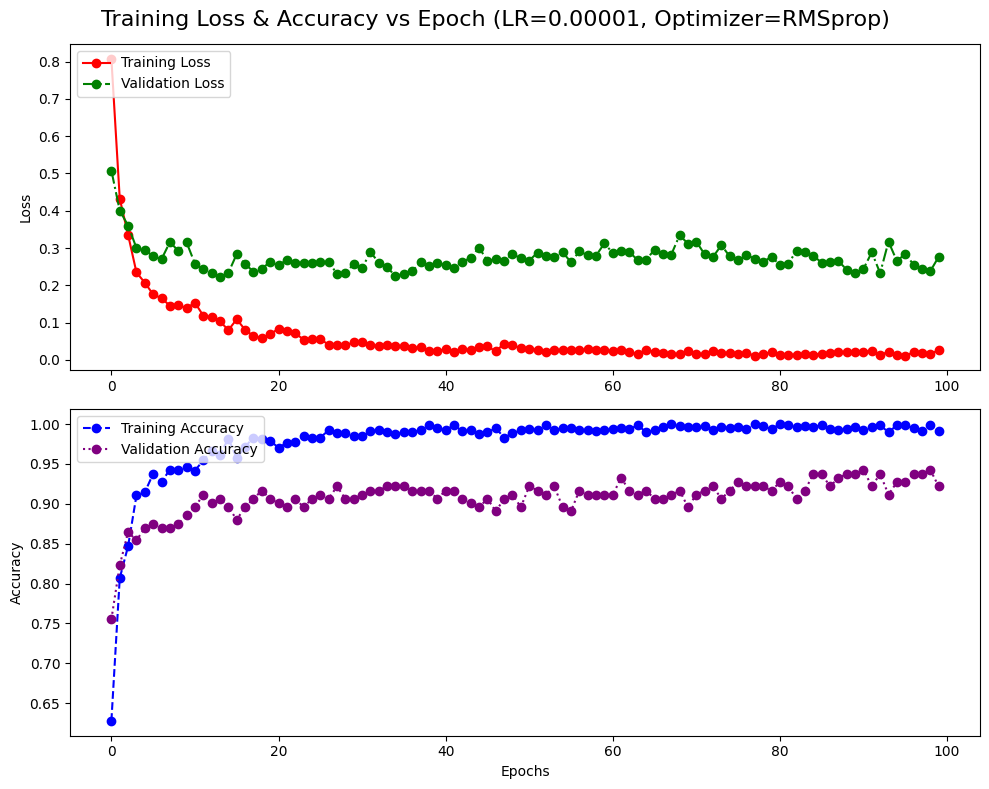

Entrenando con learning_rate=0.00010, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.4669260700389105
Epoch 1 Training Loss = 1.1250503138190886
Epoch 1 Validation Accuracy = 0.5
Epoch 1 Validation Loss = 0.7206806341807047
La mejor precisión de Validation Loss (0.7206806341807047) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.5486381322957199
Epoch 2 Training Loss = 0.9491653646476538
Epoch 2 Validation Accuracy = 0.5520833333333334
Epoch 2 Validation Loss = 0.734512448310852
La mejor precisión de Validation Loss (0.7206806341807047) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5330739299610895
Epoch 3 Training Loss = 0.9550908974791006
Epoch 3 Validation Accuracy = 0.5364583333333334
Epoch 3 Validation Loss = 0.8787587881088257
La mejor precisión de Validation Loss (0.7206806341807047) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5097276264591439
Epoch 4 Training Loss = 1.0420657734153491
Epoch 4 Validation Accuracy = 0.578125
Epoch 4 Validation Loss = 0.7419149279594421
La mejor precisión de Validation Loss (0.7206806341807047) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5369649805447471
Epoch 5 Training Loss = 0.9923676529901655
Epoch 5 Validation Accuracy = 0.578125
Epoch 5 Validation Loss = 0.806423286596934
La mejor precisión de Validation Loss (0.7206806341807047) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5654993514915694
Epoch 6 Training Loss = 0.9275898577792789
Epoch 6 Validation Accuracy = 0.6510416666666666
Epoch 6 Validation Loss = 0.7205954392751058
La mejor precisión de Validation Loss (0.7205954392751058) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5590142671854734
Epoch 7 Training Loss = 0.937150967917399
Epoch 7 Validation Accuracy = 0.5
Epoch 7 Validation Loss = 1.2290072043736775
La mejor precisión de Validation Loss (0.7205954392751058) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5616083009079118
Epoch 8 Training Loss = 0.9815533120189969
Epoch 8 Validation Accuracy = 0.640625
Epoch 8 Validation Loss = 0.8082768718401591
La mejor precisión de Validation Loss (0.7205954392751058) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5317769130998703
Epoch 9 Training Loss = 0.9577510307425809
Epoch 9 Validation Accuracy = 0.6666666666666666
Epoch 9 Validation Loss = 0.7317903240521749
La mejor precisión de Validation Loss (0.7205954392751058) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5278858625162127
Epoch 10 Training Loss = 0.9780367700970126
Epoch 10 Validation Accuracy = 0.6979166666666666
Epoch 10 Validation Loss = 0.6579241156578064
La mejor precisión de Validation Loss (0.6579241156578064) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.6277561608300908
Epoch 11 Training Loss = 0.825926684084724
Epoch 11 Validation Accuracy = 0.6197916666666666
Epoch 11 Validation Loss = 0.7230515281359354
La mejor precisión de Validation Loss (0.6579241156578064) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5797665369649806
Epoch 12 Training Loss = 0.8995230312322674
Epoch 12 Validation Accuracy = 0.6927083333333334
Epoch 12 Validation Loss = 0.6517193714777628
La mejor precisión de Validation Loss (0.6517193714777628) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.6121919584954605
Epoch 13 Training Loss = 0.877765093718676
Epoch 13 Validation Accuracy = 0.6875
Epoch 13 Validation Loss = 0.6432551344235738
La mejor precisión de Validation Loss (0.6432551344235738) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.6186770428015564
Epoch 14 Training Loss = 0.8204726022891652
Epoch 14 Validation Accuracy = 0.734375
Epoch 14 Validation Loss = 0.5366049408912659
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.6277561608300908
Epoch 15 Training Loss = 0.792526195717229
Epoch 15 Validation Accuracy = 0.7395833333333334
Epoch 15 Validation Loss = 0.6770279407501221
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.6303501945525292
Epoch 16 Training Loss = 0.8003636471028458
Epoch 16 Validation Accuracy = 0.6927083333333334
Epoch 16 Validation Loss = 0.8615845044453939
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.6303501945525292
Epoch 17 Training Loss = 0.8490020666759457
Epoch 17 Validation Accuracy = 0.5885416666666666
Epoch 17 Validation Loss = 1.4248038132985432
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.5966277561608301
Epoch 18 Training Loss = 0.870667369101298
Epoch 18 Validation Accuracy = 0.6666666666666666
Epoch 18 Validation Loss = 0.7780004342397054
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.6303501945525292
Epoch 19 Training Loss = 0.8317733421709133
Epoch 19 Validation Accuracy = 0.6510416666666666
Epoch 19 Validation Loss = 0.6886552174886068
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.5706874189364461
Epoch 20 Training Loss = 0.8481110634352292
Epoch 20 Validation Accuracy = 0.59375
Epoch 20 Validation Loss = 0.9562361637751261
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5927367055771725
Epoch 21 Training Loss = 0.8515131523018526
Epoch 21 Validation Accuracy = 0.6927083333333334
Epoch 21 Validation Loss = 0.6097029248873392
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.6083009079118028
Epoch 22 Training Loss = 0.8310941565206852
Epoch 22 Validation Accuracy = 0.5364583333333334
Epoch 22 Validation Loss = 0.872035543123881
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.5265888456549935
Epoch 23 Training Loss = 0.9556236460746959
Epoch 23 Validation Accuracy = 0.578125
Epoch 23 Validation Loss = 0.7137189706166586
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.5304798962386511
Epoch 24 Training Loss = 0.9820461042041754
Epoch 24 Validation Accuracy = 0.5572916666666666
Epoch 24 Validation Loss = 0.7050597667694092
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.5499351491569391
Epoch 25 Training Loss = 0.9029491459117326
Epoch 25 Validation Accuracy = 0.6510416666666666
Epoch 25 Validation Loss = 0.6605597337086996
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5291828793774319
Epoch 26 Training Loss = 0.8943852270468973
Epoch 26 Validation Accuracy = 0.53125
Epoch 26 Validation Loss = 0.8753376007080078
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.5460440985732814
Epoch 27 Training Loss = 0.9270929575507588
Epoch 27 Validation Accuracy = 0.4635416666666667
Epoch 27 Validation Loss = 0.7980144222577413
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5460440985732814
Epoch 28 Training Loss = 0.9186999842659818
Epoch 28 Validation Accuracy = 0.5
Epoch 28 Validation Loss = 0.782296895980835
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.5097276264591439
Epoch 29 Training Loss = 0.8970226625369526
Epoch 29 Validation Accuracy = 0.6302083333333334
Epoch 29 Validation Loss = 0.7203008532524109
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.5447470817120622
Epoch 30 Training Loss = 0.9120251814292408
Epoch 30 Validation Accuracy = 0.625
Epoch 30 Validation Loss = 0.6917128364245096
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.5239948119325551
Epoch 31 Training Loss = 0.8821866077826336
Epoch 31 Validation Accuracy = 0.5208333333333334
Epoch 31 Validation Loss = 0.8072784741719564
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.5097276264591439
Epoch 32 Training Loss = 0.8877836962154403
Epoch 32 Validation Accuracy = 0.5833333333333334
Epoch 32 Validation Loss = 0.7500943342844645
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.5330739299610895
Epoch 33 Training Loss = 0.9254039768733557
Epoch 33 Validation Accuracy = 0.5572916666666666
Epoch 33 Validation Loss = 0.8007387320200602
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.5291828793774319
Epoch 34 Training Loss = 0.9163391729273221
Epoch 34 Validation Accuracy = 0.5208333333333334
Epoch 34 Validation Loss = 0.9420292774836222
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.49546044098573283
Epoch 35 Training Loss = 0.9895088593783545
Epoch 35 Validation Accuracy = 0.6145833333333334
Epoch 35 Validation Loss = 0.7980364362398783
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.5382619974059663
Epoch 36 Training Loss = 0.9152014334378076
Epoch 36 Validation Accuracy = 0.625
Epoch 36 Validation Loss = 0.7634199659029642
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.5577172503242542
Epoch 37 Training Loss = 0.8760756051262065
Epoch 37 Validation Accuracy = 0.6354166666666666
Epoch 37 Validation Loss = 0.6397830049196879
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.556420233463035
Epoch 38 Training Loss = 0.8693023947890167
Epoch 38 Validation Accuracy = 0.6666666666666666
Epoch 38 Validation Loss = 0.6363581418991089
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.5616083009079118
Epoch 39 Training Loss = 0.8867622869024017
Epoch 39 Validation Accuracy = 0.671875
Epoch 39 Validation Loss = 0.6154851714769999
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.5862516212710766
Epoch 40 Training Loss = 0.8158030244008422
Epoch 40 Validation Accuracy = 0.6302083333333334
Epoch 40 Validation Loss = 0.6570510665575663
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.5901426718547341
Epoch 41 Training Loss = 0.8230153635318177
Epoch 41 Validation Accuracy = 0.7135416666666666
Epoch 41 Validation Loss = 0.6324449380238851
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.5680933852140078
Epoch 42 Training Loss = 0.8999442024453604
Epoch 42 Validation Accuracy = 0.6041666666666666
Epoch 42 Validation Loss = 1.0441816051801045
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.556420233463035
Epoch 43 Training Loss = 0.8844992906512299
Epoch 43 Validation Accuracy = 0.5208333333333334
Epoch 43 Validation Loss = 0.7534232934316
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.5784695201037614
Epoch 44 Training Loss = 0.8865033909968365
Epoch 44 Validation Accuracy = 0.6041666666666666
Epoch 44 Validation Loss = 0.8272402485211691
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.5473411154345007
Epoch 45 Training Loss = 0.9025757860116922
Epoch 45 Validation Accuracy = 0.5885416666666666
Epoch 45 Validation Loss = 0.6972459952036539
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.5745784695201037
Epoch 46 Training Loss = 0.8850074810508625
Epoch 46 Validation Accuracy = 0.6614583333333334
Epoch 46 Validation Loss = 0.639641543229421
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.5447470817120622
Epoch 47 Training Loss = 0.9011979968940547
Epoch 47 Validation Accuracy = 0.6927083333333334
Epoch 47 Validation Loss = 0.6170035401980082
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.5940337224383917
Epoch 48 Training Loss = 0.8246723044707154
Epoch 48 Validation Accuracy = 0.671875
Epoch 48 Validation Loss = 0.6429800391197205
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.5538261997405967
Epoch 49 Training Loss = 0.8870351615273689
Epoch 49 Validation Accuracy = 0.5520833333333334
Epoch 49 Validation Loss = 0.8662244081497192
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.5291828793774319
Epoch 50 Training Loss = 0.9316182642131464
Epoch 50 Validation Accuracy = 0.5833333333333334
Epoch 50 Validation Loss = 0.7100251714388529
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.503242542153048
Epoch 51 Training Loss = 0.9196568671831361
Epoch 51 Validation Accuracy = 0.5625
Epoch 51 Validation Loss = 1.4546131491661072
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.522697795071336
Epoch 52 Training Loss = 0.9001938845242353
Epoch 52 Validation Accuracy = 0.5729166666666666
Epoch 52 Validation Loss = 0.6832967599232992
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.5486381322957199
Epoch 53 Training Loss = 0.8635140355149751
Epoch 53 Validation Accuracy = 0.5625
Epoch 53 Validation Loss = 0.6771458188692728
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.5201037613488976
Epoch 54 Training Loss = 0.8884480397679617
Epoch 54 Validation Accuracy = 0.5520833333333334
Epoch 54 Validation Loss = 0.6750490466753641
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.5447470817120622
Epoch 55 Training Loss = 0.8418673245977953
Epoch 55 Validation Accuracy = 0.6197916666666666
Epoch 55 Validation Loss = 0.654066264629364
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.5110246433203631
Epoch 56 Training Loss = 0.915362382445354
Epoch 56 Validation Accuracy = 0.59375
Epoch 56 Validation Loss = 0.6552902857462565
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.5771725032425421
Epoch 57 Training Loss = 0.8351418483234101
Epoch 57 Validation Accuracy = 0.5989583333333334
Epoch 57 Validation Loss = 0.6594725449879965
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.5486381322957199
Epoch 58 Training Loss = 0.8605738623906047
Epoch 58 Validation Accuracy = 0.5677083333333334
Epoch 58 Validation Loss = 0.6708404024442037
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.556420233463035
Epoch 59 Training Loss = 0.8698322367884614
Epoch 59 Validation Accuracy = 0.5885416666666666
Epoch 59 Validation Loss = 0.6655988097190857
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.522697795071336
Epoch 60 Training Loss = 0.9076675249290219
Epoch 60 Validation Accuracy = 0.5989583333333334
Epoch 60 Validation Loss = 0.6731988588968912
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.5577172503242542
Epoch 61 Training Loss = 0.8353598001092943
Epoch 61 Validation Accuracy = 0.5989583333333334
Epoch 61 Validation Loss = 0.6700774828592936
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.5304798962386511
Epoch 62 Training Loss = 0.8836799827531154
Epoch 62 Validation Accuracy = 0.5677083333333334
Epoch 62 Validation Loss = 0.6626138885815939
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.5460440985732814
Epoch 63 Training Loss = 0.856732655978543
Epoch 63 Validation Accuracy = 0.5885416666666666
Epoch 63 Validation Loss = 0.6920303304990133
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.543450064850843
Epoch 64 Training Loss = 0.9075166632151944
Epoch 64 Validation Accuracy = 0.5729166666666666
Epoch 64 Validation Loss = 0.6885482867558798
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.5175097276264592
Epoch 65 Training Loss = 0.9162186870469812
Epoch 65 Validation Accuracy = 0.6354166666666666
Epoch 65 Validation Loss = 0.6690563758214315
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.4980544747081712
Epoch 66 Training Loss = 0.9183923250351744
Epoch 66 Validation Accuracy = 0.5989583333333334
Epoch 66 Validation Loss = 0.677154004573822
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.569390402075227
Epoch 67 Training Loss = 0.875245565879515
Epoch 67 Validation Accuracy = 0.578125
Epoch 67 Validation Loss = 0.6567004720369974
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.5382619974059663
Epoch 68 Training Loss = 0.8594428863661453
Epoch 68 Validation Accuracy = 0.5833333333333334
Epoch 68 Validation Loss = 0.660088857014974
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.5421530479896238
Epoch 69 Training Loss = 0.8764120316381739
Epoch 69 Validation Accuracy = 0.5729166666666666
Epoch 69 Validation Loss = 0.6638262867927551
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.562905317769131
Epoch 70 Training Loss = 0.8162805032560024
Epoch 70 Validation Accuracy = 0.578125
Epoch 70 Validation Loss = 0.6668957670529684
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.562905317769131
Epoch 71 Training Loss = 0.8775469088291534
Epoch 71 Validation Accuracy = 0.5989583333333334
Epoch 71 Validation Loss = 0.6908162633577982
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.5343709468223087
Epoch 72 Training Loss = 0.8574391118747251
Epoch 72 Validation Accuracy = 0.59375
Epoch 72 Validation Loss = 0.6779503226280212
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.5460440985732814
Epoch 73 Training Loss = 0.8246637603652153
Epoch 73 Validation Accuracy = 0.5833333333333334
Epoch 73 Validation Loss = 0.6940176884333292
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.5408560311284046
Epoch 74 Training Loss = 0.8494447814506006
Epoch 74 Validation Accuracy = 0.5885416666666666
Epoch 74 Validation Loss = 0.678764800230662
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.556420233463035
Epoch 75 Training Loss = 0.8283407420654396
Epoch 75 Validation Accuracy = 0.59375
Epoch 75 Validation Loss = 0.6762572328249613
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.5252918287937743
Epoch 76 Training Loss = 0.8468308089308237
Epoch 76 Validation Accuracy = 0.546875
Epoch 76 Validation Loss = 0.8072940111160278
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.5343709468223087
Epoch 77 Training Loss = 0.8603636031794022
Epoch 77 Validation Accuracy = 0.5364583333333334
Epoch 77 Validation Loss = 0.7667643229166666
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.5343709468223087
Epoch 78 Training Loss = 0.8622619434707978
Epoch 78 Validation Accuracy = 0.5520833333333334
Epoch 78 Validation Loss = 0.7144928971926371
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.5239948119325551
Epoch 79 Training Loss = 0.8646662323391391
Epoch 79 Validation Accuracy = 0.5885416666666666
Epoch 79 Validation Loss = 0.7260810732841492
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.5356679636835279
Epoch 80 Training Loss = 0.8689796817905708
Epoch 80 Validation Accuracy = 0.5416666666666666
Epoch 80 Validation Loss = 0.7868899703025818
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.5590142671854734
Epoch 81 Training Loss = 0.8455994517268219
Epoch 81 Validation Accuracy = 0.546875
Epoch 81 Validation Loss = 0.7360013922055563
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.5123216601815823
Epoch 82 Training Loss = 0.9005449286694657
Epoch 82 Validation Accuracy = 0.578125
Epoch 82 Validation Loss = 0.7078907489776611
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.5110246433203631
Epoch 83 Training Loss = 0.9061745645625736
Epoch 83 Validation Accuracy = 0.5625
Epoch 83 Validation Loss = 0.702792743841807
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.5369649805447471
Epoch 84 Training Loss = 0.862018346786499
Epoch 84 Validation Accuracy = 0.5104166666666666
Epoch 84 Validation Loss = 0.8063042362531027
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.5291828793774319
Epoch 85 Training Loss = 0.8839892233237527
Epoch 85 Validation Accuracy = 0.5625
Epoch 85 Validation Loss = 0.7161401907602946
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.5395590142671854
Epoch 86 Training Loss = 0.8666430592691543
Epoch 86 Validation Accuracy = 0.5520833333333334
Epoch 86 Validation Loss = 0.7088785966237386
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.5201037613488976
Epoch 87 Training Loss = 0.9282500637180611
Epoch 87 Validation Accuracy = 0.5364583333333334
Epoch 87 Validation Loss = 0.7773354649543762
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.5356679636835279
Epoch 88 Training Loss = 0.860819223326004
Epoch 88 Validation Accuracy = 0.5833333333333334
Epoch 88 Validation Loss = 0.7078071236610413
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.5382619974059663
Epoch 89 Training Loss = 0.8439108354417576
Epoch 89 Validation Accuracy = 0.5625
Epoch 89 Validation Loss = 0.6922282377878824
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.5188067444876784
Epoch 90 Training Loss = 0.8843152272562108
Epoch 90 Validation Accuracy = 0.6041666666666666
Epoch 90 Validation Loss = 0.7053351004918417
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.5317769130998703
Epoch 91 Training Loss = 0.8507261005666314
Epoch 91 Validation Accuracy = 0.5364583333333334
Epoch 91 Validation Loss = 0.6952918370564779
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.5421530479896238
Epoch 92 Training Loss = 0.9024073505525304
Epoch 92 Validation Accuracy = 0.6041666666666666
Epoch 92 Validation Loss = 0.6577524542808533
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.5278858625162127
Epoch 93 Training Loss = 0.8558884532264543
Epoch 93 Validation Accuracy = 0.5677083333333334
Epoch 93 Validation Loss = 0.6924552520116171
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.5486381322957199
Epoch 94 Training Loss = 0.8531904703757488
Epoch 94 Validation Accuracy = 0.5677083333333334
Epoch 94 Validation Loss = 0.7045745253562927
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.5123216601815823
Epoch 95 Training Loss = 0.8971055906106525
Epoch 95 Validation Accuracy = 0.5416666666666666
Epoch 95 Validation Loss = 0.6924837629000345
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.5473411154345007
Epoch 96 Training Loss = 0.8296583096959402
Epoch 96 Validation Accuracy = 0.5989583333333334
Epoch 96 Validation Loss = 0.6782462000846863
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.5486381322957199
Epoch 97 Training Loss = 0.801236477420797
Epoch 97 Validation Accuracy = 0.5989583333333334
Epoch 97 Validation Loss = 0.635688583056132
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.5499351491569391
Epoch 98 Training Loss = 0.8137731137751915
Epoch 98 Validation Accuracy = 0.6145833333333334
Epoch 98 Validation Loss = 0.6724451581637064
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.5667963683527886
Epoch 99 Training Loss = 0.8080208748385754
Epoch 99 Validation Accuracy = 0.578125
Epoch 99 Validation Loss = 0.6792305509249369
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.5252918287937743
Epoch 100 Training Loss = 0.8621881025929086
Epoch 100 Validation Accuracy = 0.6145833333333334
Epoch 100 Validation Loss = 0.6501510341962179
La mejor precisión de Validation Loss (0.5366049408912659) se alcanzó en la época 14


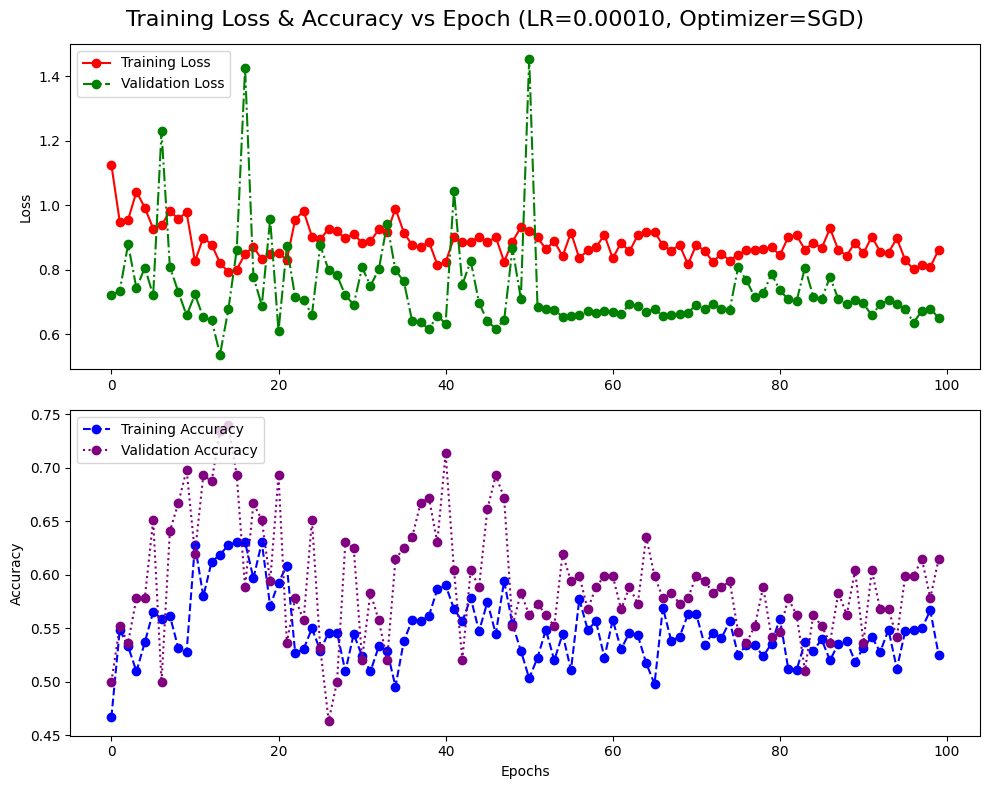

Entrenando con learning_rate=0.00010, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.6549935149156939
Epoch 1 Training Loss = 0.8456752936315908
Epoch 1 Validation Accuracy = 0.7552083333333334
Epoch 1 Validation Loss = 0.5489785571893057
La mejor precisión de Validation Loss (0.5489785571893057) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.8274967574578469
Epoch 2 Training Loss = 0.3810721734773015
Epoch 2 Validation Accuracy = 0.8072916666666666
Epoch 2 Validation Loss = 0.40393606821695965
La mejor precisión de Validation Loss (0.40393606821695965) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.8728923476005188
Epoch 3 Training Loss = 0.3221807616693964
Epoch 3 Validation Accuracy = 0.8125
Epoch 3 Validation Loss = 0.4335167606671651
La mejor precisión de Validation Loss (0.40393606821695965) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.8482490272373541
Epoch 4 Training Loss = 0.3579825888038764
Epoch 4 Validation Accuracy = 0.8125
Epoch 4 Validation Loss = 0.4418131808439891
La mejor precisión de Validation Loss (0.40393606821695965) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.874189364461738
Epoch 5 Training Loss = 0.2943142062263266
Epoch 5 Validation Accuracy = 0.8385416666666666
Epoch 5 Validation Loss = 0.3892199198404948
La mejor precisión de Validation Loss (0.3892199198404948) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8949416342412452
Epoch 6 Training Loss = 0.23797714571080783
Epoch 6 Validation Accuracy = 0.7447916666666666
Epoch 6 Validation Loss = 0.6202419598897299
La mejor precisión de Validation Loss (0.3892199198404948) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8910505836575876
Epoch 7 Training Loss = 0.27957627718879247
Epoch 7 Validation Accuracy = 0.8229166666666666
Epoch 7 Validation Loss = 0.3825381398200989
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8923476005188068
Epoch 8 Training Loss = 0.27271436516258346
Epoch 8 Validation Accuracy = 0.84375
Epoch 8 Validation Loss = 0.47159531712532043
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.914396887159533
Epoch 9 Training Loss = 0.21966008132688422
Epoch 9 Validation Accuracy = 0.8125
Epoch 9 Validation Loss = 0.6007317552963892
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9351491569390402
Epoch 10 Training Loss = 0.17327496179424218
Epoch 10 Validation Accuracy = 0.8645833333333334
Epoch 10 Validation Loss = 0.42844879627227783
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9377431906614786
Epoch 11 Training Loss = 0.167053310323782
Epoch 11 Validation Accuracy = 0.796875
Epoch 11 Validation Loss = 0.5777334372202555
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9053177691309987
Epoch 12 Training Loss = 0.25252905965392536
Epoch 12 Validation Accuracy = 0.8229166666666666
Epoch 12 Validation Loss = 0.5927551984786987
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.8962386511024644
Epoch 13 Training Loss = 0.24737387230733335
Epoch 13 Validation Accuracy = 0.8333333333333334
Epoch 13 Validation Loss = 0.6027248303095499
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.8962386511024644
Epoch 14 Training Loss = 0.26047831899383805
Epoch 14 Validation Accuracy = 0.78125
Epoch 14 Validation Loss = 0.6949350237846375
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9182879377431906
Epoch 15 Training Loss = 0.2293066670381296
Epoch 15 Validation Accuracy = 0.8489583333333334
Epoch 15 Validation Loss = 0.40174539883931476
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9247730220492867
Epoch 16 Training Loss = 0.16292896507315136
Epoch 16 Validation Accuracy = 0.7760416666666666
Epoch 16 Validation Loss = 0.6597163677215576
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9377431906614786
Epoch 17 Training Loss = 0.16070500422080666
Epoch 17 Validation Accuracy = 0.8645833333333334
Epoch 17 Validation Loss = 0.4325103263060252
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9442282749675746
Epoch 18 Training Loss = 0.129546325764922
Epoch 18 Validation Accuracy = 0.8697916666666666
Epoch 18 Validation Loss = 0.5020493070284525
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.940337224383917
Epoch 19 Training Loss = 0.17203143281540828
Epoch 19 Validation Accuracy = 0.8854166666666666
Epoch 19 Validation Loss = 0.49932223558425903
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9286640726329443
Epoch 20 Training Loss = 0.17100495076828892
Epoch 20 Validation Accuracy = 0.8645833333333334
Epoch 20 Validation Loss = 0.5515539745489756
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.914396887159533
Epoch 21 Training Loss = 0.2198928065414404
Epoch 21 Validation Accuracy = 0.7760416666666666
Epoch 21 Validation Loss = 1.358418862024943
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.8508430609597925
Epoch 22 Training Loss = 0.4428737197559322
Epoch 22 Validation Accuracy = 0.7395833333333334
Epoch 22 Validation Loss = 1.0033769011497498
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.8443579766536965
Epoch 23 Training Loss = 0.4412303507405342
Epoch 23 Validation Accuracy = 0.78125
Epoch 23 Validation Loss = 0.6224749088287354
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.8845654993514915
Epoch 24 Training Loss = 0.318736077963958
Epoch 24 Validation Accuracy = 0.8489583333333334
Epoch 24 Validation Loss = 0.6003875633080801
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.8897535667963683
Epoch 25 Training Loss = 0.2954963875497207
Epoch 25 Validation Accuracy = 0.7916666666666666
Epoch 25 Validation Loss = 0.8509369691212972
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9156939040207522
Epoch 26 Training Loss = 0.24087155715655414
Epoch 26 Validation Accuracy = 0.828125
Epoch 26 Validation Loss = 0.502941777308782
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.8897535667963683
Epoch 27 Training Loss = 0.3066088188483094
Epoch 27 Validation Accuracy = 0.7708333333333334
Epoch 27 Validation Loss = 0.7757283051808676
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.8560311284046692
Epoch 28 Training Loss = 0.36689753530863506
Epoch 28 Validation Accuracy = 0.8020833333333334
Epoch 28 Validation Loss = 0.7282979985078176
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.8910505836575876
Epoch 29 Training Loss = 0.31451077088617013
Epoch 29 Validation Accuracy = 0.78125
Epoch 29 Validation Loss = 0.6391090949376425
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.8897535667963683
Epoch 30 Training Loss = 0.2750026156157062
Epoch 30 Validation Accuracy = 0.8541666666666666
Epoch 30 Validation Loss = 0.5387700895468394
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.8326848249027238
Epoch 31 Training Loss = 0.4298741536458952
Epoch 31 Validation Accuracy = 0.7708333333333334
Epoch 31 Validation Loss = 0.6216223140557607
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.7924773022049286
Epoch 32 Training Loss = 0.5669069030405482
Epoch 32 Validation Accuracy = 0.765625
Epoch 32 Validation Loss = 0.7096816102663676
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.7989623865110247
Epoch 33 Training Loss = 0.5330921742393504
Epoch 33 Validation Accuracy = 0.8229166666666666
Epoch 33 Validation Loss = 0.4870857795079549
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.8326848249027238
Epoch 34 Training Loss = 0.4567429885055614
Epoch 34 Validation Accuracy = 0.8177083333333334
Epoch 34 Validation Loss = 0.4424278736114502
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.8664072632944229
Epoch 35 Training Loss = 0.37724960144082553
Epoch 35 Validation Accuracy = 0.8177083333333334
Epoch 35 Validation Loss = 0.5161212583382925
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.8599221789883269
Epoch 36 Training Loss = 0.3662968722453532
Epoch 36 Validation Accuracy = 0.7864583333333334
Epoch 36 Validation Loss = 0.5019499758879343
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.8638132295719845
Epoch 37 Training Loss = 0.3655172546240761
Epoch 37 Validation Accuracy = 0.78125
Epoch 37 Validation Loss = 0.6035758058230082
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.8495460440985733
Epoch 38 Training Loss = 0.4304268390288149
Epoch 38 Validation Accuracy = 0.859375
Epoch 38 Validation Loss = 0.42267443736394245
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.8702983138780804
Epoch 39 Training Loss = 0.3714898127371544
Epoch 39 Validation Accuracy = 0.859375
Epoch 39 Validation Loss = 0.4819292326768239
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.8651102464332037
Epoch 40 Training Loss = 0.3586583338127062
Epoch 40 Validation Accuracy = 0.7916666666666666
Epoch 40 Validation Loss = 0.550843358039856
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.8599221789883269
Epoch 41 Training Loss = 0.35974734124815727
Epoch 41 Validation Accuracy = 0.703125
Epoch 41 Validation Loss = 0.9480099081993103
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.867704280155642
Epoch 42 Training Loss = 0.3581022961130402
Epoch 42 Validation Accuracy = 0.8229166666666666
Epoch 42 Validation Loss = 0.5742921233177185
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.8625162127107653
Epoch 43 Training Loss = 0.3562982908405373
Epoch 43 Validation Accuracy = 0.8489583333333334
Epoch 43 Validation Loss = 0.49448710680007935
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.8728923476005188
Epoch 44 Training Loss = 0.33755830771032475
Epoch 44 Validation Accuracy = 0.84375
Epoch 44 Validation Loss = 0.48079103231430054
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.893644617380026
Epoch 45 Training Loss = 0.3435961617260746
Epoch 45 Validation Accuracy = 0.8385416666666666
Epoch 45 Validation Loss = 0.5596759219964346
La mejor precisión de Validation Loss (0.3825381398200989) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9079118028534371
Epoch 46 Training Loss = 0.23858986545629537
Epoch 46 Validation Accuracy = 0.890625
Epoch 46 Validation Loss = 0.37821121017138165
La mejor precisión de Validation Loss (0.37821121017138165) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9118028534370947
Epoch 47 Training Loss = 0.2310178433333544
Epoch 47 Validation Accuracy = 0.8854166666666666
Epoch 47 Validation Loss = 0.37962690989176434
La mejor precisión de Validation Loss (0.37821121017138165) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9118028534370947
Epoch 48 Training Loss = 0.23219612012732044
Epoch 48 Validation Accuracy = 0.859375
Epoch 48 Validation Loss = 0.41977192958196
La mejor precisión de Validation Loss (0.37821121017138165) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9221789883268483
Epoch 49 Training Loss = 0.1806725218370267
Epoch 49 Validation Accuracy = 0.890625
Epoch 49 Validation Loss = 0.3447195092837016
La mejor precisión de Validation Loss (0.3447195092837016) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.920881971465629
Epoch 50 Training Loss = 0.22006821394662449
Epoch 50 Validation Accuracy = 0.9010416666666666
Epoch 50 Validation Loss = 0.3203068921963374
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9234760051880675
Epoch 51 Training Loss = 0.226982835646424
Epoch 51 Validation Accuracy = 0.8333333333333334
Epoch 51 Validation Loss = 0.45486417412757874
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9286640726329443
Epoch 52 Training Loss = 0.17249366111483247
Epoch 52 Validation Accuracy = 0.84375
Epoch 52 Validation Loss = 0.4267373283704122
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9130998702983139
Epoch 53 Training Loss = 0.23521929109606762
Epoch 53 Validation Accuracy = 0.890625
Epoch 53 Validation Loss = 0.40332616368929547
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9053177691309987
Epoch 54 Training Loss = 0.2728074553257142
Epoch 54 Validation Accuracy = 0.8541666666666666
Epoch 54 Validation Loss = 0.41435983777046204
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.8988326848249028
Epoch 55 Training Loss = 0.25537956186151073
Epoch 55 Validation Accuracy = 0.8541666666666666
Epoch 55 Validation Loss = 0.5187288026014963
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.8975356679636836
Epoch 56 Training Loss = 0.2534219502011162
Epoch 56 Validation Accuracy = 0.8645833333333334
Epoch 56 Validation Loss = 0.4890036980311076
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9027237354085603
Epoch 57 Training Loss = 0.21605695623677373
Epoch 57 Validation Accuracy = 0.8645833333333334
Epoch 57 Validation Loss = 0.525695671637853
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9079118028534371
Epoch 58 Training Loss = 0.24029618844718476
Epoch 58 Validation Accuracy = 0.796875
Epoch 58 Validation Loss = 0.7486744125684103
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9312581063553826
Epoch 59 Training Loss = 0.19239077555684883
Epoch 59 Validation Accuracy = 0.8802083333333334
Epoch 59 Validation Loss = 0.42176822821299237
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9364461738002594
Epoch 60 Training Loss = 0.17459883257727368
Epoch 60 Validation Accuracy = 0.9010416666666666
Epoch 60 Validation Loss = 0.3589102476835251
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.920881971465629
Epoch 61 Training Loss = 0.17550703987537192
Epoch 61 Validation Accuracy = 0.8385416666666666
Epoch 61 Validation Loss = 0.5370057622591654
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9481193255512321
Epoch 62 Training Loss = 0.14132048413833911
Epoch 62 Validation Accuracy = 0.875
Epoch 62 Validation Loss = 0.42612627645333606
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9325551232166018
Epoch 63 Training Loss = 0.15463825716273485
Epoch 63 Validation Accuracy = 0.8333333333333334
Epoch 63 Validation Loss = 0.6551530361175537
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9299610894941635
Epoch 64 Training Loss = 0.16261430225792872
Epoch 64 Validation Accuracy = 0.8541666666666666
Epoch 64 Validation Loss = 0.5299833416938782
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.914396887159533
Epoch 65 Training Loss = 0.20605443872211818
Epoch 65 Validation Accuracy = 0.859375
Epoch 65 Validation Loss = 0.41339053710301715
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9377431906614786
Epoch 66 Training Loss = 0.15650040491081862
Epoch 66 Validation Accuracy = 0.84375
Epoch 66 Validation Loss = 0.49457262953122455
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9390402075226978
Epoch 67 Training Loss = 0.1391460705360086
Epoch 67 Validation Accuracy = 0.859375
Epoch 67 Validation Loss = 0.4768192172050476
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9520103761348897
Epoch 68 Training Loss = 0.10955436456218923
Epoch 68 Validation Accuracy = 0.8802083333333334
Epoch 68 Validation Loss = 0.4241496076186498
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9520103761348897
Epoch 69 Training Loss = 0.10955998382679684
Epoch 69 Validation Accuracy = 0.875
Epoch 69 Validation Loss = 0.43907497326533
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9571984435797666
Epoch 70 Training Loss = 0.11967397214006512
Epoch 70 Validation Accuracy = 0.8645833333333334
Epoch 70 Validation Loss = 0.7339832882086436
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9636835278858625
Epoch 71 Training Loss = 0.08705429991782099
Epoch 71 Validation Accuracy = 0.8854166666666666
Epoch 71 Validation Loss = 0.4851630926132202
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9623865110246433
Epoch 72 Training Loss = 0.10474546704001618
Epoch 72 Validation Accuracy = 0.890625
Epoch 72 Validation Loss = 0.47720478971799213
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9584954604409858
Epoch 73 Training Loss = 0.10262666370154355
Epoch 73 Validation Accuracy = 0.8802083333333334
Epoch 73 Validation Loss = 0.4839317897955577
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.940337224383917
Epoch 74 Training Loss = 0.14735604693144366
Epoch 74 Validation Accuracy = 0.875
Epoch 74 Validation Loss = 0.500950405995051
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9688715953307393
Epoch 75 Training Loss = 0.0778990858482093
Epoch 75 Validation Accuracy = 0.890625
Epoch 75 Validation Loss = 0.490549902121226
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9649805447470817
Epoch 76 Training Loss = 0.06559980595689725
Epoch 76 Validation Accuracy = 0.90625
Epoch 76 Validation Loss = 0.41649800539016724
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9701686121919585
Epoch 77 Training Loss = 0.08993407616200923
Epoch 77 Validation Accuracy = 0.890625
Epoch 77 Validation Loss = 0.48486780126889545
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9649805447470817
Epoch 78 Training Loss = 0.08080865421493075
Epoch 78 Validation Accuracy = 0.9114583333333334
Epoch 78 Validation Loss = 0.44238191843032837
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9740596627756161
Epoch 79 Training Loss = 0.08271408769097928
Epoch 79 Validation Accuracy = 0.8958333333333334
Epoch 79 Validation Loss = 0.5731799006462097
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9494163424124513
Epoch 80 Training Loss = 0.14906777690820658
Epoch 80 Validation Accuracy = 0.8697916666666666
Epoch 80 Validation Loss = 0.809528112411499
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.8754863813229572
Epoch 81 Training Loss = 0.34376190577654214
Epoch 81 Validation Accuracy = 0.6979166666666666
Epoch 81 Validation Loss = 1.605895717938741
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.8041504539559015
Epoch 82 Training Loss = 0.6064203166621513
Epoch 82 Validation Accuracy = 0.6614583333333334
Epoch 82 Validation Loss = 3.7153451442718506
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.77431906614786
Epoch 83 Training Loss = 0.6408393423226403
Epoch 83 Validation Accuracy = 0.78125
Epoch 83 Validation Loss = 0.7303328017393748
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.7846952010376135
Epoch 84 Training Loss = 0.6209072445153262
Epoch 84 Validation Accuracy = 0.7395833333333334
Epoch 84 Validation Loss = 0.7858838438987732
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.833981841763943
Epoch 85 Training Loss = 0.47082258283550793
Epoch 85 Validation Accuracy = 0.7864583333333334
Epoch 85 Validation Loss = 0.7471711834271749
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.8158236057068742
Epoch 86 Training Loss = 0.43399371293490574
Epoch 86 Validation Accuracy = 0.8125
Epoch 86 Validation Loss = 0.5811516443888346
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.85473411154345
Epoch 87 Training Loss = 0.40008863648242676
Epoch 87 Validation Accuracy = 0.8177083333333334
Epoch 87 Validation Loss = 0.6222220659255981
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.8560311284046692
Epoch 88 Training Loss = 0.3760494715818017
Epoch 88 Validation Accuracy = 0.8072916666666666
Epoch 88 Validation Loss = 0.7444425920645396
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.8780804150453956
Epoch 89 Training Loss = 0.2981817791897963
Epoch 89 Validation Accuracy = 0.8125
Epoch 89 Validation Loss = 0.7767702341079712
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.8651102464332037
Epoch 90 Training Loss = 0.35095827480543756
Epoch 90 Validation Accuracy = 0.78125
Epoch 90 Validation Loss = 0.8075394829114279
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.8728923476005188
Epoch 91 Training Loss = 0.3640311305470349
Epoch 91 Validation Accuracy = 0.796875
Epoch 91 Validation Loss = 0.9450921018918356
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.7924773022049286
Epoch 92 Training Loss = 0.622943322791509
Epoch 92 Validation Accuracy = 0.65625
Epoch 92 Validation Loss = 1.4386170307795207
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.7185473411154345
Epoch 93 Training Loss = 0.7856622065203663
Epoch 93 Validation Accuracy = 0.6979166666666666
Epoch 93 Validation Loss = 1.1269293824831645
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.7315175097276264
Epoch 94 Training Loss = 0.6995915465163195
Epoch 94 Validation Accuracy = 0.7604166666666666
Epoch 94 Validation Loss = 0.8951593240102133
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.7937743190661478
Epoch 95 Training Loss = 0.5277355680515176
Epoch 95 Validation Accuracy = 0.7708333333333334
Epoch 95 Validation Loss = 0.8740764657656351
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.8106355382619974
Epoch 96 Training Loss = 0.49824646660326055
Epoch 96 Validation Accuracy = 0.8229166666666666
Epoch 96 Validation Loss = 0.6768747170766195
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.7976653696498055
Epoch 97 Training Loss = 0.49802948010725423
Epoch 97 Validation Accuracy = 0.7552083333333334
Epoch 97 Validation Loss = 1.153156856695811
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.7431906614785992
Epoch 98 Training Loss = 0.6802898300606298
Epoch 98 Validation Accuracy = 0.6822916666666666
Epoch 98 Validation Loss = 2.297308882077535
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.7185473411154345
Epoch 99 Training Loss = 0.7229426177134001
Epoch 99 Validation Accuracy = 0.7291666666666666
Epoch 99 Validation Loss = 0.9926915367444357
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.74189364461738
Epoch 100 Training Loss = 0.7899791156116935
Epoch 100 Validation Accuracy = 0.6875
Epoch 100 Validation Loss = 0.8724246223767599
La mejor precisión de Validation Loss (0.3203068921963374) se alcanzó en la época 50


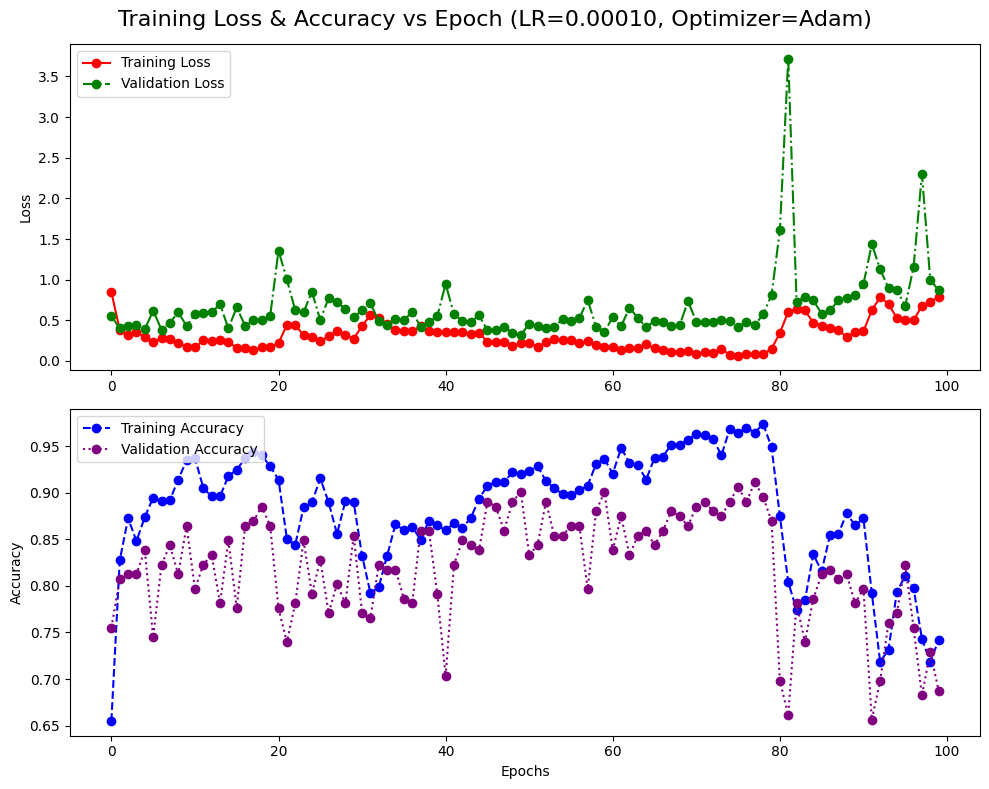

Entrenando con learning_rate=0.00010, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5408560311284046
Epoch 1 Training Loss = 2.3856558076138628
Epoch 1 Validation Accuracy = 0.5572916666666666
Epoch 1 Validation Loss = 7.878121852874756
La mejor precisión de Validation Loss (7.878121852874756) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6770428015564203
Epoch 2 Training Loss = 1.1657025634701303
Epoch 2 Validation Accuracy = 0.6979166666666666
Epoch 2 Validation Loss = 1.2579344113667805
La mejor precisión de Validation Loss (1.2579344113667805) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.6705577172503242
Epoch 3 Training Loss = 0.9122767270616365
Epoch 3 Validation Accuracy = 0.46875
Epoch 3 Validation Loss = 1.222371260325114
La mejor precisión de Validation Loss (1.222371260325114) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.6926070038910506
Epoch 4 Training Loss = 0.7945974227210117
Epoch 4 Validation Accuracy = 0.7083333333333334
Epoch 4 Validation Loss = 0.727984607219696
La mejor precisión de Validation Loss (0.727984607219696) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7846952010376135
Epoch 5 Training Loss = 0.5850880633841538
Epoch 5 Validation Accuracy = 0.78125
Epoch 5 Validation Loss = 0.7528377970059713
La mejor precisión de Validation Loss (0.727984607219696) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8119325551232166
Epoch 6 Training Loss = 0.5101949935138766
Epoch 6 Validation Accuracy = 0.7291666666666666
Epoch 6 Validation Loss = 0.6889451344807943
La mejor precisión de Validation Loss (0.6889451344807943) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8508430609597925
Epoch 7 Training Loss = 0.4248740468584919
Epoch 7 Validation Accuracy = 0.7864583333333334
Epoch 7 Validation Loss = 0.8241722881793976
La mejor precisión de Validation Loss (0.6889451344807943) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9040207522697795
Epoch 8 Training Loss = 0.24746878586235987
Epoch 8 Validation Accuracy = 0.671875
Epoch 8 Validation Loss = 1.245584746201833
La mejor precisión de Validation Loss (0.6889451344807943) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8923476005188068
Epoch 9 Training Loss = 0.2715102868630574
Epoch 9 Validation Accuracy = 0.7916666666666666
Epoch 9 Validation Loss = 0.5363394916057587
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9169909208819714
Epoch 10 Training Loss = 0.21592447869044798
Epoch 10 Validation Accuracy = 0.8229166666666666
Epoch 10 Validation Loss = 0.5549393991629282
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9312581063553826
Epoch 11 Training Loss = 0.187046107460398
Epoch 11 Validation Accuracy = 0.7708333333333334
Epoch 11 Validation Loss = 0.7410974105199178
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.8158236057068742
Epoch 12 Training Loss = 0.4830046433341797
Epoch 12 Validation Accuracy = 0.8020833333333334
Epoch 12 Validation Loss = 0.5876623094081879
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9156939040207522
Epoch 13 Training Loss = 0.2633794835260097
Epoch 13 Validation Accuracy = 0.671875
Epoch 13 Validation Loss = 1.6840198437372844
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.8443579766536965
Epoch 14 Training Loss = 0.4210203681551838
Epoch 14 Validation Accuracy = 0.6666666666666666
Epoch 14 Validation Loss = 1.7930829524993896
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.8184176394293126
Epoch 15 Training Loss = 0.4849058746054633
Epoch 15 Validation Accuracy = 0.7916666666666666
Epoch 15 Validation Loss = 0.744468609491984
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.8456549935149157
Epoch 16 Training Loss = 0.43224971910549664
Epoch 16 Validation Accuracy = 0.6875
Epoch 16 Validation Loss = 1.669212520122528
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.8651102464332037
Epoch 17 Training Loss = 0.3774691495836631
Epoch 17 Validation Accuracy = 0.7864583333333334
Epoch 17 Validation Loss = 0.6745609839757284
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.8534370946822308
Epoch 18 Training Loss = 0.36033596061701595
Epoch 18 Validation Accuracy = 0.734375
Epoch 18 Validation Loss = 0.8729920387268066
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.8508430609597925
Epoch 19 Training Loss = 0.36682954449907196
Epoch 19 Validation Accuracy = 0.5520833333333334
Epoch 19 Validation Loss = 4.93835433324178
La mejor precisión de Validation Loss (0.5363394916057587) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.808041504539559
Epoch 20 Training Loss = 0.4647274373724921
Epoch 20 Validation Accuracy = 0.8072916666666666
Epoch 20 Validation Loss = 0.528389443953832
La mejor precisión de Validation Loss (0.528389443953832) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.867704280155642
Epoch 21 Training Loss = 0.35210087141638136
Epoch 21 Validation Accuracy = 0.6354166666666666
Epoch 21 Validation Loss = 5.717565854390462
La mejor precisión de Validation Loss (0.528389443953832) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.8119325551232166
Epoch 22 Training Loss = 0.5430082812538097
Epoch 22 Validation Accuracy = 0.8177083333333334
Epoch 22 Validation Loss = 0.5702380239963531
La mejor precisión de Validation Loss (0.528389443953832) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.8767833981841764
Epoch 23 Training Loss = 0.34750247476610385
Epoch 23 Validation Accuracy = 0.8229166666666666
Epoch 23 Validation Loss = 0.5636562705039978
La mejor precisión de Validation Loss (0.528389443953832) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9014267185473411
Epoch 24 Training Loss = 0.25250422397940075
Epoch 24 Validation Accuracy = 0.734375
Epoch 24 Validation Loss = 2.015271782875061
La mejor precisión de Validation Loss (0.528389443953832) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.8378728923476005
Epoch 25 Training Loss = 0.4800005457068077
Epoch 25 Validation Accuracy = 0.8645833333333334
Epoch 25 Validation Loss = 0.42428340514500934
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.880674448767834
Epoch 26 Training Loss = 0.29609882777457724
Epoch 26 Validation Accuracy = 0.5260416666666666
Epoch 26 Validation Loss = 5.088598171869914
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.8223086900129701
Epoch 27 Training Loss = 0.46769724482846786
Epoch 27 Validation Accuracy = 0.5104166666666666
Epoch 27 Validation Loss = 8.85877768198649
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.7924773022049286
Epoch 28 Training Loss = 0.5167161199214703
Epoch 28 Validation Accuracy = 0.734375
Epoch 28 Validation Loss = 0.6779370903968811
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.8274967574578469
Epoch 29 Training Loss = 0.4589638207325212
Epoch 29 Validation Accuracy = 0.84375
Epoch 29 Validation Loss = 0.4969550569852193
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.867704280155642
Epoch 30 Training Loss = 0.34185162360566135
Epoch 30 Validation Accuracy = 0.75
Epoch 30 Validation Loss = 0.7498828768730164
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.8819714656290532
Epoch 31 Training Loss = 0.2760725301218095
Epoch 31 Validation Accuracy = 0.7864583333333334
Epoch 31 Validation Loss = 0.7405005693435669
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.8780804150453956
Epoch 32 Training Loss = 0.31417771025854324
Epoch 32 Validation Accuracy = 0.8385416666666666
Epoch 32 Validation Loss = 0.45667486389478046
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9156939040207522
Epoch 33 Training Loss = 0.22443138300676754
Epoch 33 Validation Accuracy = 0.7760416666666666
Epoch 33 Validation Loss = 0.6278674900531769
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.8884565499351491
Epoch 34 Training Loss = 0.266510956559509
Epoch 34 Validation Accuracy = 0.8072916666666666
Epoch 34 Validation Loss = 0.4874754150708516
La mejor precisión de Validation Loss (0.42428340514500934) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9169909208819714
Epoch 35 Training Loss = 0.1940508030268005
Epoch 35 Validation Accuracy = 0.8645833333333334
Epoch 35 Validation Loss = 0.4065569341182709
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9442282749675746
Epoch 36 Training Loss = 0.13466248403263464
Epoch 36 Validation Accuracy = 0.8125
Epoch 36 Validation Loss = 0.8603659868240356
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9001297016861219
Epoch 37 Training Loss = 0.2833481860551234
Epoch 37 Validation Accuracy = 0.7916666666666666
Epoch 37 Validation Loss = 0.7457108497619629
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.8949416342412452
Epoch 38 Training Loss = 0.2946126011095158
Epoch 38 Validation Accuracy = 0.8333333333333334
Epoch 38 Validation Loss = 0.5706200202306112
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9390402075226978
Epoch 39 Training Loss = 0.14555899693779212
Epoch 39 Validation Accuracy = 0.7447916666666666
Epoch 39 Validation Loss = 0.9827805757522583
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9325551232166018
Epoch 40 Training Loss = 0.18513455431806902
Epoch 40 Validation Accuracy = 0.8645833333333334
Epoch 40 Validation Loss = 0.448747177918752
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9468223086900129
Epoch 41 Training Loss = 0.13005261739713517
Epoch 41 Validation Accuracy = 0.828125
Epoch 41 Validation Loss = 1.2899785935878754
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9312581063553826
Epoch 42 Training Loss = 0.22081703587342175
Epoch 42 Validation Accuracy = 0.8489583333333334
Epoch 42 Validation Loss = 0.6384913523991903
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9520103761348897
Epoch 43 Training Loss = 0.14252417065908626
Epoch 43 Validation Accuracy = 0.5416666666666666
Epoch 43 Validation Loss = 2.4240790208180747
La mejor precisión de Validation Loss (0.4065569341182709) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.933852140077821
Epoch 44 Training Loss = 0.1747175591349138
Epoch 44 Validation Accuracy = 0.8697916666666666
Epoch 44 Validation Loss = 0.3994939724604289
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9623865110246433
Epoch 45 Training Loss = 0.11454630288477848
Epoch 45 Validation Accuracy = 0.796875
Epoch 45 Validation Loss = 0.7156387368837992
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9559014267185474
Epoch 46 Training Loss = 0.13513164506831368
Epoch 46 Validation Accuracy = 0.8385416666666666
Epoch 46 Validation Loss = 0.7475503285725912
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9584954604409858
Epoch 47 Training Loss = 0.12205027188772358
Epoch 47 Validation Accuracy = 0.796875
Epoch 47 Validation Loss = 1.1451565821965535
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9442282749675746
Epoch 48 Training Loss = 0.1601701987238091
Epoch 48 Validation Accuracy = 0.5989583333333334
Epoch 48 Validation Loss = 13.039016882578531
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.8728923476005188
Epoch 49 Training Loss = 0.4337653122140498
Epoch 49 Validation Accuracy = 0.8489583333333334
Epoch 49 Validation Loss = 0.5575782557328542
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.8949416342412452
Epoch 50 Training Loss = 0.24513300275369687
Epoch 50 Validation Accuracy = 0.75
Epoch 50 Validation Loss = 1.2214693029721577
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.920881971465629
Epoch 51 Training Loss = 0.17240965567364921
Epoch 51 Validation Accuracy = 0.84375
Epoch 51 Validation Loss = 0.6303893625736237
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9312581063553826
Epoch 52 Training Loss = 0.17199198899720583
Epoch 52 Validation Accuracy = 0.890625
Epoch 52 Validation Loss = 0.5782939990361532
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9468223086900129
Epoch 53 Training Loss = 0.13775894072887654
Epoch 53 Validation Accuracy = 0.8854166666666666
Epoch 53 Validation Loss = 0.4874795724948247
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9546044098573282
Epoch 54 Training Loss = 0.12703391496000277
Epoch 54 Validation Accuracy = 0.7864583333333334
Epoch 54 Validation Loss = 4.337583065032959
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9118028534370947
Epoch 55 Training Loss = 0.2640173138009358
Epoch 55 Validation Accuracy = 0.8333333333333334
Epoch 55 Validation Loss = 0.8912994464238485
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9325551232166018
Epoch 56 Training Loss = 0.16769755181968793
Epoch 56 Validation Accuracy = 0.8489583333333334
Epoch 56 Validation Loss = 0.8212243020534515
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9688715953307393
Epoch 57 Training Loss = 0.09229409578709287
Epoch 57 Validation Accuracy = 0.8854166666666666
Epoch 57 Validation Loss = 0.422831192612648
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9584954604409858
Epoch 58 Training Loss = 0.1117754737072263
Epoch 58 Validation Accuracy = 0.796875
Epoch 58 Validation Loss = 1.012796680132548
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9688715953307393
Epoch 59 Training Loss = 0.09079290917759275
Epoch 59 Validation Accuracy = 0.8697916666666666
Epoch 59 Validation Loss = 0.43406913181145984
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9714656290531777
Epoch 60 Training Loss = 0.06324584691286396
Epoch 60 Validation Accuracy = 0.609375
Epoch 60 Validation Loss = 11.179204305013021
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.8352788586251622
Epoch 61 Training Loss = 0.5083052247724026
Epoch 61 Validation Accuracy = 0.7708333333333334
Epoch 61 Validation Loss = 0.8457319140434265
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9105058365758755
Epoch 62 Training Loss = 0.23247817471797363
Epoch 62 Validation Accuracy = 0.7760416666666666
Epoch 62 Validation Loss = 1.6677430868148804
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.867704280155642
Epoch 63 Training Loss = 0.36389950822299555
Epoch 63 Validation Accuracy = 0.796875
Epoch 63 Validation Loss = 0.5845519701639811
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.8975356679636836
Epoch 64 Training Loss = 0.2737134999647524
Epoch 64 Validation Accuracy = 0.7760416666666666
Epoch 64 Validation Loss = 0.6554267307122549
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9182879377431906
Epoch 65 Training Loss = 0.22098267549979858
Epoch 65 Validation Accuracy = 0.6041666666666666
Epoch 65 Validation Loss = 3.925299803415934
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9286640726329443
Epoch 66 Training Loss = 0.2330669521821612
Epoch 66 Validation Accuracy = 0.6875
Epoch 66 Validation Loss = 2.376145124435425
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.8638132295719845
Epoch 67 Training Loss = 0.43145343332748315
Epoch 67 Validation Accuracy = 0.7864583333333334
Epoch 67 Validation Loss = 0.9736436208089193
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9182879377431906
Epoch 68 Training Loss = 0.24145216159474217
Epoch 68 Validation Accuracy = 0.546875
Epoch 68 Validation Loss = 5.019233703613281
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.8534370946822308
Epoch 69 Training Loss = 0.42226356438007184
Epoch 69 Validation Accuracy = 0.8645833333333334
Epoch 69 Validation Loss = 0.5198547144730886
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9156939040207522
Epoch 70 Training Loss = 0.23908643252500145
Epoch 70 Validation Accuracy = 0.8541666666666666
Epoch 70 Validation Loss = 0.5670867462952932
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9299610894941635
Epoch 71 Training Loss = 0.19159491462620934
Epoch 71 Validation Accuracy = 0.5677083333333334
Epoch 71 Validation Loss = 5.407509724299113
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9079118028534371
Epoch 72 Training Loss = 0.26211237799661324
Epoch 72 Validation Accuracy = 0.8125
Epoch 72 Validation Loss = 0.6319762468338013
La mejor precisión de Validation Loss (0.3994939724604289) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9481193255512321
Epoch 73 Training Loss = 0.13747001335872808
Epoch 73 Validation Accuracy = 0.859375
Epoch 73 Validation Loss = 0.3788445194562276
La mejor precisión de Validation Loss (0.3788445194562276) se alcanzó en la época 73


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9299610894941635
Epoch 74 Training Loss = 0.17272136488931808
Epoch 74 Validation Accuracy = 0.859375
Epoch 74 Validation Loss = 0.46662457784016925
La mejor precisión de Validation Loss (0.3788445194562276) se alcanzó en la época 73


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9662775616083009
Epoch 75 Training Loss = 0.11370853467055642
Epoch 75 Validation Accuracy = 0.875
Epoch 75 Validation Loss = 0.4764094253381093
La mejor precisión de Validation Loss (0.3788445194562276) se alcanzó en la época 73


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9662775616083009
Epoch 76 Training Loss = 0.10001049042786876
Epoch 76 Validation Accuracy = 0.8541666666666666
Epoch 76 Validation Loss = 0.3396664361159007
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9701686121919585
Epoch 77 Training Loss = 0.08070909435801624
Epoch 77 Validation Accuracy = 0.640625
Epoch 77 Validation Loss = 2.933408180872599
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9390402075226978
Epoch 78 Training Loss = 0.18006468607757806
Epoch 78 Validation Accuracy = 0.6927083333333334
Epoch 78 Validation Loss = 1.6223942438761394
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9559014267185474
Epoch 79 Training Loss = 0.13332712820377177
Epoch 79 Validation Accuracy = 0.8125
Epoch 79 Validation Loss = 0.6569589177767435
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9442282749675746
Epoch 80 Training Loss = 0.13942066967564642
Epoch 80 Validation Accuracy = 0.7552083333333334
Epoch 80 Validation Loss = 3.8787335952123008
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.8949416342412452
Epoch 81 Training Loss = 0.28476693853313145
Epoch 81 Validation Accuracy = 0.8072916666666666
Epoch 81 Validation Loss = 1.0154143075148265
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.940337224383917
Epoch 82 Training Loss = 0.16345448569719584
Epoch 82 Validation Accuracy = 0.8541666666666666
Epoch 82 Validation Loss = 0.5441702604293823
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9714656290531777
Epoch 83 Training Loss = 0.0870841188034968
Epoch 83 Validation Accuracy = 0.8125
Epoch 83 Validation Loss = 0.7687581777572632
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9675745784695201
Epoch 84 Training Loss = 0.08958148431569223
Epoch 84 Validation Accuracy = 0.8385416666666666
Epoch 84 Validation Loss = 0.5138325393199921
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9701686121919585
Epoch 85 Training Loss = 0.07778049567678096
Epoch 85 Validation Accuracy = 0.859375
Epoch 85 Validation Loss = 0.619304875532786
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9714656290531777
Epoch 86 Training Loss = 0.07574652560809012
Epoch 86 Validation Accuracy = 0.8541666666666666
Epoch 86 Validation Loss = 0.4581212004025777
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9831387808041504
Epoch 87 Training Loss = 0.054941884004033804
Epoch 87 Validation Accuracy = 0.796875
Epoch 87 Validation Loss = 0.70835942029953
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9857328145265889
Epoch 88 Training Loss = 0.037002876690853434
Epoch 88 Validation Accuracy = 0.7447916666666666
Epoch 88 Validation Loss = 1.1053405702114105
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.980544747081712
Epoch 89 Training Loss = 0.042514978370468595
Epoch 89 Validation Accuracy = 0.875
Epoch 89 Validation Loss = 0.47607999046643573
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9831387808041504
Epoch 90 Training Loss = 0.05226731656621127
Epoch 90 Validation Accuracy = 0.859375
Epoch 90 Validation Loss = 0.43878643214702606
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9896238651102465
Epoch 91 Training Loss = 0.027050800302613105
Epoch 91 Validation Accuracy = 0.8072916666666666
Epoch 91 Validation Loss = 2.479468822479248
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9416342412451362
Epoch 92 Training Loss = 0.16800374096083115
Epoch 92 Validation Accuracy = 0.8541666666666666
Epoch 92 Validation Loss = 0.6378825108210245
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9727626459143969
Epoch 93 Training Loss = 0.08151748627617511
Epoch 93 Validation Accuracy = 0.8541666666666666
Epoch 93 Validation Loss = 0.5867476860682169
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9844357976653697
Epoch 94 Training Loss = 0.03819762651558516
Epoch 94 Validation Accuracy = 0.5208333333333334
Epoch 94 Validation Loss = 7.69565471013387
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.8715953307392996
Epoch 95 Training Loss = 0.4396082696283838
Epoch 95 Validation Accuracy = 0.625
Epoch 95 Validation Loss = 3.7508594195048013
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9130998702983139
Epoch 96 Training Loss = 0.23797051687803406
Epoch 96 Validation Accuracy = 0.703125
Epoch 96 Validation Loss = 4.264995018641154
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.8715953307392996
Epoch 97 Training Loss = 0.3587253764561642
Epoch 97 Validation Accuracy = 0.703125
Epoch 97 Validation Loss = 2.3803342978159585
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.880674448767834
Epoch 98 Training Loss = 0.32633949105957605
Epoch 98 Validation Accuracy = 0.859375
Epoch 98 Validation Loss = 0.7033512194951376
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9390402075226978
Epoch 99 Training Loss = 0.16948916549261675
Epoch 99 Validation Accuracy = 0.8802083333333334
Epoch 99 Validation Loss = 0.4095982511838277
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9584954604409858
Epoch 100 Training Loss = 0.11995577472038615
Epoch 100 Validation Accuracy = 0.78125
Epoch 100 Validation Loss = 1.0073522925376892
La mejor precisión de Validation Loss (0.3396664361159007) se alcanzó en la época 76


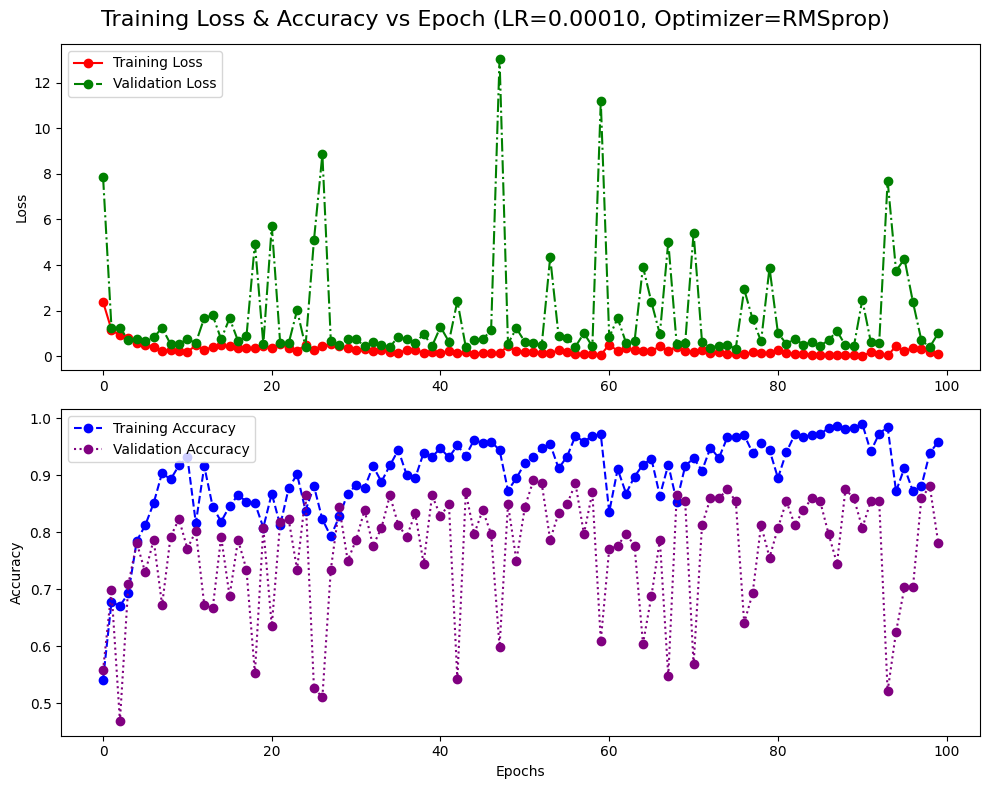

Entrenando con learning_rate=0.00100, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5473411154345007
Epoch 1 Training Loss = 0.9876143537490748
Epoch 1 Validation Accuracy = 0.6458333333333334
Epoch 1 Validation Loss = 0.637394368648529
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6005188067444877
Epoch 2 Training Loss = 0.8862564492627649
Epoch 2 Validation Accuracy = 0.5364583333333334
Epoch 2 Validation Loss = 8.938518524169922
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5654993514915694
Epoch 3 Training Loss = 0.9506613098075263
Epoch 3 Validation Accuracy = 0.5364583333333334
Epoch 3 Validation Loss = 1045.3859456380208
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5408560311284046
Epoch 4 Training Loss = 0.9450588066290325
Epoch 4 Validation Accuracy = 0.4635416666666667
Epoch 4 Validation Loss = 67.84623718261719
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5123216601815823
Epoch 5 Training Loss = 1.0197335636260136
Epoch 5 Validation Accuracy = 0.5416666666666666
Epoch 5 Validation Loss = 13.78103510538737
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5278858625162127
Epoch 6 Training Loss = 0.9636747816193428
Epoch 6 Validation Accuracy = 0.515625
Epoch 6 Validation Loss = 1.386971076329549
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5706874189364461
Epoch 7 Training Loss = 0.9006780200431319
Epoch 7 Validation Accuracy = 0.4635416666666667
Epoch 7 Validation Loss = 5.375123818715413
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5278858625162127
Epoch 8 Training Loss = 1.0570899594464036
Epoch 8 Validation Accuracy = 0.4479166666666667
Epoch 8 Validation Loss = 3.4930546283721924
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5642023346303502
Epoch 9 Training Loss = 0.9191870809992928
Epoch 9 Validation Accuracy = 0.4947916666666667
Epoch 9 Validation Loss = 1.3795068661371868
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5201037613488976
Epoch 10 Training Loss = 0.9980921884455106
Epoch 10 Validation Accuracy = 0.5572916666666666
Epoch 10 Validation Loss = 0.7878168821334839
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.543450064850843
Epoch 11 Training Loss = 0.9629635810078968
Epoch 11 Validation Accuracy = 0.5364583333333334
Epoch 11 Validation Loss = 0.9066378474235535
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5304798962386511
Epoch 12 Training Loss = 0.9733191681047358
Epoch 12 Validation Accuracy = 0.5625
Epoch 12 Validation Loss = 0.7600716749827067
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.5291828793774319
Epoch 13 Training Loss = 0.9589180852034058
Epoch 13 Validation Accuracy = 0.5520833333333334
Epoch 13 Validation Loss = 0.9470505913098654
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.5447470817120622
Epoch 14 Training Loss = 0.930832256293637
Epoch 14 Validation Accuracy = 0.5989583333333334
Epoch 14 Validation Loss = 0.8789868950843811
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.5642023346303502
Epoch 15 Training Loss = 0.9319752971176662
Epoch 15 Validation Accuracy = 0.546875
Epoch 15 Validation Loss = 0.7825119495391846
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.5654993514915694
Epoch 16 Training Loss = 0.8875561856728738
Epoch 16 Validation Accuracy = 0.5416666666666666
Epoch 16 Validation Loss = 0.8755668799082438
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.5719844357976653
Epoch 17 Training Loss = 0.8848438636338201
Epoch 17 Validation Accuracy = 0.453125
Epoch 17 Validation Loss = 10.309967041015625
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.6044098573281452
Epoch 18 Training Loss = 0.8790637432523893
Epoch 18 Validation Accuracy = 0.4583333333333333
Epoch 18 Validation Loss = 15.854764302571615
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.5291828793774319
Epoch 19 Training Loss = 1.005984825537517
Epoch 19 Validation Accuracy = 0.5364583333333334
Epoch 19 Validation Loss = 2.0710395971934
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.543450064850843
Epoch 20 Training Loss = 0.9529238500174536
Epoch 20 Validation Accuracy = 0.4791666666666667
Epoch 20 Validation Loss = 1.704827864964803
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5486381322957199
Epoch 21 Training Loss = 0.9300174129457635
Epoch 21 Validation Accuracy = 0.5104166666666666
Epoch 21 Validation Loss = 0.7596223950386047
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.5616083009079118
Epoch 22 Training Loss = 0.901807729836104
Epoch 22 Validation Accuracy = 0.4791666666666667
Epoch 22 Validation Loss = 0.9608979821205139
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.569390402075227
Epoch 23 Training Loss = 0.9140656264994086
Epoch 23 Validation Accuracy = 0.5572916666666666
Epoch 23 Validation Loss = 0.8402453263600668
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.5149156939040207
Epoch 24 Training Loss = 1.004664771133205
Epoch 24 Validation Accuracy = 0.546875
Epoch 24 Validation Loss = 0.8277356823285421
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.4993514915693904
Epoch 25 Training Loss = 1.02821305707271
Epoch 25 Validation Accuracy = 0.5
Epoch 25 Validation Loss = 5.767740885416667
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5486381322957199
Epoch 26 Training Loss = 0.9419221525526232
Epoch 26 Validation Accuracy = 0.59375
Epoch 26 Validation Loss = 0.6581535538037618
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.5577172503242542
Epoch 27 Training Loss = 0.9221816858428925
Epoch 27 Validation Accuracy = 0.5833333333333334
Epoch 27 Validation Loss = 0.6902753512064616
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5538261997405967
Epoch 28 Training Loss = 0.9108677000077937
Epoch 28 Validation Accuracy = 0.53125
Epoch 28 Validation Loss = 0.7380980451901754
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.5278858625162127
Epoch 29 Training Loss = 0.915705722980153
Epoch 29 Validation Accuracy = 0.5520833333333334
Epoch 29 Validation Loss = 0.7464525898297628
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.5512321660181583
Epoch 30 Training Loss = 0.907042789783923
Epoch 30 Validation Accuracy = 0.5625
Epoch 30 Validation Loss = 0.7987564206123352
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.5071335927367056
Epoch 31 Training Loss = 0.9376039931746308
Epoch 31 Validation Accuracy = 0.578125
Epoch 31 Validation Loss = 0.801999032497406
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.5265888456549935
Epoch 32 Training Loss = 0.9578702343113228
Epoch 32 Validation Accuracy = 0.5729166666666666
Epoch 32 Validation Loss = 0.8170434236526489
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.5719844357976653
Epoch 33 Training Loss = 0.878294646817268
Epoch 33 Validation Accuracy = 0.6354166666666666
Epoch 33 Validation Loss = 0.6833296418190002
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.5421530479896238
Epoch 34 Training Loss = 0.8932086111815832
Epoch 34 Validation Accuracy = 0.5416666666666666
Epoch 34 Validation Loss = 3.6585710843404136
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.5356679636835279
Epoch 35 Training Loss = 0.9228130538794471
Epoch 35 Validation Accuracy = 0.4635416666666667
Epoch 35 Validation Loss = 1.8366375764211018
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.582360570687419
Epoch 36 Training Loss = 0.869241757306298
Epoch 36 Validation Accuracy = 0.5052083333333334
Epoch 36 Validation Loss = 1.342996637026469
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.5966277561608301
Epoch 37 Training Loss = 0.9227220842037374
Epoch 37 Validation Accuracy = 0.453125
Epoch 37 Validation Loss = 1.8336741924285889
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.6160830090791181
Epoch 38 Training Loss = 0.7917739219779943
Epoch 38 Validation Accuracy = 0.5052083333333334
Epoch 38 Validation Loss = 1.5920355319976807
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.6186770428015564
Epoch 39 Training Loss = 0.745229437193518
Epoch 39 Validation Accuracy = 0.5416666666666666
Epoch 39 Validation Loss = 6.526251792907715
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.6173800259403373
Epoch 40 Training Loss = 0.8099824483911042
Epoch 40 Validation Accuracy = 0.5416666666666666
Epoch 40 Validation Loss = 5.213108380635579
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.6121919584954605
Epoch 41 Training Loss = 0.8080329474462764
Epoch 41 Validation Accuracy = 0.578125
Epoch 41 Validation Loss = 1.304071307182312
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.603112840466926
Epoch 42 Training Loss = 0.8045156148157231
Epoch 42 Validation Accuracy = 0.6458333333333334
Epoch 42 Validation Loss = 0.9589597582817078
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.669260700389105
Epoch 43 Training Loss = 0.7364867197400401
Epoch 43 Validation Accuracy = 0.6770833333333334
Epoch 43 Validation Loss = 0.7169623772303263
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.6549935149156939
Epoch 44 Training Loss = 0.7264820818539259
Epoch 44 Validation Accuracy = 0.6510416666666666
Epoch 44 Validation Loss = 0.714506467183431
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.6744487678339819
Epoch 45 Training Loss = 0.7164063668591194
Epoch 45 Validation Accuracy = 0.515625
Epoch 45 Validation Loss = 1.1646235783894856
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.669260700389105
Epoch 46 Training Loss = 0.7235887720117927
Epoch 46 Validation Accuracy = 0.4895833333333333
Epoch 46 Validation Loss = 1.7068729003270466
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.6303501945525292
Epoch 47 Training Loss = 0.7844610402865478
Epoch 47 Validation Accuracy = 0.6875
Epoch 47 Validation Loss = 0.7826369404792786
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.6835278858625162
Epoch 48 Training Loss = 0.6986497574124664
Epoch 48 Validation Accuracy = 0.5729166666666666
Epoch 48 Validation Loss = 1.8679745594660442
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.6472114137483788
Epoch 49 Training Loss = 0.7364420443193458
Epoch 49 Validation Accuracy = 0.5677083333333334
Epoch 49 Validation Loss = 1.6420933802922566
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.6666666666666666
Epoch 50 Training Loss = 0.6774823031691416
Epoch 50 Validation Accuracy = 0.703125
Epoch 50 Validation Loss = 0.7134451369444529
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.6705577172503242
Epoch 51 Training Loss = 0.6881677054554881
Epoch 51 Validation Accuracy = 0.6927083333333334
Epoch 51 Validation Loss = 0.763606866200765
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.6549935149156939
Epoch 52 Training Loss = 0.7137123598353563
Epoch 52 Validation Accuracy = 0.7135416666666666
Epoch 52 Validation Loss = 0.7219967643419901
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.6575875486381323
Epoch 53 Training Loss = 0.7238874624056885
Epoch 53 Validation Accuracy = 0.4635416666666667
Epoch 53 Validation Loss = 1.227188229560852
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.5927367055771725
Epoch 54 Training Loss = 0.8547972121050076
Epoch 54 Validation Accuracy = 0.4583333333333333
Epoch 54 Validation Loss = 10.407284418741861
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.6303501945525292
Epoch 55 Training Loss = 0.8167534716398336
Epoch 55 Validation Accuracy = 0.5260416666666666
Epoch 55 Validation Loss = 1.5671772559483845
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.6329442282749675
Epoch 56 Training Loss = 0.7804126312760528
Epoch 56 Validation Accuracy = 0.5989583333333334
Epoch 56 Validation Loss = 1.1735944946606953
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.6523994811932555
Epoch 57 Training Loss = 0.7227964785467017
Epoch 57 Validation Accuracy = 0.625
Epoch 57 Validation Loss = 0.8649377226829529
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.5616083009079118
Epoch 58 Training Loss = 0.8532679594289777
Epoch 58 Validation Accuracy = 0.5260416666666666
Epoch 58 Validation Loss = 0.7732004721959432
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.5953307392996109
Epoch 59 Training Loss = 0.8177571003693705
Epoch 59 Validation Accuracy = 0.6041666666666666
Epoch 59 Validation Loss = 0.8110864559809366
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.603112840466926
Epoch 60 Training Loss = 0.8417358409260652
Epoch 60 Validation Accuracy = 0.5885416666666666
Epoch 60 Validation Loss = 1.0849247177441914
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.5901426718547341
Epoch 61 Training Loss = 0.8448758166278537
Epoch 61 Validation Accuracy = 0.5520833333333334
Epoch 61 Validation Loss = 1.5855926275253296
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.5499351491569391
Epoch 62 Training Loss = 0.861661419021171
Epoch 62 Validation Accuracy = 0.578125
Epoch 62 Validation Loss = 1.4282225370407104
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.6108949416342413
Epoch 63 Training Loss = 0.842891813020298
Epoch 63 Validation Accuracy = 0.5572916666666666
Epoch 63 Validation Loss = 0.9996045629183451
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.5875486381322957
Epoch 64 Training Loss = 0.8371537684157355
Epoch 64 Validation Accuracy = 0.5885416666666666
Epoch 64 Validation Loss = 0.7515114148457845
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.5680933852140078
Epoch 65 Training Loss = 0.8817027283085923
Epoch 65 Validation Accuracy = 0.609375
Epoch 65 Validation Loss = 0.7231888572374979
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.6212710765239948
Epoch 66 Training Loss = 0.7781209768256325
Epoch 66 Validation Accuracy = 0.640625
Epoch 66 Validation Loss = 0.66175909837087
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.6186770428015564
Epoch 67 Training Loss = 0.8080612523855711
Epoch 67 Validation Accuracy = 0.5572916666666666
Epoch 67 Validation Loss = 2.809282104174296
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.6238651102464332
Epoch 68 Training Loss = 0.819751298458505
Epoch 68 Validation Accuracy = 0.640625
Epoch 68 Validation Loss = 1.3721935749053955
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.6238651102464332
Epoch 69 Training Loss = 0.7974494405467687
Epoch 69 Validation Accuracy = 0.6614583333333334
Epoch 69 Validation Loss = 0.8059451580047607
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.6316472114137484
Epoch 70 Training Loss = 0.7911825013067936
Epoch 70 Validation Accuracy = 0.5572916666666666
Epoch 70 Validation Loss = 1.324349840482076
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.6134889753566797
Epoch 71 Training Loss = 0.8154291166173808
Epoch 71 Validation Accuracy = 0.5677083333333334
Epoch 71 Validation Loss = 2.2270264625549316
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.6303501945525292
Epoch 72 Training Loss = 0.8065795822675436
Epoch 72 Validation Accuracy = 0.5989583333333334
Epoch 72 Validation Loss = 1.133041759332021
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.6173800259403373
Epoch 73 Training Loss = 0.7823944308259917
Epoch 73 Validation Accuracy = 0.5989583333333334
Epoch 73 Validation Loss = 1.0784889856974285
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.5966277561608301
Epoch 74 Training Loss = 0.8560210904722547
Epoch 74 Validation Accuracy = 0.5677083333333334
Epoch 74 Validation Loss = 1.1379766662915547
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.5927367055771725
Epoch 75 Training Loss = 0.8249271730040761
Epoch 75 Validation Accuracy = 0.640625
Epoch 75 Validation Loss = 0.6906841397285461
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.6134889753566797
Epoch 76 Training Loss = 0.7595288179109378
Epoch 76 Validation Accuracy = 0.6302083333333334
Epoch 76 Validation Loss = 0.6607353687286377
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.622568093385214
Epoch 77 Training Loss = 0.7370198241467606
Epoch 77 Validation Accuracy = 0.671875
Epoch 77 Validation Loss = 0.6644511222839355
La mejor precisión de Validation Loss (0.637394368648529) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.6199740596627756
Epoch 78 Training Loss = 0.8061928432120733
Epoch 78 Validation Accuracy = 0.7083333333333334
Epoch 78 Validation Loss = 0.6167827447255453
La mejor precisión de Validation Loss (0.6167827447255453) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.6329442282749675
Epoch 79 Training Loss = 0.7727539579537438
Epoch 79 Validation Accuracy = 0.6822916666666666
Epoch 79 Validation Loss = 0.6570897102355957
La mejor precisión de Validation Loss (0.6167827447255453) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.6186770428015564
Epoch 80 Training Loss = 0.8026178803116122
Epoch 80 Validation Accuracy = 0.6822916666666666
Epoch 80 Validation Loss = 0.66260294119517
La mejor precisión de Validation Loss (0.6167827447255453) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.6316472114137484
Epoch 81 Training Loss = 0.8030285096972524
Epoch 81 Validation Accuracy = 0.5885416666666666
Epoch 81 Validation Loss = 0.7982394695281982
La mejor precisión de Validation Loss (0.6167827447255453) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.6433203631647212
Epoch 82 Training Loss = 0.7554207355286515
Epoch 82 Validation Accuracy = 0.6145833333333334
Epoch 82 Validation Loss = 0.6540348529815674
La mejor precisión de Validation Loss (0.6167827447255453) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.6407263294422828
Epoch 83 Training Loss = 0.7767337206581997
Epoch 83 Validation Accuracy = 0.734375
Epoch 83 Validation Loss = 0.6000565687815348
La mejor precisión de Validation Loss (0.6000565687815348) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.6368352788586251
Epoch 84 Training Loss = 0.7394296628182655
Epoch 84 Validation Accuracy = 0.6927083333333334
Epoch 84 Validation Loss = 0.6323042710622152
La mejor precisión de Validation Loss (0.6000565687815348) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.6018158236057068
Epoch 85 Training Loss = 0.8276556932238135
Epoch 85 Validation Accuracy = 0.6979166666666666
Epoch 85 Validation Loss = 0.6343706647555033
La mejor precisión de Validation Loss (0.6000565687815348) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.6212710765239948
Epoch 86 Training Loss = 0.7939636401938402
Epoch 86 Validation Accuracy = 0.5364583333333334
Epoch 86 Validation Loss = 13.844451268513998
La mejor precisión de Validation Loss (0.6000565687815348) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.6212710765239948
Epoch 87 Training Loss = 0.8253348257136561
Epoch 87 Validation Accuracy = 0.6041666666666666
Epoch 87 Validation Loss = 0.6637693246205648
La mejor precisión de Validation Loss (0.6000565687815348) se alcanzó en la época 83


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.6160830090791181
Epoch 88 Training Loss = 0.8042716881799018
Epoch 88 Validation Accuracy = 0.71875
Epoch 88 Validation Loss = 0.5992678006490072
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.62905317769131
Epoch 89 Training Loss = 0.8038895883139624
Epoch 89 Validation Accuracy = 0.6875
Epoch 89 Validation Loss = 0.6550010641415914
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.6134889753566797
Epoch 90 Training Loss = 0.7757221408932434
Epoch 90 Validation Accuracy = 0.65625
Epoch 90 Validation Loss = 0.6271130243937174
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.6186770428015564
Epoch 91 Training Loss = 0.7786093029530595
Epoch 91 Validation Accuracy = 0.7083333333333334
Epoch 91 Validation Loss = 0.6309518019358317
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.6238651102464332
Epoch 92 Training Loss = 0.7841371222074239
Epoch 92 Validation Accuracy = 0.6197916666666666
Epoch 92 Validation Loss = 0.6780872146288554
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.6160830090791181
Epoch 93 Training Loss = 0.8214480368234459
Epoch 93 Validation Accuracy = 0.6145833333333334
Epoch 93 Validation Loss = 0.8399160504341125
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.6472114137483788
Epoch 94 Training Loss = 0.8634088787935124
Epoch 94 Validation Accuracy = 0.703125
Epoch 94 Validation Loss = 0.6401390035947164
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.6433203631647212
Epoch 95 Training Loss = 0.7853555065493949
Epoch 95 Validation Accuracy = 0.7135416666666666
Epoch 95 Validation Loss = 0.6085409422715505
La mejor precisión de Validation Loss (0.5992678006490072) se alcanzó en la época 88


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.6368352788586251
Epoch 96 Training Loss = 0.7774400301325955
Epoch 96 Validation Accuracy = 0.7395833333333334
Epoch 96 Validation Loss = 0.5913031697273254
La mejor precisión de Validation Loss (0.5913031697273254) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.6459143968871596
Epoch 97 Training Loss = 0.7614999433590435
Epoch 97 Validation Accuracy = 0.734375
Epoch 97 Validation Loss = 0.6281783183415731
La mejor precisión de Validation Loss (0.5913031697273254) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.6498054474708171
Epoch 98 Training Loss = 0.729374841029542
Epoch 98 Validation Accuracy = 0.609375
Epoch 98 Validation Loss = 0.7175289392471313
La mejor precisión de Validation Loss (0.5913031697273254) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.6394293125810635
Epoch 99 Training Loss = 0.7645827337384379
Epoch 99 Validation Accuracy = 0.703125
Epoch 99 Validation Loss = 0.7026806672414144
La mejor precisión de Validation Loss (0.5913031697273254) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.6549935149156939
Epoch 100 Training Loss = 0.7471668923566004
Epoch 100 Validation Accuracy = 0.6822916666666666
Epoch 100 Validation Loss = 0.6478334267934164
La mejor precisión de Validation Loss (0.5913031697273254) se alcanzó en la época 96


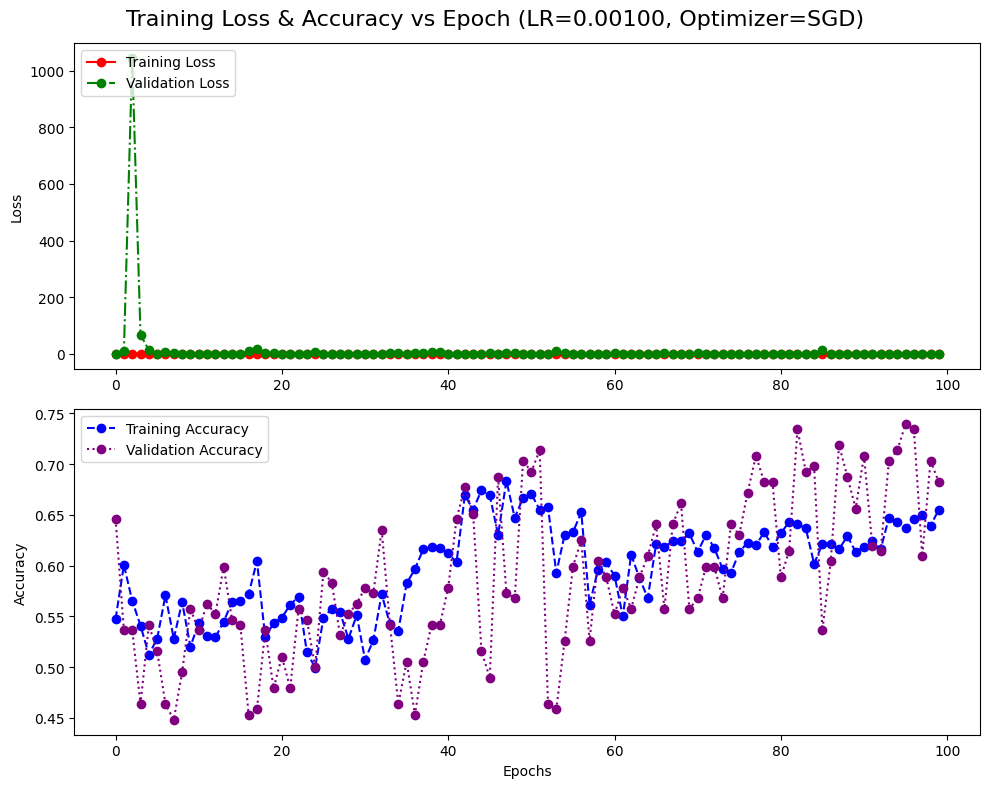

Entrenando con learning_rate=0.00100, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5914396887159533
Epoch 1 Training Loss = 2.1908116806032747
Epoch 1 Validation Accuracy = 0.5364583333333334
Epoch 1 Validation Loss = 38.52352523803711
La mejor precisión de Validation Loss (38.52352523803711) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6316472114137484
Epoch 2 Training Loss = 1.647501955081826
Epoch 2 Validation Accuracy = 0.609375
Epoch 2 Validation Loss = 36.71622085571289
La mejor precisión de Validation Loss (36.71622085571289) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.6472114137483788
Epoch 3 Training Loss = 1.085319111164751
Epoch 3 Validation Accuracy = 0.5416666666666666
Epoch 3 Validation Loss = 13.749814669291178
La mejor precisión de Validation Loss (13.749814669291178) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5577172503242542
Epoch 4 Training Loss = 1.1384216097851516
Epoch 4 Validation Accuracy = 0.5520833333333334
Epoch 4 Validation Loss = 5.695247650146484
La mejor precisión de Validation Loss (5.695247650146484) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5642023346303502
Epoch 5 Training Loss = 0.9585872056728516
Epoch 5 Validation Accuracy = 0.4427083333333333
Epoch 5 Validation Loss = 2.8056534131368003
La mejor precisión de Validation Loss (2.8056534131368003) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5278858625162127
Epoch 6 Training Loss = 1.07431590835408
Epoch 6 Validation Accuracy = 0.46875
Epoch 6 Validation Loss = 1.9314485788345337
La mejor precisión de Validation Loss (1.9314485788345337) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5136186770428015
Epoch 7 Training Loss = 0.9775009183104401
Epoch 7 Validation Accuracy = 0.4166666666666667
Epoch 7 Validation Loss = 21.02935028076172
La mejor precisión de Validation Loss (1.9314485788345337) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5304798962386511
Epoch 8 Training Loss = 1.1333068579087462
Epoch 8 Validation Accuracy = 0.453125
Epoch 8 Validation Loss = 1.865143616994222
La mejor precisión de Validation Loss (1.865143616994222) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5278858625162127
Epoch 9 Training Loss = 0.9107633455718074
Epoch 9 Validation Accuracy = 0.5
Epoch 9 Validation Loss = 1.0576717456181843
La mejor precisión de Validation Loss (1.0576717456181843) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5097276264591439
Epoch 10 Training Loss = 0.8782725987422018
Epoch 10 Validation Accuracy = 0.5989583333333334
Epoch 10 Validation Loss = 1.2945226033528645
La mejor precisión de Validation Loss (1.0576717456181843) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.5577172503242542
Epoch 11 Training Loss = 0.7786677874015927
Epoch 11 Validation Accuracy = 0.5833333333333334
Epoch 11 Validation Loss = 0.7355318466822306
La mejor precisión de Validation Loss (0.7355318466822306) se alcanzó en la época 11


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5473411154345007
Epoch 12 Training Loss = 0.7887828796908704
Epoch 12 Validation Accuracy = 0.578125
Epoch 12 Validation Loss = 0.7209436496098837
La mejor precisión de Validation Loss (0.7209436496098837) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.562905317769131
Epoch 13 Training Loss = 0.8126134727097052
Epoch 13 Validation Accuracy = 0.4166666666666667
Epoch 13 Validation Loss = 0.9648758967717489
La mejor precisión de Validation Loss (0.7209436496098837) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.5214007782101168
Epoch 14 Training Loss = 0.858573344508343
Epoch 14 Validation Accuracy = 0.5052083333333334
Epoch 14 Validation Loss = 0.8792166908582052
La mejor precisión de Validation Loss (0.7209436496098837) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.556420233463035
Epoch 15 Training Loss = 0.804326833608704
Epoch 15 Validation Accuracy = 0.53125
Epoch 15 Validation Loss = 0.9938665231068929
La mejor precisión de Validation Loss (0.7209436496098837) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.5758754863813229
Epoch 16 Training Loss = 0.8592951531230862
Epoch 16 Validation Accuracy = 0.5989583333333334
Epoch 16 Validation Loss = 0.6701435446739197
La mejor precisión de Validation Loss (0.6701435446739197) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.5486381322957199
Epoch 17 Training Loss = 0.792395152779714
Epoch 17 Validation Accuracy = 0.5833333333333334
Epoch 17 Validation Loss = 0.8970339894294739
La mejor precisión de Validation Loss (0.6701435446739197) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.5512321660181583
Epoch 18 Training Loss = 0.8775939463641393
Epoch 18 Validation Accuracy = 0.59375
Epoch 18 Validation Loss = 0.6815852721532186
La mejor precisión de Validation Loss (0.6701435446739197) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.5291828793774319
Epoch 19 Training Loss = 0.8162390397989642
Epoch 19 Validation Accuracy = 0.5260416666666666
Epoch 19 Validation Loss = 0.6627695759137472
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.5551232166018158
Epoch 20 Training Loss = 0.80969666970843
Epoch 20 Validation Accuracy = 0.46875
Epoch 20 Validation Loss = 2.2089827060699463
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5551232166018158
Epoch 21 Training Loss = 0.8402326124032957
Epoch 21 Validation Accuracy = 0.5572916666666666
Epoch 21 Validation Loss = 0.6988991498947144
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.5603112840466926
Epoch 22 Training Loss = 0.8396229059779691
Epoch 22 Validation Accuracy = 0.546875
Epoch 22 Validation Loss = 0.8257951537768046
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.5369649805447471
Epoch 23 Training Loss = 0.9804112940601493
Epoch 23 Validation Accuracy = 0.5416666666666666
Epoch 23 Validation Loss = 1.0619852145512898
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.5706874189364461
Epoch 24 Training Loss = 0.9218785702486446
Epoch 24 Validation Accuracy = 0.4895833333333333
Epoch 24 Validation Loss = 9.455523490905762
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.543450064850843
Epoch 25 Training Loss = 0.8956928623480246
Epoch 25 Validation Accuracy = 0.453125
Epoch 25 Validation Loss = 4.921738783518474
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5499351491569391
Epoch 26 Training Loss = 0.8345534926722485
Epoch 26 Validation Accuracy = 0.5
Epoch 26 Validation Loss = 1.6919604937235515
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.522697795071336
Epoch 27 Training Loss = 0.8378409572264564
Epoch 27 Validation Accuracy = 0.53125
Epoch 27 Validation Loss = 3.0548336505889893
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5525291828793775
Epoch 28 Training Loss = 0.8571688508863734
Epoch 28 Validation Accuracy = 0.5
Epoch 28 Validation Loss = 1.0266575614611309
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.5680933852140078
Epoch 29 Training Loss = 0.8233186118642953
Epoch 29 Validation Accuracy = 0.625
Epoch 29 Validation Loss = 0.7512983083724976
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.5499351491569391
Epoch 30 Training Loss = 0.8583448254799255
Epoch 30 Validation Accuracy = 0.6145833333333334
Epoch 30 Validation Loss = 0.9597940643628439
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.5460440985732814
Epoch 31 Training Loss = 0.8379100583947895
Epoch 31 Validation Accuracy = 0.6041666666666666
Epoch 31 Validation Loss = 0.7987824281056722
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.5590142671854734
Epoch 32 Training Loss = 0.8357187552829352
Epoch 32 Validation Accuracy = 0.5989583333333334
Epoch 32 Validation Loss = 0.7922560175259908
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.5719844357976653
Epoch 33 Training Loss = 0.799847597355354
Epoch 33 Validation Accuracy = 0.4427083333333333
Epoch 33 Validation Loss = 0.7990082105000814
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.5590142671854734
Epoch 34 Training Loss = 0.8002097751998407
Epoch 34 Validation Accuracy = 0.609375
Epoch 34 Validation Loss = 0.6968862016995748
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.5590142671854734
Epoch 35 Training Loss = 0.802990754136161
Epoch 35 Validation Accuracy = 0.5989583333333334
Epoch 35 Validation Loss = 0.7125990986824036
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.5667963683527886
Epoch 36 Training Loss = 0.822171023847528
Epoch 36 Validation Accuracy = 0.59375
Epoch 36 Validation Loss = 0.7364400426546732
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.569390402075227
Epoch 37 Training Loss = 0.8122331925248667
Epoch 37 Validation Accuracy = 0.5729166666666666
Epoch 37 Validation Loss = 0.7798905372619629
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.5473411154345007
Epoch 38 Training Loss = 0.9206107961528496
Epoch 38 Validation Accuracy = 0.5885416666666666
Epoch 38 Validation Loss = 0.7594496607780457
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.5408560311284046
Epoch 39 Training Loss = 0.8497911584207211
Epoch 39 Validation Accuracy = 0.578125
Epoch 39 Validation Loss = 0.7238459587097168
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.5784695201037614
Epoch 40 Training Loss = 0.7741974906853355
Epoch 40 Validation Accuracy = 0.5625
Epoch 40 Validation Loss = 0.8614431420962015
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.5343709468223087
Epoch 41 Training Loss = 0.8745727337288022
Epoch 41 Validation Accuracy = 0.5885416666666666
Epoch 41 Validation Loss = 1.0968907475471497
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.5421530479896238
Epoch 42 Training Loss = 0.9679094573093914
Epoch 42 Validation Accuracy = 0.578125
Epoch 42 Validation Loss = 0.9023130536079407
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.543450064850843
Epoch 43 Training Loss = 0.8967742270532749
Epoch 43 Validation Accuracy = 0.4635416666666667
Epoch 43 Validation Loss = 0.7432062824567159
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.5265888456549935
Epoch 44 Training Loss = 0.9458243226108229
Epoch 44 Validation Accuracy = 0.5364583333333334
Epoch 44 Validation Loss = 0.8219597935676575
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.5486381322957199
Epoch 45 Training Loss = 0.8730316325229739
Epoch 45 Validation Accuracy = 0.4375
Epoch 45 Validation Loss = 0.9065841635068258
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.5395590142671854
Epoch 46 Training Loss = 0.8505799561623005
Epoch 46 Validation Accuracy = 0.5520833333333334
Epoch 46 Validation Loss = 0.9310807188351949
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.5291828793774319
Epoch 47 Training Loss = 0.8644796401146321
Epoch 47 Validation Accuracy = 0.5260416666666666
Epoch 47 Validation Loss = 0.9556664029757181
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.5577172503242542
Epoch 48 Training Loss = 0.8120557900841907
Epoch 48 Validation Accuracy = 0.5625
Epoch 48 Validation Loss = 2.060314655303955
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.5343709468223087
Epoch 49 Training Loss = 0.862612147352884
Epoch 49 Validation Accuracy = 0.46875
Epoch 49 Validation Loss = 0.7641555269559225
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.5201037613488976
Epoch 50 Training Loss = 0.879252925534502
Epoch 50 Validation Accuracy = 0.5208333333333334
Epoch 50 Validation Loss = 0.7224817872047424
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.5421530479896238
Epoch 51 Training Loss = 0.8387138671139026
Epoch 51 Validation Accuracy = 0.5364583333333334
Epoch 51 Validation Loss = 0.8013723492622375
La mejor precisión de Validation Loss (0.6627695759137472) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.5278858625162127
Epoch 52 Training Loss = 0.8239224368341548
Epoch 52 Validation Accuracy = 0.5572916666666666
Epoch 52 Validation Loss = 0.651972770690918
La mejor precisión de Validation Loss (0.651972770690918) se alcanzó en la época 52


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.5486381322957199
Epoch 53 Training Loss = 0.7721011699714858
Epoch 53 Validation Accuracy = 0.5885416666666666
Epoch 53 Validation Loss = 0.6456607977549235
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.5214007782101168
Epoch 54 Training Loss = 0.83059350858248
Epoch 54 Validation Accuracy = 0.4895833333333333
Epoch 54 Validation Loss = 1.2878851095835369
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.5369649805447471
Epoch 55 Training Loss = 0.9740669885034228
Epoch 55 Validation Accuracy = 0.5729166666666666
Epoch 55 Validation Loss = 0.7821976939837137
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.5188067444876784
Epoch 56 Training Loss = 0.8877605391731522
Epoch 56 Validation Accuracy = 0.5520833333333334
Epoch 56 Validation Loss = 0.6643490791320801
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.5408560311284046
Epoch 57 Training Loss = 0.8113647501447012
Epoch 57 Validation Accuracy = 0.5677083333333334
Epoch 57 Validation Loss = 0.6747461954752604
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.5239948119325551
Epoch 58 Training Loss = 0.886907896643019
Epoch 58 Validation Accuracy = 0.5989583333333334
Epoch 58 Validation Loss = 0.6501081784566244
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.4980544747081712
Epoch 59 Training Loss = 0.8267166640817268
Epoch 59 Validation Accuracy = 0.5625
Epoch 59 Validation Loss = 0.6511724789937338
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.5330739299610895
Epoch 60 Training Loss = 0.8177154650174845
Epoch 60 Validation Accuracy = 0.5416666666666666
Epoch 60 Validation Loss = 0.6534941792488098
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.5239948119325551
Epoch 61 Training Loss = 0.8427555368568183
Epoch 61 Validation Accuracy = 0.4947916666666667
Epoch 61 Validation Loss = 0.7347356279691061
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.556420233463035
Epoch 62 Training Loss = 0.8313849471538447
Epoch 62 Validation Accuracy = 0.5520833333333334
Epoch 62 Validation Loss = 0.9740975300470988
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.5421530479896238
Epoch 63 Training Loss = 0.8740511533119335
Epoch 63 Validation Accuracy = 0.5572916666666666
Epoch 63 Validation Loss = 0.948599616686503
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.5473411154345007
Epoch 64 Training Loss = 0.8387292594529312
Epoch 64 Validation Accuracy = 0.53125
Epoch 64 Validation Loss = 0.6637724041938782
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.5136186770428015
Epoch 65 Training Loss = 0.8465106580817128
Epoch 65 Validation Accuracy = 0.5364583333333334
Epoch 65 Validation Loss = 0.6910568277041117
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.5616083009079118
Epoch 66 Training Loss = 0.7819378335033719
Epoch 66 Validation Accuracy = 0.5520833333333334
Epoch 66 Validation Loss = 1.7972333828608196
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.5239948119325551
Epoch 67 Training Loss = 0.9103972803603195
Epoch 67 Validation Accuracy = 0.5416666666666666
Epoch 67 Validation Loss = 2.026810805002848
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.5616083009079118
Epoch 68 Training Loss = 0.7749342133717468
Epoch 68 Validation Accuracy = 0.46875
Epoch 68 Validation Loss = 1.0622350573539734
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.543450064850843
Epoch 69 Training Loss = 0.7855082042950137
Epoch 69 Validation Accuracy = 0.5364583333333334
Epoch 69 Validation Loss = 0.748089611530304
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.5188067444876784
Epoch 70 Training Loss = 0.8186335396673893
Epoch 70 Validation Accuracy = 0.5572916666666666
Epoch 70 Validation Loss = 2.066881696383158
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.5421530479896238
Epoch 71 Training Loss = 0.7598480619345194
Epoch 71 Validation Accuracy = 0.5416666666666666
Epoch 71 Validation Loss = 0.9656721154848734
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.5447470817120622
Epoch 72 Training Loss = 0.7720284064224258
Epoch 72 Validation Accuracy = 0.5520833333333334
Epoch 72 Validation Loss = 1.419179121653239
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.5395590142671854
Epoch 73 Training Loss = 0.7841288371618002
Epoch 73 Validation Accuracy = 0.5364583333333334
Epoch 73 Validation Loss = 0.690756360689799
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.5499351491569391
Epoch 74 Training Loss = 0.8238105260599139
Epoch 74 Validation Accuracy = 0.53125
Epoch 74 Validation Loss = 0.8692046602567037
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.5175097276264592
Epoch 75 Training Loss = 0.8953967377369506
Epoch 75 Validation Accuracy = 0.4322916666666667
Epoch 75 Validation Loss = 0.9814922014872233
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.49286640726329445
Epoch 76 Training Loss = 0.9087319965492426
Epoch 76 Validation Accuracy = 0.5364583333333334
Epoch 76 Validation Loss = 0.7068058848381042
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.4980544747081712
Epoch 77 Training Loss = 1.0320294426727543
Epoch 77 Validation Accuracy = 0.53125
Epoch 77 Validation Loss = 0.8195610642433167
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.5214007782101168
Epoch 78 Training Loss = 1.0430168047953208
Epoch 78 Validation Accuracy = 0.46875
Epoch 78 Validation Loss = 7.344203154246013
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.5525291828793775
Epoch 79 Training Loss = 0.8450504660451768
Epoch 79 Validation Accuracy = 0.4739583333333333
Epoch 79 Validation Loss = 2.9339942137400308
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.5369649805447471
Epoch 80 Training Loss = 0.7964931038412448
Epoch 80 Validation Accuracy = 0.5052083333333334
Epoch 80 Validation Loss = 1.0436758597691853
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.5525291828793775
Epoch 81 Training Loss = 0.9641398655301402
Epoch 81 Validation Accuracy = 0.5416666666666666
Epoch 81 Validation Loss = 1.9409771760304768
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.5590142671854734
Epoch 82 Training Loss = 0.8719636077392271
Epoch 82 Validation Accuracy = 0.578125
Epoch 82 Validation Loss = 2.0587704181671143
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.5771725032425421
Epoch 83 Training Loss = 0.8735522746112097
Epoch 83 Validation Accuracy = 0.5260416666666666
Epoch 83 Validation Loss = 1.4271589120229085
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.6005188067444877
Epoch 84 Training Loss = 0.7921378296327652
Epoch 84 Validation Accuracy = 0.5677083333333334
Epoch 84 Validation Loss = 0.9268496235211691
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.5654993514915694
Epoch 85 Training Loss = 0.8031945229349743
Epoch 85 Validation Accuracy = 0.6197916666666666
Epoch 85 Validation Loss = 0.7341782848040262
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.5706874189364461
Epoch 86 Training Loss = 0.8060716444725502
Epoch 86 Validation Accuracy = 0.6197916666666666
Epoch 86 Validation Loss = 1.6170425812403362
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.5875486381322957
Epoch 87 Training Loss = 0.819302809841438
Epoch 87 Validation Accuracy = 0.640625
Epoch 87 Validation Loss = 1.0031146605809529
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.6134889753566797
Epoch 88 Training Loss = 0.7290393141147846
Epoch 88 Validation Accuracy = 0.6145833333333334
Epoch 88 Validation Loss = 0.7355937759081522
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.62905317769131
Epoch 89 Training Loss = 0.7326231629777357
Epoch 89 Validation Accuracy = 0.53125
Epoch 89 Validation Loss = 0.7061638434727987
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.6044098573281452
Epoch 90 Training Loss = 0.8229419093496914
Epoch 90 Validation Accuracy = 0.6770833333333334
Epoch 90 Validation Loss = 0.8167261282602946
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.603112840466926
Epoch 91 Training Loss = 0.8025688272351266
Epoch 91 Validation Accuracy = 0.65625
Epoch 91 Validation Loss = 0.9108922084172567
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.6057068741893644
Epoch 92 Training Loss = 0.7653539624504851
Epoch 92 Validation Accuracy = 0.6822916666666666
Epoch 92 Validation Loss = 0.7061023712158203
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.6070038910505836
Epoch 93 Training Loss = 0.7617288246538234
Epoch 93 Validation Accuracy = 0.6822916666666666
Epoch 93 Validation Loss = 1.1629422903060913
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.6095979247730221
Epoch 94 Training Loss = 0.796141221674809
Epoch 94 Validation Accuracy = 0.4375
Epoch 94 Validation Loss = 0.8418161273002625
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.6044098573281452
Epoch 95 Training Loss = 0.804627795704917
Epoch 95 Validation Accuracy = 0.453125
Epoch 95 Validation Loss = 0.7717670400937399
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.6381322957198443
Epoch 96 Training Loss = 0.6807840991422205
Epoch 96 Validation Accuracy = 0.640625
Epoch 96 Validation Loss = 0.736990729967753
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.6433203631647212
Epoch 97 Training Loss = 0.7141059042182878
Epoch 97 Validation Accuracy = 0.5989583333333334
Epoch 97 Validation Loss = 0.7307844956715902
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.5706874189364461
Epoch 98 Training Loss = 0.8084493499399005
Epoch 98 Validation Accuracy = 0.5260416666666666
Epoch 98 Validation Loss = 0.6966672738393148
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.5304798962386511
Epoch 99 Training Loss = 0.7965207338023897
Epoch 99 Validation Accuracy = 0.546875
Epoch 99 Validation Loss = 0.7153251568476359
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.569390402075227
Epoch 100 Training Loss = 0.8094906230226411
Epoch 100 Validation Accuracy = 0.5625
Epoch 100 Validation Loss = 1.2317157586415608
La mejor precisión de Validation Loss (0.6456607977549235) se alcanzó en la época 53


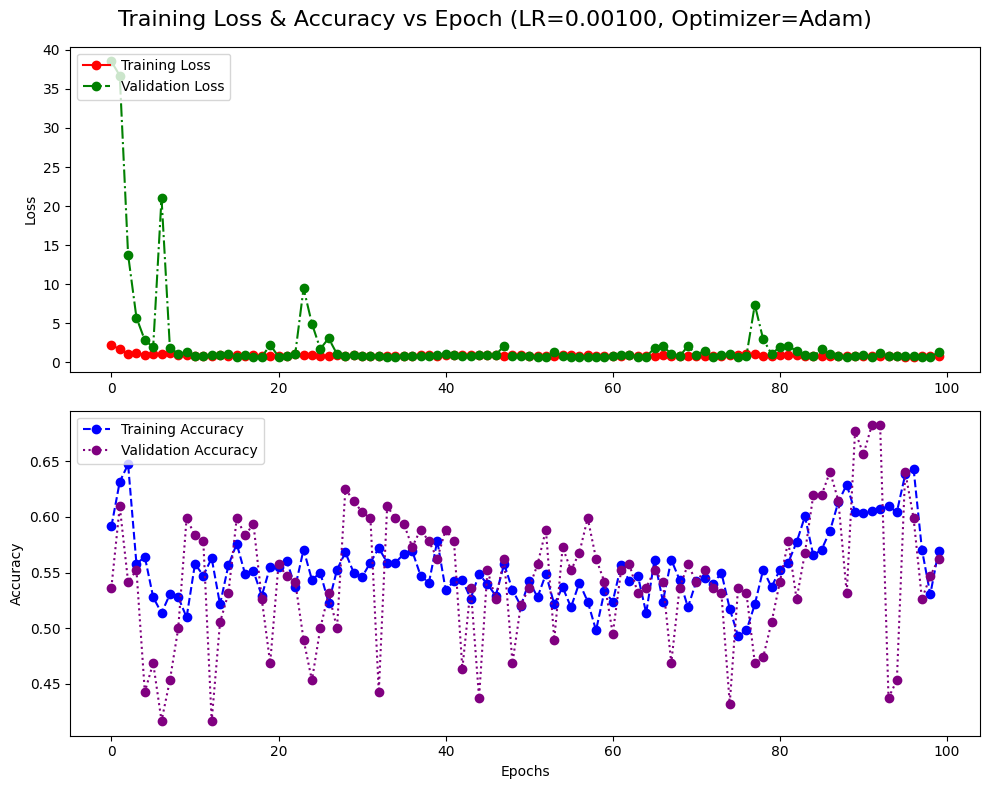

Entrenando con learning_rate=0.00100, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5201037613488976
Epoch 1 Training Loss = 4.530473602459743
Epoch 1 Validation Accuracy = 0.5416666666666666
Epoch 1 Validation Loss = 1.5550544261932373
La mejor precisión de Validation Loss (1.5550544261932373) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.5149156939040207
Epoch 2 Training Loss = 1.7506324093010948
Epoch 2 Validation Accuracy = 0.546875
Epoch 2 Validation Loss = 64.17380905151367
La mejor precisión de Validation Loss (1.5550544261932373) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5901426718547341
Epoch 3 Training Loss = 1.2802587376494352
Epoch 3 Validation Accuracy = 0.4947916666666667
Epoch 3 Validation Loss = 3.411142031351725
La mejor precisión de Validation Loss (1.5550544261932373) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.582360570687419
Epoch 4 Training Loss = 1.4164274305530404
Epoch 4 Validation Accuracy = 0.4635416666666667
Epoch 4 Validation Loss = 1.0534628033638
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.5214007782101168
Epoch 5 Training Loss = 1.519088199089164
Epoch 5 Validation Accuracy = 0.4635416666666667
Epoch 5 Validation Loss = 1.7100454171498616
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5382619974059663
Epoch 6 Training Loss = 1.377880142047402
Epoch 6 Validation Accuracy = 0.5416666666666666
Epoch 6 Validation Loss = 2.833559274673462
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.4487678339818418
Epoch 7 Training Loss = 2.0711476983147374
Epoch 7 Validation Accuracy = 0.4583333333333333
Epoch 7 Validation Loss = 1238.7008463541667
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5369649805447471
Epoch 8 Training Loss = 1.1379823975371326
Epoch 8 Validation Accuracy = 0.53125
Epoch 8 Validation Loss = 10.20208772023519
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.5317769130998703
Epoch 9 Training Loss = 1.1713584657618352
Epoch 9 Validation Accuracy = 0.5364583333333334
Epoch 9 Validation Loss = 3.051682631174723
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5252918287937743
Epoch 10 Training Loss = 1.1529309090550617
Epoch 10 Validation Accuracy = 0.546875
Epoch 10 Validation Loss = 1.716139554977417
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.4798962386511025
Epoch 11 Training Loss = 1.185062018504557
Epoch 11 Validation Accuracy = 0.46875
Epoch 11 Validation Loss = 49.21291859944662
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.5317769130998703
Epoch 12 Training Loss = 1.0222663534938052
Epoch 12 Validation Accuracy = 0.5572916666666666
Epoch 12 Validation Loss = 5.831071853637695
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.5201037613488976
Epoch 13 Training Loss = 1.081572777875512
Epoch 13 Validation Accuracy = 0.4270833333333333
Epoch 13 Validation Loss = 31.740156173706055
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.5395590142671854
Epoch 14 Training Loss = 1.029115478043117
Epoch 14 Validation Accuracy = 0.5208333333333334
Epoch 14 Validation Loss = 2.563170870145162
La mejor precisión de Validation Loss (1.0534628033638) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.569390402075227
Epoch 15 Training Loss = 1.019186767158805
Epoch 15 Validation Accuracy = 0.5364583333333334
Epoch 15 Validation Loss = 0.9434120456377665
La mejor precisión de Validation Loss (0.9434120456377665) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.5369649805447471
Epoch 16 Training Loss = 0.8889324278528433
Epoch 16 Validation Accuracy = 0.5260416666666666
Epoch 16 Validation Loss = 1.0983941753705342
La mejor precisión de Validation Loss (0.9434120456377665) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.5019455252918288
Epoch 17 Training Loss = 0.9545092007529411
Epoch 17 Validation Accuracy = 0.46875
Epoch 17 Validation Loss = 0.7041449745496114
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.4656290531776913
Epoch 18 Training Loss = 0.9344378293874818
Epoch 18 Validation Accuracy = 0.4635416666666667
Epoch 18 Validation Loss = 0.9282241662343343
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.5356679636835279
Epoch 19 Training Loss = 0.9257819066174454
Epoch 19 Validation Accuracy = 0.546875
Epoch 19 Validation Loss = 1.017371674378713
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.5577172503242542
Epoch 20 Training Loss = 0.8329426330041947
Epoch 20 Validation Accuracy = 0.5364583333333334
Epoch 20 Validation Loss = 0.7825156052907308
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.5369649805447471
Epoch 21 Training Loss = 0.8563590771802514
Epoch 21 Validation Accuracy = 0.5364583333333334
Epoch 21 Validation Loss = 1.9681825240453084
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.556420233463035
Epoch 22 Training Loss = 1.241335386277482
Epoch 22 Validation Accuracy = 0.5625
Epoch 22 Validation Loss = 2.37381911277771
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.5084306095979247
Epoch 23 Training Loss = 1.0652661131822954
Epoch 23 Validation Accuracy = 0.46875
Epoch 23 Validation Loss = 1.2850547234217327
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.522697795071336
Epoch 24 Training Loss = 1.0163907881067575
Epoch 24 Validation Accuracy = 0.4583333333333333
Epoch 24 Validation Loss = 2.0893285274505615
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.5058365758754864
Epoch 25 Training Loss = 1.3529625413637372
Epoch 25 Validation Accuracy = 0.4427083333333333
Epoch 25 Validation Loss = 1.901280363400777
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.5045395590142672
Epoch 26 Training Loss = 1.0837968122479826
Epoch 26 Validation Accuracy = 0.5364583333333334
Epoch 26 Validation Loss = 1.0370784600575764
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.5188067444876784
Epoch 27 Training Loss = 1.1301271563683348
Epoch 27 Validation Accuracy = 0.546875
Epoch 27 Validation Loss = 0.9655875960985819
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.5019455252918288
Epoch 28 Training Loss = 0.9645575861677276
Epoch 28 Validation Accuracy = 0.4739583333333333
Epoch 28 Validation Loss = 1.4491182168324788
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.5265888456549935
Epoch 29 Training Loss = 1.0284850028006483
Epoch 29 Validation Accuracy = 0.4635416666666667
Epoch 29 Validation Loss = 1.3113473653793335
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.5110246433203631
Epoch 30 Training Loss = 1.295504507561602
Epoch 30 Validation Accuracy = 0.53125
Epoch 30 Validation Loss = 3.561007499694824
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.5201037613488976
Epoch 31 Training Loss = 1.075658774116933
Epoch 31 Validation Accuracy = 0.5
Epoch 31 Validation Loss = 3.259973684946696
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.49286640726329445
Epoch 32 Training Loss = 0.9586461799463255
Epoch 32 Validation Accuracy = 0.5625
Epoch 32 Validation Loss = 4.992334365844727
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.5110246433203631
Epoch 33 Training Loss = 0.9198903508687297
Epoch 33 Validation Accuracy = 0.4427083333333333
Epoch 33 Validation Loss = 1.1623966097831726
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.5382619974059663
Epoch 34 Training Loss = 0.8205859012486251
Epoch 34 Validation Accuracy = 0.5260416666666666
Epoch 34 Validation Loss = 1.094919482866923
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.5460440985732814
Epoch 35 Training Loss = 0.9624720700520022
Epoch 35 Validation Accuracy = 0.5364583333333334
Epoch 35 Validation Loss = 0.8908701539039612
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.5590142671854734
Epoch 36 Training Loss = 1.0114780724744388
Epoch 36 Validation Accuracy = 0.5
Epoch 36 Validation Loss = 1.9351122776667278
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.5278858625162127
Epoch 37 Training Loss = 1.054630626268424
Epoch 37 Validation Accuracy = 0.5364583333333334
Epoch 37 Validation Loss = 1.5654253562291462
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.5590142671854734
Epoch 38 Training Loss = 0.9750075228174063
Epoch 38 Validation Accuracy = 0.5208333333333334
Epoch 38 Validation Loss = 1.7430024147033691
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.5499351491569391
Epoch 39 Training Loss = 0.9861059844416558
Epoch 39 Validation Accuracy = 0.4114583333333333
Epoch 39 Validation Loss = 7.004269440968831
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.5525291828793775
Epoch 40 Training Loss = 1.0812501789067042
Epoch 40 Validation Accuracy = 0.4479166666666667
Epoch 40 Validation Loss = 2.2237958510716758
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.5408560311284046
Epoch 41 Training Loss = 0.8381104289944225
Epoch 41 Validation Accuracy = 0.5416666666666666
Epoch 41 Validation Loss = 1.542490045229594
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.5356679636835279
Epoch 42 Training Loss = 1.1280335851216594
Epoch 42 Validation Accuracy = 0.5416666666666666
Epoch 42 Validation Loss = 0.7227278153101603
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.5836575875486382
Epoch 43 Training Loss = 0.7892581890065382
Epoch 43 Validation Accuracy = 0.5520833333333334
Epoch 43 Validation Loss = 1.4697765509287517
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.569390402075227
Epoch 44 Training Loss = 0.9460928704101597
Epoch 44 Validation Accuracy = 0.5989583333333334
Epoch 44 Validation Loss = 0.8245735565821329
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.5745784695201037
Epoch 45 Training Loss = 0.815332511983493
Epoch 45 Validation Accuracy = 0.5364583333333334
Epoch 45 Validation Loss = 1.5017928282419841
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.5888456549935149
Epoch 46 Training Loss = 1.0718843546803514
Epoch 46 Validation Accuracy = 0.5989583333333334
Epoch 46 Validation Loss = 0.8333421150843302
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.5603112840466926
Epoch 47 Training Loss = 0.9548023618303539
Epoch 47 Validation Accuracy = 0.5364583333333334
Epoch 47 Validation Loss = 0.7243597507476807
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.603112840466926
Epoch 48 Training Loss = 0.7580576832037801
Epoch 48 Validation Accuracy = 0.4791666666666667
Epoch 48 Validation Loss = 2.610039552052816
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.5590142671854734
Epoch 49 Training Loss = 1.0597326699088674
Epoch 49 Validation Accuracy = 0.5520833333333334
Epoch 49 Validation Loss = 0.8649238149325053
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.5265888456549935
Epoch 50 Training Loss = 1.0888795630013433
Epoch 50 Validation Accuracy = 0.546875
Epoch 50 Validation Loss = 1.867345889409383
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.6018158236057068
Epoch 51 Training Loss = 0.9022390460535091
Epoch 51 Validation Accuracy = 0.359375
Epoch 51 Validation Loss = 2.8167382876078286
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.6212710765239948
Epoch 52 Training Loss = 0.8806322611259579
Epoch 52 Validation Accuracy = 0.5625
Epoch 52 Validation Loss = 4.21306840578715
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.5590142671854734
Epoch 53 Training Loss = 1.2115725408732196
Epoch 53 Validation Accuracy = 0.453125
Epoch 53 Validation Loss = 3.8335155646006265
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.5719844357976653
Epoch 54 Training Loss = 1.0925760941553364
Epoch 54 Validation Accuracy = 0.5208333333333334
Epoch 54 Validation Loss = 1.623273213704427
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.5330739299610895
Epoch 55 Training Loss = 0.8877843344721813
Epoch 55 Validation Accuracy = 0.484375
Epoch 55 Validation Loss = 2.9337306022644043
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.5291828793774319
Epoch 56 Training Loss = 1.1959119872824227
Epoch 56 Validation Accuracy = 0.6041666666666666
Epoch 56 Validation Loss = 2.5040698846181235
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.5836575875486382
Epoch 57 Training Loss = 0.8653046809591053
Epoch 57 Validation Accuracy = 0.4895833333333333
Epoch 57 Validation Loss = 4.346841812133789
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.5265888456549935
Epoch 58 Training Loss = 1.0994790783574764
Epoch 58 Validation Accuracy = 0.5677083333333334
Epoch 58 Validation Loss = 1.2012295325597127
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.5317769130998703
Epoch 59 Training Loss = 0.9081757022249095
Epoch 59 Validation Accuracy = 0.4791666666666667
Epoch 59 Validation Loss = 3.6164637406667075
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.5680933852140078
Epoch 60 Training Loss = 0.937673819281557
Epoch 60 Validation Accuracy = 0.5885416666666666
Epoch 60 Validation Loss = 0.8152517278989156
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.5914396887159533
Epoch 61 Training Loss = 0.7498951436789892
Epoch 61 Validation Accuracy = 0.5364583333333334
Epoch 61 Validation Loss = 1.5523353417714436
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.5732814526588845
Epoch 62 Training Loss = 1.1048338552393338
Epoch 62 Validation Accuracy = 0.46875
Epoch 62 Validation Loss = 38.998772939046226
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.5616083009079118
Epoch 63 Training Loss = 0.900742718681751
Epoch 63 Validation Accuracy = 0.4583333333333333
Epoch 63 Validation Loss = 3.4393276373545327
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.5603112840466926
Epoch 64 Training Loss = 0.8279056077492067
Epoch 64 Validation Accuracy = 0.5572916666666666
Epoch 64 Validation Loss = 1.4806874990463257
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.6083009079118028
Epoch 65 Training Loss = 0.7545843507838466
Epoch 65 Validation Accuracy = 0.5052083333333334
Epoch 65 Validation Loss = 1.9764324426651
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.5603112840466926
Epoch 66 Training Loss = 0.9635884058305416
Epoch 66 Validation Accuracy = 0.515625
Epoch 66 Validation Loss = 1.114320993423462
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.5603112840466926
Epoch 67 Training Loss = 0.8919787115469362
Epoch 67 Validation Accuracy = 0.5416666666666666
Epoch 67 Validation Loss = 0.986499547958374
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.5784695201037614
Epoch 68 Training Loss = 0.789599719175878
Epoch 68 Validation Accuracy = 0.53125
Epoch 68 Validation Loss = 6.979974110921224
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.5616083009079118
Epoch 69 Training Loss = 0.8855594389633445
Epoch 69 Validation Accuracy = 0.5416666666666666
Epoch 69 Validation Loss = 1.962911566098531
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.5265888456549935
Epoch 70 Training Loss = 1.0040076668005817
Epoch 70 Validation Accuracy = 0.578125
Epoch 70 Validation Loss = 0.7691324949264526
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.5577172503242542
Epoch 71 Training Loss = 0.8146153033630084
Epoch 71 Validation Accuracy = 0.5729166666666666
Epoch 71 Validation Loss = 1.6182194948196411
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.5447470817120622
Epoch 72 Training Loss = 0.8277865845019097
Epoch 72 Validation Accuracy = 0.6145833333333334
Epoch 72 Validation Loss = 1.1940609614054363
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.5771725032425421
Epoch 73 Training Loss = 0.7951303060261965
Epoch 73 Validation Accuracy = 0.625
Epoch 73 Validation Loss = 1.0432485342025757
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.5888456549935149
Epoch 74 Training Loss = 0.8392722829306636
Epoch 74 Validation Accuracy = 0.4739583333333333
Epoch 74 Validation Loss = 2.7562113602956138
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.5771725032425421
Epoch 75 Training Loss = 1.1080950745194185
Epoch 75 Validation Accuracy = 0.5677083333333334
Epoch 75 Validation Loss = 1.0371543566385906
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.5979247730220493
Epoch 76 Training Loss = 0.8429171401239091
Epoch 76 Validation Accuracy = 0.5833333333333334
Epoch 76 Validation Loss = 1.2590432564417522
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.5667963683527886
Epoch 77 Training Loss = 0.850958164022745
Epoch 77 Validation Accuracy = 0.4635416666666667
Epoch 77 Validation Loss = 2.314021627108256
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.5979247730220493
Epoch 78 Training Loss = 0.8069098663701157
Epoch 78 Validation Accuracy = 0.53125
Epoch 78 Validation Loss = 1.8257755041122437
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.6121919584954605
Epoch 79 Training Loss = 0.8143163408441457
Epoch 79 Validation Accuracy = 0.4739583333333333
Epoch 79 Validation Loss = 1.6019206444422405
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.5538261997405967
Epoch 80 Training Loss = 0.8766059492039464
Epoch 80 Validation Accuracy = 0.4583333333333333
Epoch 80 Validation Loss = 1.4546335538228352
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.5706874189364461
Epoch 81 Training Loss = 1.1308443598864761
Epoch 81 Validation Accuracy = 0.4635416666666667
Epoch 81 Validation Loss = 2.8392879962921143
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.5966277561608301
Epoch 82 Training Loss = 0.9974654947737311
Epoch 82 Validation Accuracy = 0.5677083333333334
Epoch 82 Validation Loss = 1.226599136988322
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.6005188067444877
Epoch 83 Training Loss = 0.8142034421866969
Epoch 83 Validation Accuracy = 0.65625
Epoch 83 Validation Loss = 0.9618265827496847
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.603112840466926
Epoch 84 Training Loss = 0.8487329094944915
Epoch 84 Validation Accuracy = 0.4375
Epoch 84 Validation Loss = 49.68695576985677
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.5499351491569391
Epoch 85 Training Loss = 0.8954251374174803
Epoch 85 Validation Accuracy = 0.6145833333333334
Epoch 85 Validation Loss = 1.6195478439331055
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.5797665369649806
Epoch 86 Training Loss = 0.7576764750882654
Epoch 86 Validation Accuracy = 0.5625
Epoch 86 Validation Loss = 0.8002354701360067
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.5590142671854734
Epoch 87 Training Loss = 0.8508938749631246
Epoch 87 Validation Accuracy = 0.5364583333333334
Epoch 87 Validation Loss = 1.602267821629842
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.622568093385214
Epoch 88 Training Loss = 0.7818858878621795
Epoch 88 Validation Accuracy = 0.609375
Epoch 88 Validation Loss = 0.8018253445625305
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.603112840466926
Epoch 89 Training Loss = 0.7956009432190277
Epoch 89 Validation Accuracy = 0.5208333333333334
Epoch 89 Validation Loss = 9.027722676595053
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.6160830090791181
Epoch 90 Training Loss = 0.7343393840987704
Epoch 90 Validation Accuracy = 0.4947916666666667
Epoch 90 Validation Loss = 4.744191249211629
La mejor precisión de Validation Loss (0.7041449745496114) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.5603112840466926
Epoch 91 Training Loss = 0.8758040430017019
Epoch 91 Validation Accuracy = 0.5989583333333334
Epoch 91 Validation Loss = 0.6404295365015665
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.6057068741893644
Epoch 92 Training Loss = 0.6859006294944408
Epoch 92 Validation Accuracy = 0.5989583333333334
Epoch 92 Validation Loss = 0.6959948937098185
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.569390402075227
Epoch 93 Training Loss = 0.7944509349135264
Epoch 93 Validation Accuracy = 0.59375
Epoch 93 Validation Loss = 1.3707932631174724
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.5836575875486382
Epoch 94 Training Loss = 0.8771628135991623
Epoch 94 Validation Accuracy = 0.5625
Epoch 94 Validation Loss = 3.6868659257888794
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.5771725032425421
Epoch 95 Training Loss = 0.7176274271481387
Epoch 95 Validation Accuracy = 0.53125
Epoch 95 Validation Loss = 3.267032782236735
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.5979247730220493
Epoch 96 Training Loss = 0.7391982431850854
Epoch 96 Validation Accuracy = 0.5625
Epoch 96 Validation Loss = 2.2470828692118325
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.603112840466926
Epoch 97 Training Loss = 0.7971510303468865
Epoch 97 Validation Accuracy = 0.5885416666666666
Epoch 97 Validation Loss = 0.8651984135309855
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.6095979247730221
Epoch 98 Training Loss = 0.7268815904604476
Epoch 98 Validation Accuracy = 0.5520833333333334
Epoch 98 Validation Loss = 1.0324038863182068
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.603112840466926
Epoch 99 Training Loss = 0.8222255455535364
Epoch 99 Validation Accuracy = 0.5208333333333334
Epoch 99 Validation Loss = 2.0608613093694053
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.6108949416342413
Epoch 100 Training Loss = 0.8538656095586398
Epoch 100 Validation Accuracy = 0.5677083333333334
Epoch 100 Validation Loss = 1.9180026054382324
La mejor precisión de Validation Loss (0.6404295365015665) se alcanzó en la época 91


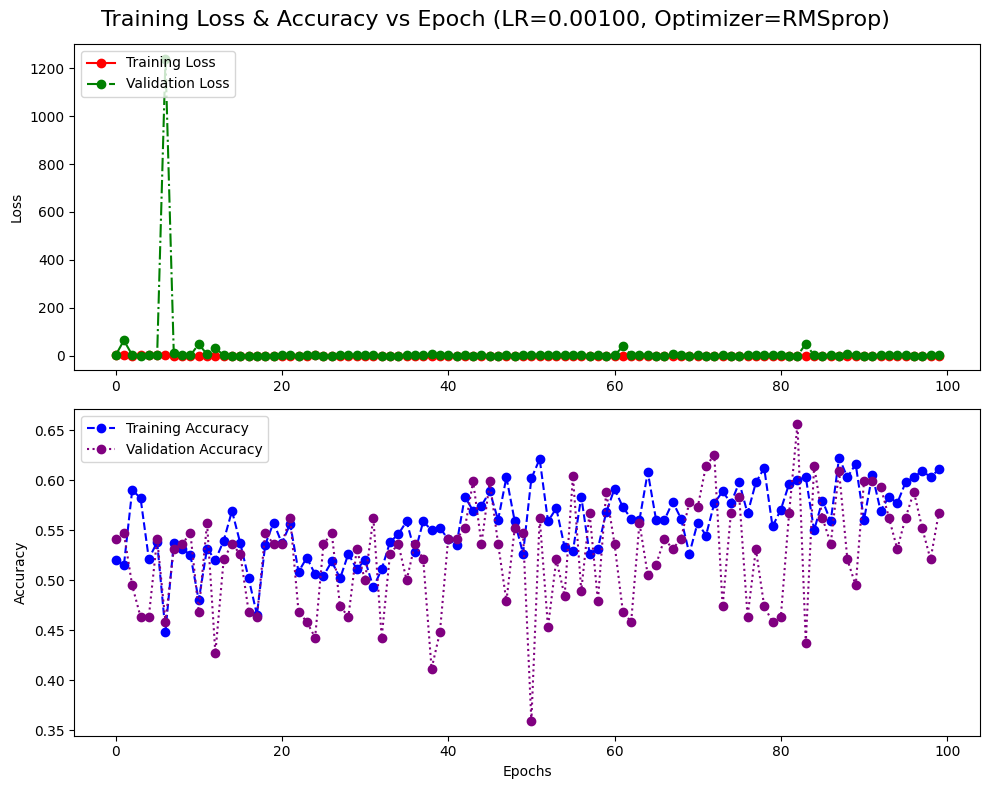

Los mejores hiperparámetros son: lr = 0.00001, optimizer = Adam


In [ ]:
from itertools import product
from sklearn.model_selection import ParameterGrid

torch.cuda.empty_cache()

epochs = 100

best_val_loss = float('inf')  # Inicializa la mejor pérdida de validación como infinito
best_hyperparameters = {}  # Almacenar los mejores hiperparámetros
best_model = None # Almacenar el mejor modelo

val_loss_dict = {}# Diccionario para almacenar los valores de val_loss por combinación de hiperparámetros


for params in ParameterGrid(param_grid):
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    print(f'Entrenando con learning_rate={learning_rate:.5f}, epochs={epochs}, optimizer={optimizer_name}')
    # loading the pretrained model
    model = models.vgg16_bn(pretrained=True)

    # Modificar la capa de clasificación para dos clases y agregar BatchNorm
    num_features = model.classifier[0].in_features

    # Definir una nueva secuencia para la capa de clasificación con BatchNorm
    classifier_with_bn = nn.Sequential(
        nn.Linear(num_features, 4096),  # Capa completamente conectada
        nn.ReLU(True),
        nn.Dropout(),
        nn.BatchNorm1d(4096),  # BatchNorm
        nn.Linear(4096, 4096),  # Capa completamente conectada
        nn.ReLU(True),
        nn.Dropout(),
        nn.BatchNorm1d(4096),  # BatchNorm
        nn.Linear(4096, num_classes)  # Capa de salida para dos clases
    )

    model.classifier = classifier_with_bn

    # Después de haber definido la capa de clasificación con BatchNorm
    for layer in model.classifier.children():
        if isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier para pesos lineales
            nn.init.zeros_(layer.bias)  # Inicialización de sesgos a cero

    # Define la función de pérdida
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # Define el optimizador fuera del bucle
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Restablece todas las variables a 0 para la próxima combinación
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    best_epoch = 0
    best_val_loss = float('inf')
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        counter = 0
        train_running_loss = 0

        # Utiliza tqdm para mostrar una barra de progreso durante el entrenamiento
        with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset
            # Etiqueta de la barra de progreso
            tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

            for images, labels in tepoch:  # Utiliza tepoch como iterable
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item() * images.size(0)

                _, pred = torch.max(outputs.data, 1)

                # Lleva un registro de cuántas imágenes se han propagado hacia adelante
                total += labels.size(0)
                # Lleva un registro de cuántas se predijeron correctamente
                correct += (pred == labels).sum().item()

                # Actualiza la barra de progreso con la pérdida actual
                tepoch.set_postfix(loss=train_running_loss/total)  # Puedes mostrar la pérdida en la barra de progreso

                # Registra las pérdidas y precisión de entrenamiento en cada época
            train_accuracy.append(correct/total)
            train_loss.append(train_running_loss/len(train_dataset))


            print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

            # Obtén nuestra precisión y pérdida de validación
            if epoch % 1 == 0:
                model.eval()
                total = 0
                correct = 0
                val_running_loss = 0

                # No necesitamos gradientes para la validación, así que envuélvelo en no_grad para ahorrar memoria
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        val_output = model(images)
                        loss_val = criterion(val_output, labels)

                        # Calcula la pérdida acumulada multiplicando el valor de pérdida por el tamaño del lote
                        val_running_loss += loss_val.item() * images.size(0)
                        _, pred = torch.max(val_output.data, 1)
                        total += labels.size(0)
                        correct += (pred == labels).sum().item()

                    val_accuracy.append(correct/total)
                    # Calcula la pérdida por época dividiendo la pérdida acumulada por el número de elementos en el conjunto de validación
                    val_loss.append(val_running_loss/len(validation_dataset))

                    # Actualiza la variable best_val_loss y guarda los pesos del modelo si la pérdida de validación actual es mejor.
                    if val_loss[-1] < best_val_loss:
                        best_val_loss = val_loss[-1]
                        # Guarda los pesos del modelo en variables para almacenarlo al finalizar el entrenamiento.
                        best_epoch = epoch
                        best_model_name = f"model_lr{learning_rate}_optimizer{optimizer_name}_epoch{best_epoch}.pth"
                        best_model_dict = model.state_dict()
                        #torch.save(model.state_dict(), best_model_name)
                        best_model = model

                    print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
                    print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(validation_dataset)}')
                    print(f"La mejor precisión de Validation Loss ({best_val_loss}) se alcanzó en la época {best_epoch + 1}")

    # Guarda los pesos del modelo en un archivo.
    torch.save(best_model_dict, best_model_name)

    # Almacena el valor de val_loss para esta combinación de hiperparámetros en el diccionario
    val_loss_dict[(learning_rate, optimizer_name)] = best_val_loss

    epoch_log = [*range(epochs)]

    # Crear la figura y los ejes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 filas, 1 columna

    # Obtener los hiperparámetros de la combinación actual
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    # Título y rotación del eje x con información de hiperparámetros
    fig.suptitle(f"Training Loss & Accuracy vs Epoch (LR={learning_rate:.5f}, Optimizer={optimizer_name})", fontsize=16)
    ax2.set_xlabel('Epochs')

    # Crear las líneas para los datos de entrenamiento (colores y estilos personalizados)
    ax1.plot(epoch_log, train_loss, color='red', linestyle='-', marker='o', label='Training Loss')
    ax2.plot(epoch_log, train_accuracy, color='blue', linestyle='--', marker='o', label='Training Accuracy')

    # Crear las líneas para los datos de validación (colores y estilos personalizados)
    ax1.plot(epoch_log, val_loss, color='green', linestyle='-.', marker='o', label='Validation Loss')
    ax2.plot(epoch_log, val_accuracy, color='purple', linestyle=':', marker='o', label='Validation Accuracy')

    # Configurar ejes y leyendas para el primer subgráfico (pérdida)
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')

    # Configurar ejes y leyendas para el segundo subgráfico (precisión)
    ax2.set_ylabel('Accuracy', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper left')

    # Ajustar el espaciado entre los subgráficos
    plt.tight_layout()

    # Nombre del archivo PDF
    pdf_filename = f"Training_Loss_Accuracy_LR_{learning_rate:.5f}_Optimizer_{optimizer_name}.pdf"

    # Guardar la gráfica en un archivo PDF
    plt.savefig(pdf_filename, format='pdf')

    # Mostrar la gráfica en pantalla
    plt.show()

    del model

# Después de completar todos los bucles, puedes determinar los mejores hiperparámetros
best_hyperparameters = min(val_loss_dict, key=lambda k: val_loss_dict[k])

print(f"Los mejores hiperparámetros son: lr = {best_hyperparameters[0]:.5f}, optimizer = {best_hyperparameters[1]}")

# **Mejores hiperparámetros**

Este bloque de código utiliza la biblioteca `termcolor` para resaltar y mostrar los mejores hiperparámetros en rojo y negrita.

- `colored(best_hyperparameters, 'red', attrs=['bold'])`: Aplica el formato de color rojo y negrita al texto almacenado en la variable `best_hyperparameters`.

- `print(highlighted_text)`: Imprime el texto resaltado en la consola.

Este bloque de código es útil para visualizar de manera destacada los mejores hiperparámetros encontrados durante el proceso de búsqueda de cuadrícula.

In [ ]:
from termcolor import colored

# Aplicar el formato y color
highlighted_text = colored(best_hyperparameters, 'red', attrs=['bold'])

# Imprimir el texto resaltado
print(highlighted_text)

(1e-05, 'Adam')
